In [2]:
import numpy as np
import hiive.mdptoolbox as mdptoolbox
import hiive.mdptoolbox.mdp
import hiive.mdptoolbox.example
import matplotlib.pyplot as plt
import seaborn as sns

MAP = [
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]


def encode(taxi_row, taxi_col, pass_loc, dest_idx):
    # (5) 5, 5, 4
    i = taxi_row
    i *= 5
    i += taxi_col
    i *= 5
    i += pass_loc
    i *= 4
    i += dest_idx
    return i


def decode(i):
    out = []
    out.append(i % 4)
    i = i // 4
    out.append(i % 5)
    i = i // 5
    out.append(i % 5)
    i = i // 5
    out.append(i)
    assert 0 <= i < 5
    return reversed(out)

def plot_matrix(policytoplot, title):

    plt.figure(figsize=(15,15))
    plt.title(title)
    sns.heatmap(policytoplot,cmap="YlGnBu", annot=True, cbar=False)
#     plt.figsize(15, 15)
    plt.show()

def plot_size_vs_rewards(linetoplot, title):
    plt.plot(linetoplot)
    plt.xlabel('Size')
    plt.ylabel('Mean V')
    plt.title(title)
    plt.show

def plot_vi_epsilon(linetoplot, title):
    plt.plot(linetoplot)
    plt.xlabel('Min Epsilon')
    plt.ylabel('Mean V')
    plt.title(title)
    plt.show

def plot_epsilon(linetoplot, title):
    plt.plot(linetoplot)
    plt.xlabel('Alpha')
    plt.ylabel('Mean V')
    plt.title(title)
    plt.show
    
    
def plot_alpha(linetoplot, title):
    plt.plot(linetoplot)
    plt.xlabel('Alpha')
    plt.ylabel('Mean V')
    plt.title(title)
    plt.show

def plot_gamma(linetoplot, title):
    plt.plot(linetoplot)
    plt.xlabel('Gamma')
    plt.ylabel('Mean V')
    plt.title(title)
    plt.show
       
def plot_q_learning_timetaken(stats):
    plt.plot(stats)

    plt.xlabel('Iterations')
    plt.ylabel('Time')
    title = 'Time vs Iterations'
    plt.title(title)
    plt.show()

def plot_q_learning(stats, plotstring, plotstring2):
    policy_rewards = []
    policy_rewards_interval = []
    i = 0
    for s in stats:
        policy_rewards.append(s['Reward'])
        if i % 100 == 0:
            policy_rewards_interval.append(s['Reward'])

    print(min(policy_rewards_interval))
    print(max(policy_rewards_interval))
    plt.plot(policy_rewards)
    # fig = plt.figure()
    # ax = fig.add_subplot(1, 1, 1)
    # ax.plot(y=policy_rewards)
    # fig.canvas.draw()
    # plt.axes.plot(y=policy_rewards)

    plt.xlabel('Iterations')
    plt.ylabel(plotstring2)
    title = plotstring + ' ' + plotstring2 + ' vs Iterations'
    plt.title(title)
    plt.show()

def plot_learning(stats, plotstring, plotstring2):
    policy_rewards = []
    for s in stats:
        policy_rewards.append(s[plotstring2])


    plt.plot(policy_rewards)
    # fig = plt.figure()
    # ax = fig.add_subplot(1, 1, 1)
    # ax.plot(y=policy_rewards)
    # fig.canvas.draw()
    # plt.axes.plot(y=policy_rewards)

    plt.xlabel('Iterations')
    plt.ylabel(plotstring2)
    title = plotstring + ' ' + plotstring2 + ' vs Iterations'
    plt.title(title)
    plt.show()

def plot_mean_v_learning(stats, plotstring, plotstring2):
    policy_rewards = []
    for s in stats:
        policy_rewards.append(s['Mean V'])

    plt.plot(policy_rewards)
    # fig = plt.figure()
    # ax = fig.add_subplot(1, 1, 1)
    # ax.plot(y=policy_rewards)
    # fig.canvas.draw()
    # plt.axes.plot(y=policy_rewards)

    plt.xlabel('Iterations')
    plt.ylabel('V')
    title = plotstring + ' ' + plotstring2 + ' vs Iterations'
    plt.title(title)
    plt.show()

desc = np.asarray(MAP, dtype='c')

locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

num_states = 500
num_rows = 5
num_columns = 5
max_row = num_rows - 1
max_col = num_columns - 1
initial_state_distrib = np.zeros(num_states)
num_actions = 6
rewards = np.zeros((num_states, num_actions))
transition_matrix = np.zeros((num_actions, num_states, num_states))
P = {state: {action: []
            for action in range(num_actions)} for state in range(num_states)}
for row in range(num_rows):
    for col in range(num_columns):
        for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
            for dest_idx in range(len(locs)):
                state = encode(row, col, pass_idx, dest_idx)
                if pass_idx < 4 and pass_idx != dest_idx:
                    initial_state_distrib[state] += 1
                for action in range(num_actions):
                    # defaults
                    new_row, new_col, new_pass_idx = row, col, pass_idx
                    reward = -1  # default reward when there is no pickup/dropoff
                    done = False
                    taxi_loc = (row, col)

                    if action == 0:
                        new_row = min(row + 1, max_row)
                    elif action == 1:
                        new_row = max(row - 1, 0)
                    if action == 2 and desc[1 + row, 2 * col + 2] == b":":
                        new_col = min(col + 1, max_col)
                    elif action == 3 and desc[1 + row, 2 * col] == b":":
                        new_col = max(col - 1, 0)
                    elif action == 4:  # pickup
                        if (pass_idx < 4 and taxi_loc == locs[pass_idx]):
                            new_pass_idx = 4
                        else:  # passenger not at location
                            reward = -10
                    elif action == 5:  # dropoff
                        if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                            new_pass_idx = dest_idx
                            done = True
                            reward = 20
                        elif (taxi_loc in locs) and pass_idx == 4:
                            new_pass_idx = locs.index(taxi_loc)
                        else:  # dropoff at wrong location
                            reward = -10
                    new_state = encode(
                        new_row, new_col, new_pass_idx, dest_idx)
                    P[state][action].append(
                        (1.0, new_state, reward, done))
                    rewards[state][action] += reward
                    transition_matrix[action][state][new_state] = 1
initial_state_distrib /= initial_state_distrib.sum()
# discrete.DiscreteEnv.__init__(
#     self, num_states, num_actions, P, initial_state_distrib)
print("hi")

hi


In [ ]:
value_iteration = mdptoolbox.mdp.ValueIteration(transitions=transition_matrix,
                                    reward=rewards,
                                    gamma=.999)
value_iteration_stats = value_iteration.run()
value_iteration_policy = np.array(value_iteration.policy).reshape(100, 5)

policy_iteration = mdptoolbox.mdp.PolicyIteration(transitions=transition_matrix,
                                    reward=rewards,
                                    gamma=.999,eval_type=1)
policy_iteration_stats = policy_iteration.run()
policy_iteration_policy = np.array(policy_iteration.policy).reshape(100, 5)

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


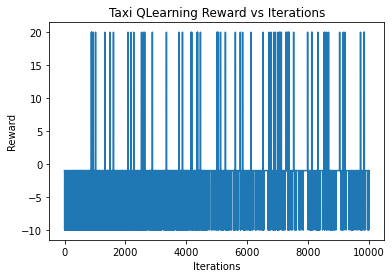

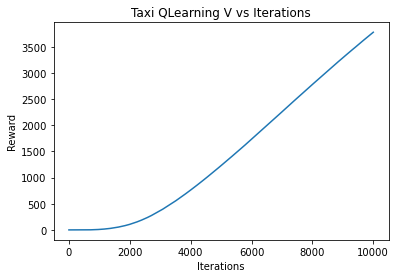

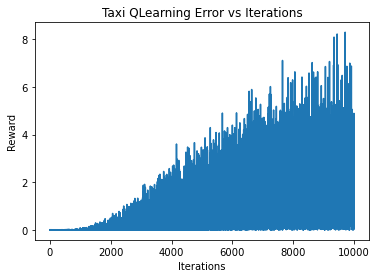

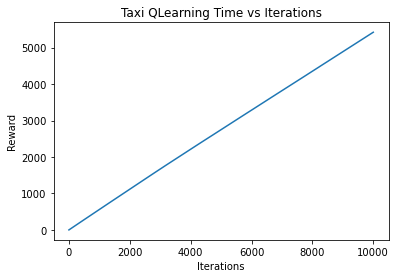

epsilon before loop:  1.0
epsilon:  0.13533526984554536
-10.0
20.0


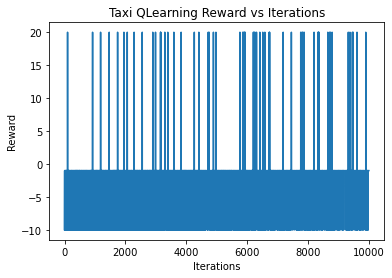

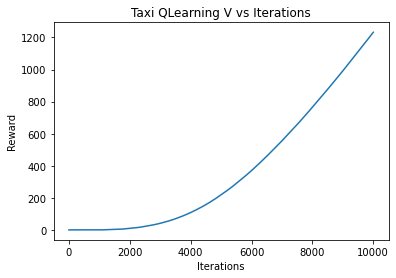

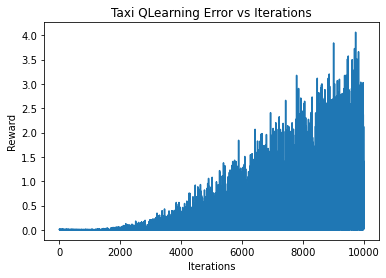

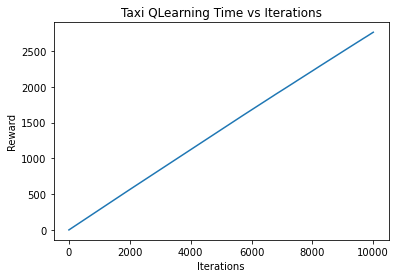

epsilon before loop:  1.0
epsilon:  0.367879422971156
-10.0
20.0


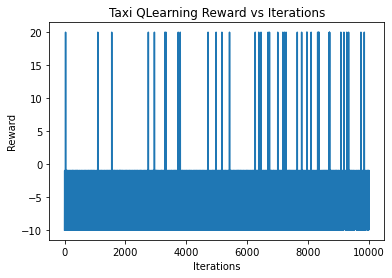

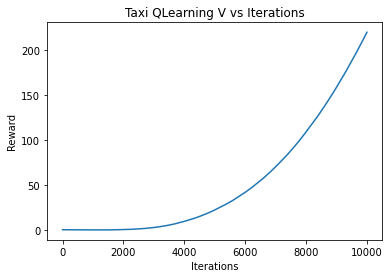

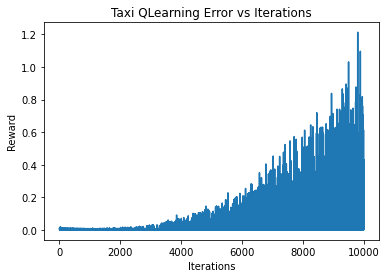

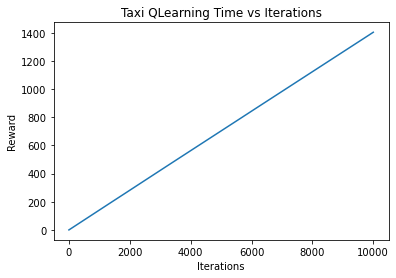

epsilon before loop:  1.0
epsilon:  0.6065306447089545
-10.0
20.0


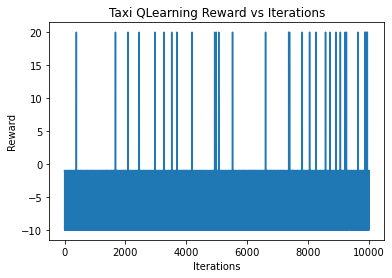

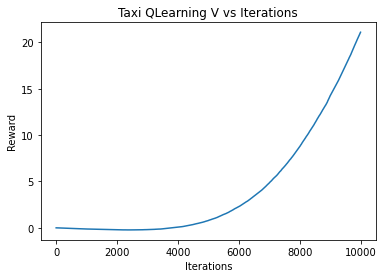

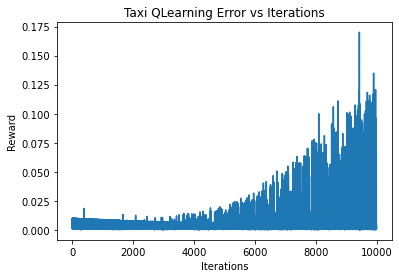

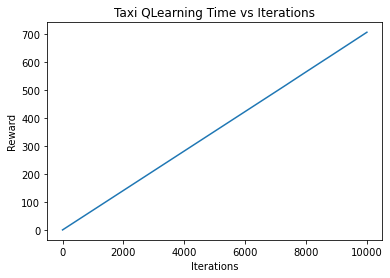

epsilon before loop:  1.0
epsilon:  0.904837413559402
-10.0
20.0


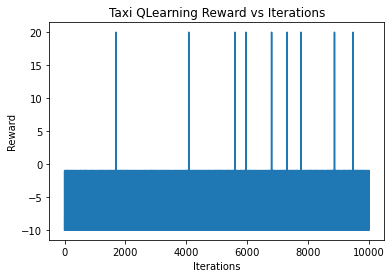

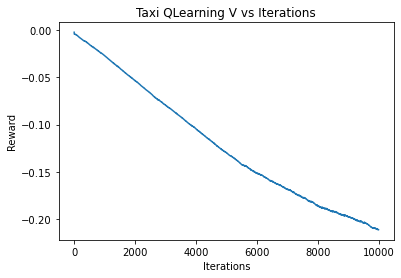

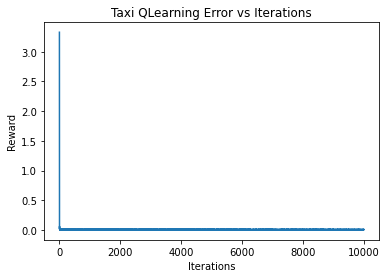

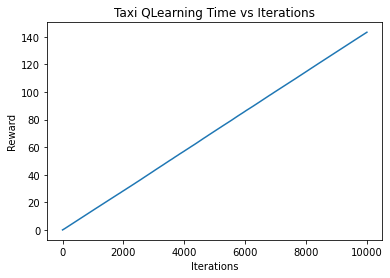

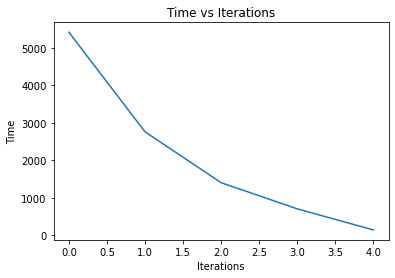

hi


In [9]:
# q_learning = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
#
iters_list = [40000000, 20000000, 10000000, 5000000, 1000000]
time_taken = []
for n in iters_list:
    q_learning = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=.999, n_iter=n, alpha=.9, alpha_decay=.99, epsilon_decay=.9999999# alpha=.6, alpha_decay=.1
                                          #,
                                          # epsilon=.1, alpha=.2,
                                          # epsilon_decay=.1, alpha_decay=.1,
                                          # epsilon_min=.01
                                          )
    q_learning_stats = q_learning.run()
    plot_q_learning(q_learning_stats, 'Taxi QLearning', 'Reward')
    plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'V')
    plot_learning(q_learning_stats, 'Taxi QLearning', 'Error')
    plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')
    time_taken.append(q_learning.time)
plot_q_learning_timetaken(time_taken)
print('hi')

In [ ]:
# q_learning = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
#                                       gamma=.999, n_iter=5000000, alpha=.9, alpha_decay=.99, epsilon_decay=.999999# alpha=.6, alpha_decay=.1
#                                       #,
#                                       # epsilon=.1, alpha=.2,
#                                       # epsilon_decay=.1, alpha_decay=.1,
#                                       # epsilon_min=.01
#                                       )
# q_learning_stats = q_learning.run()

plot_learning(value_iteration_stats, 'Taxi VI', 'Reward')
plot_learning(policy_iteration_stats, 'Taxi PI', 'Reward')
plot_q_learning(q_learning_stats, 'Taxi QLearning', 'Reward')
print(q_learning_stats[0]['Reward'])
print(q_learning_stats[9500]['Reward'])

plot_learning(policy_iteration_stats, 'Taxi PI', 'Policy Difference')

plot_mean_v_learning(value_iteration_stats, 'Taxi VI', 'V')
plot_mean_v_learning(policy_iteration_stats, 'Taxi PI',
                     'V')
plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'V')


plot_learning(value_iteration_stats, 'Taxi VI', 'Error')
plot_learning(policy_iteration_stats, 'Taxi PI', 'Error')
plot_learning(q_learning_stats, 'Taxi QLearning', 'Error')

plot_learning(value_iteration_stats, 'Taxi VI', 'Time')
plot_learning(policy_iteration_stats, 'Taxi PI', 'Time')
plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')


# random_map = np.asarray(generate_random_map(25, .7), dtype='c')
# print("hi")


epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


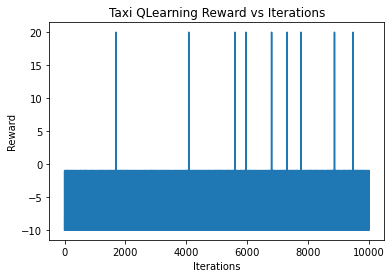

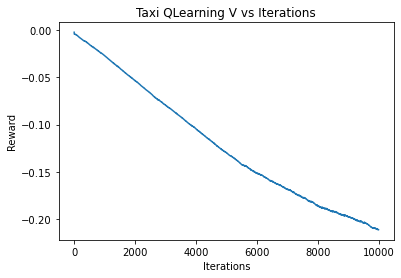

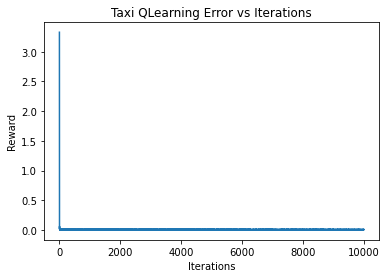

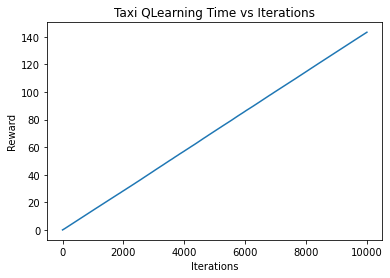

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


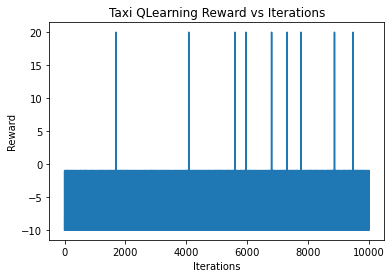

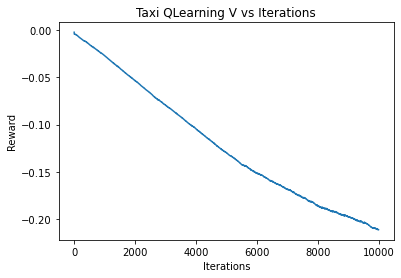

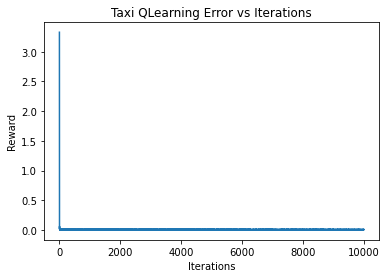

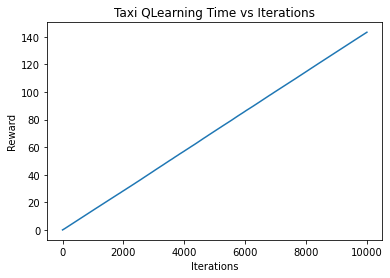

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


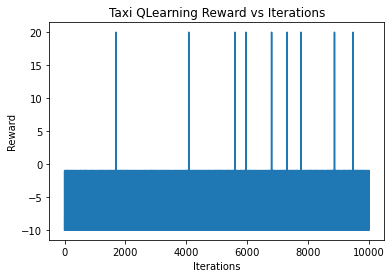

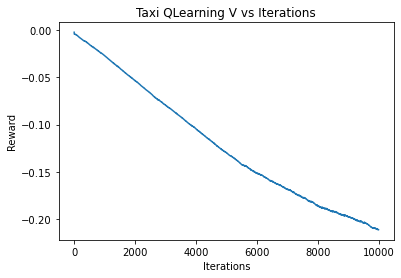

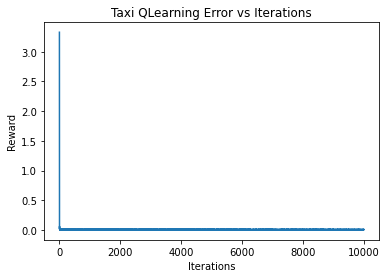

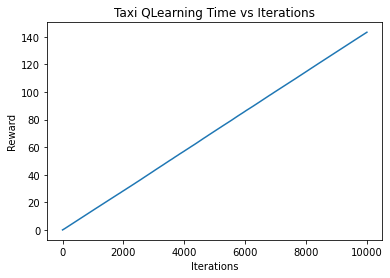

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


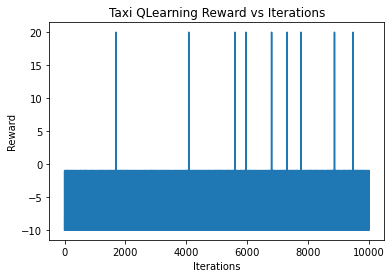

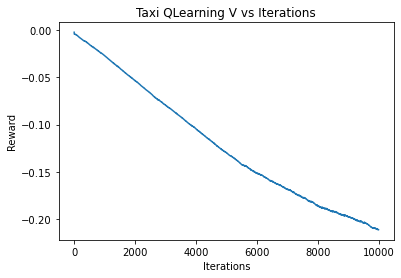

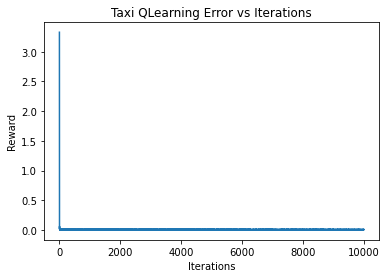

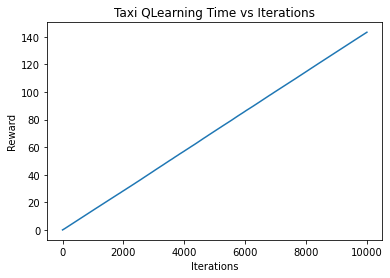

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


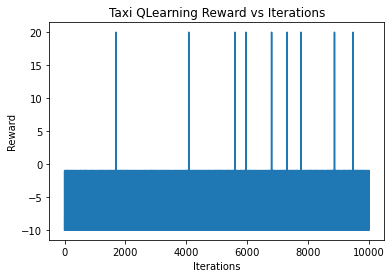

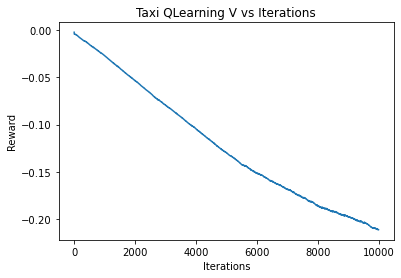

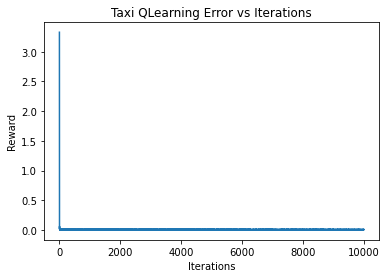

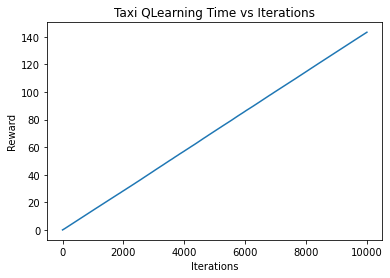

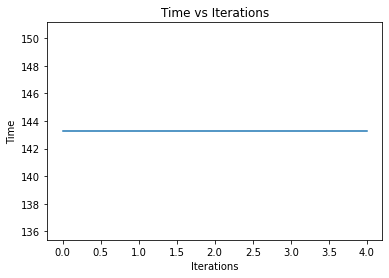

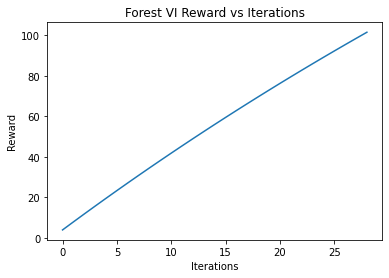

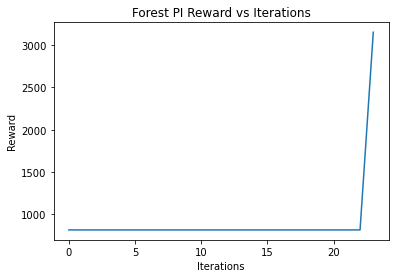

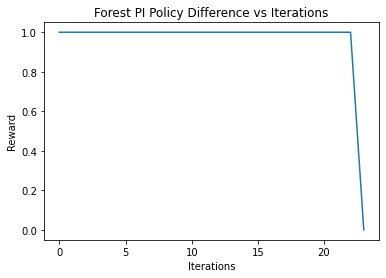

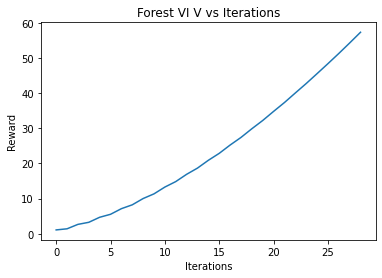

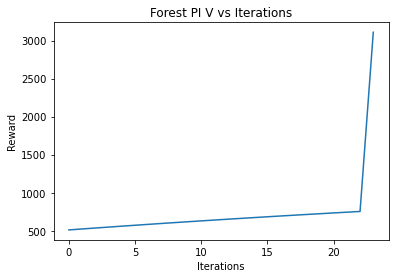

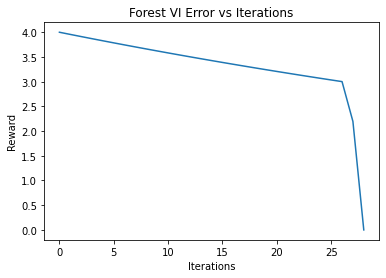

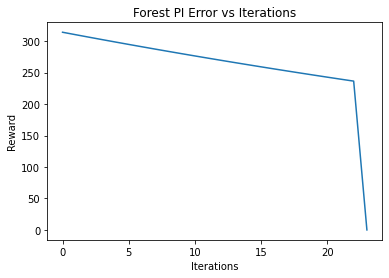

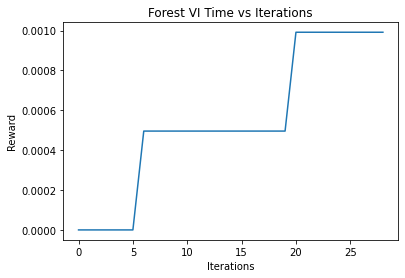

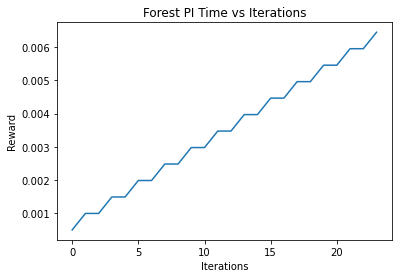

----------------------------------------


epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


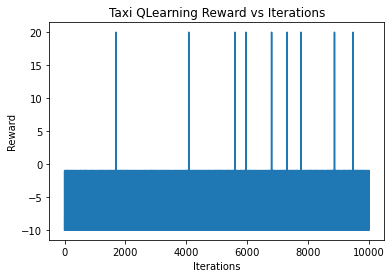

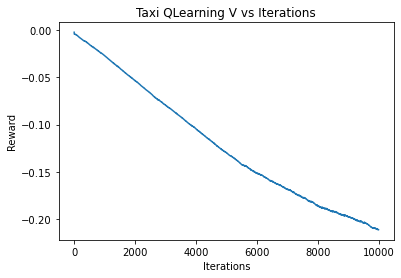

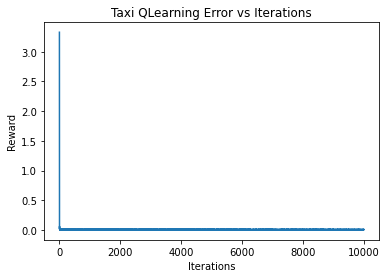

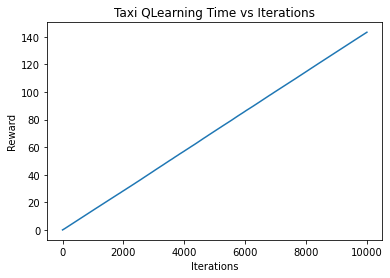

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


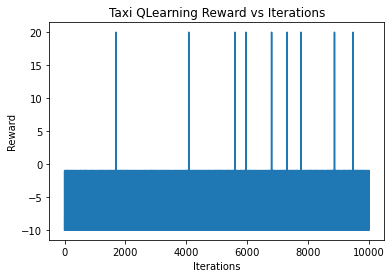

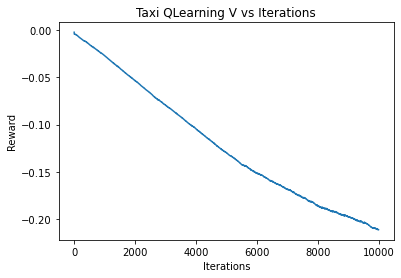

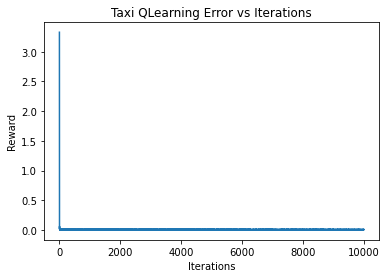

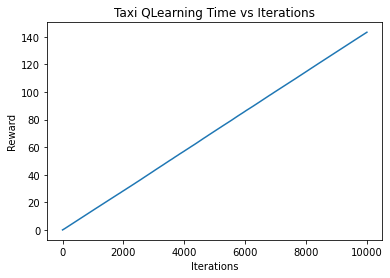

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


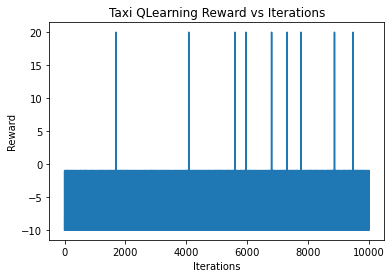

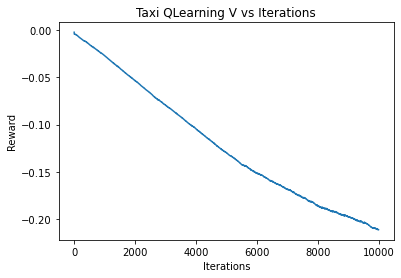

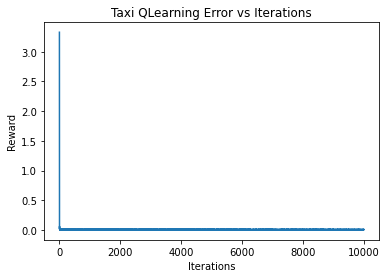

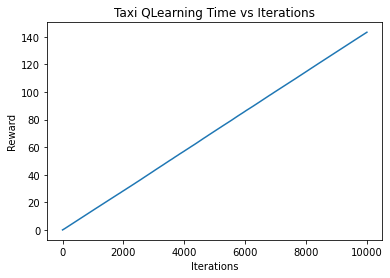

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


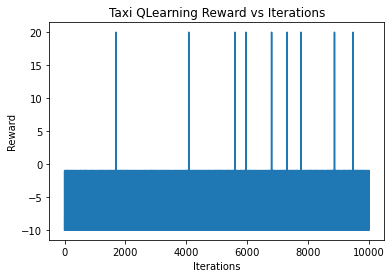

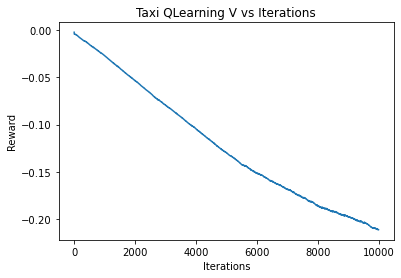

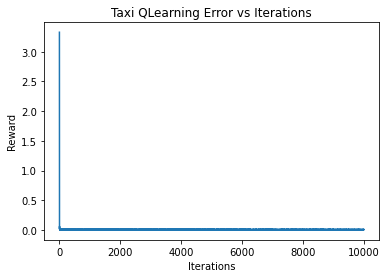

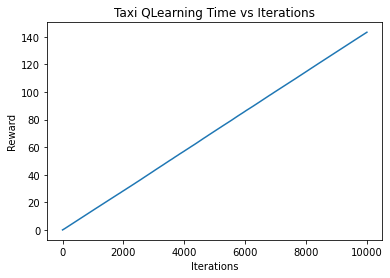

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


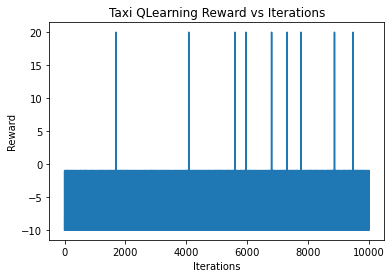

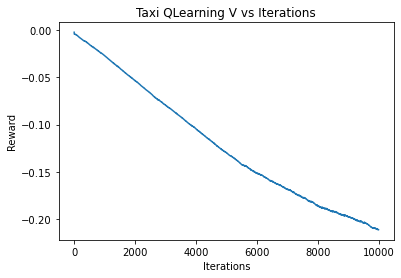

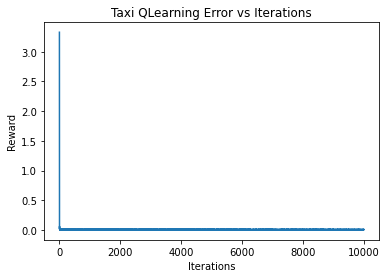

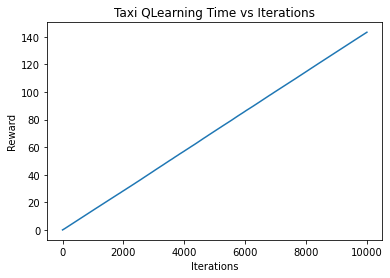

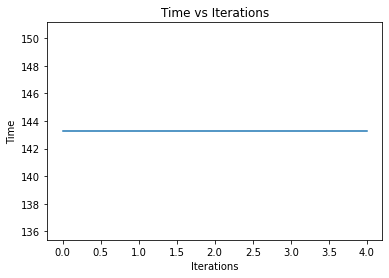

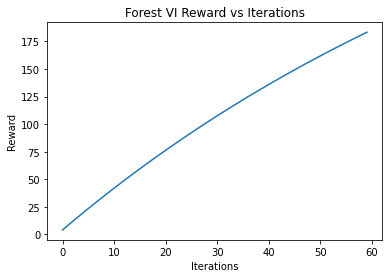

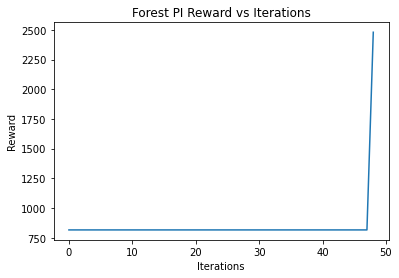

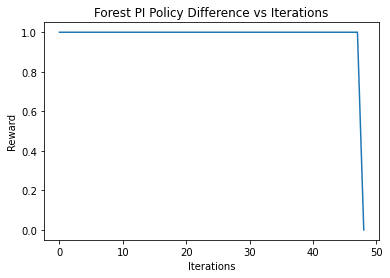

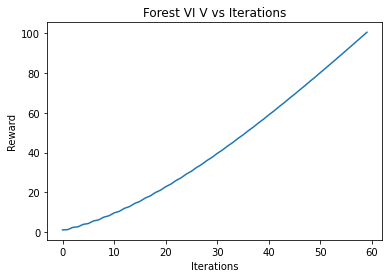

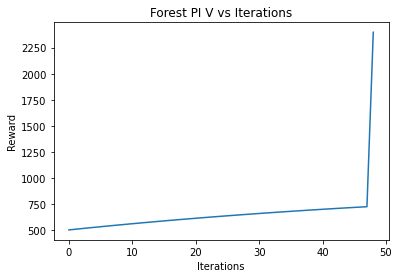

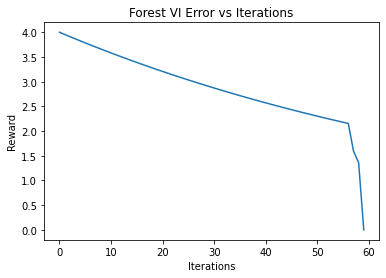

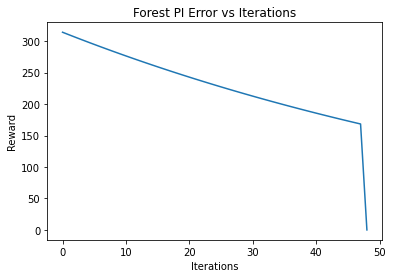

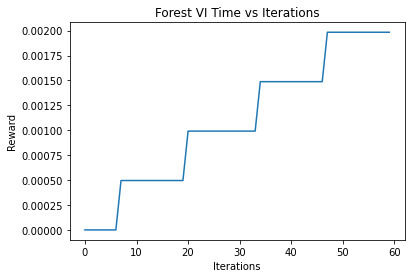

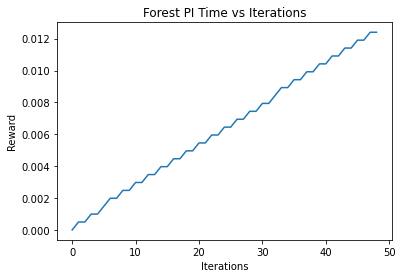

----------------------------------------


epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


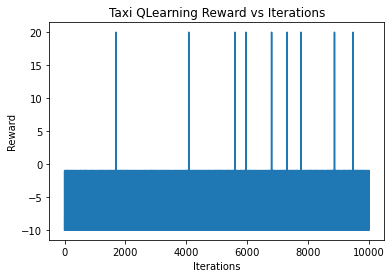

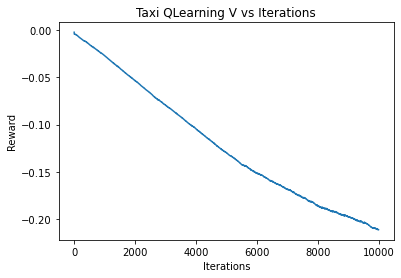

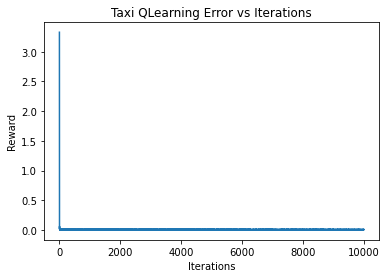

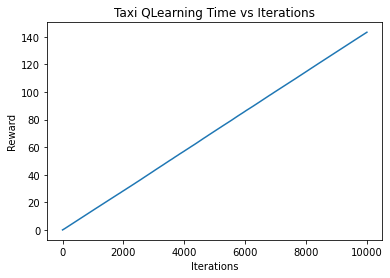

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


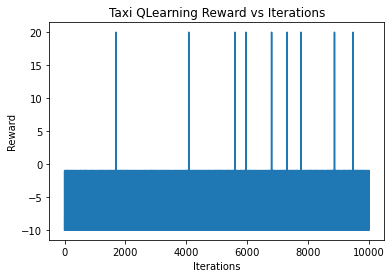

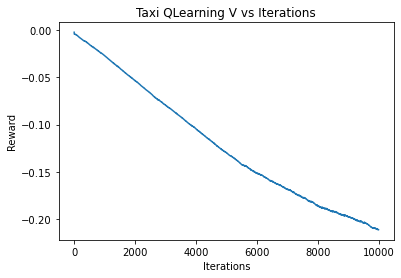

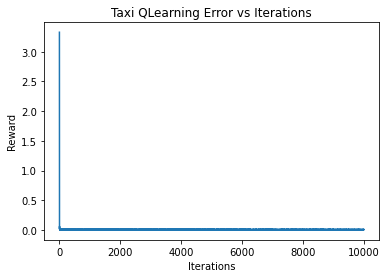

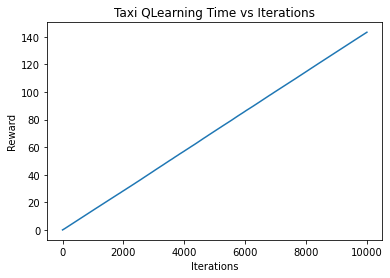

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


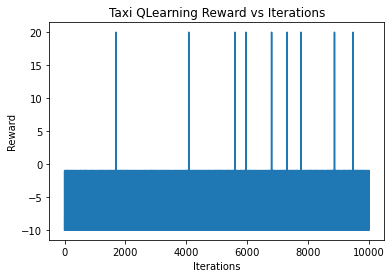

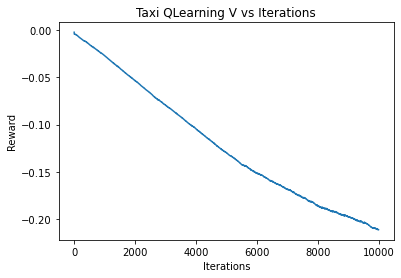

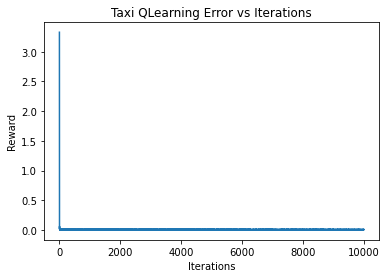

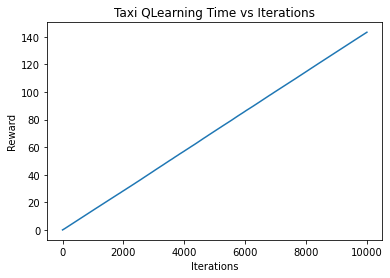

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


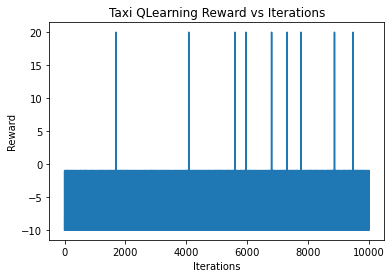

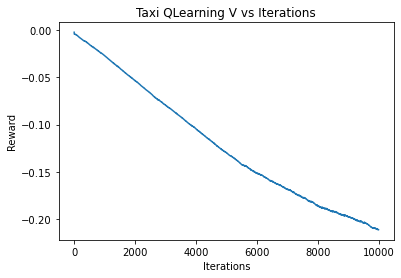

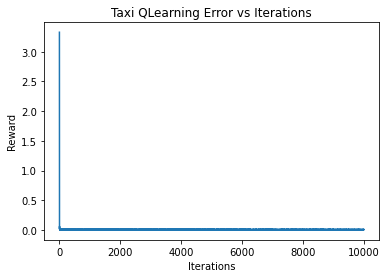

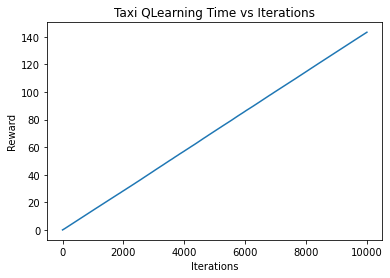

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


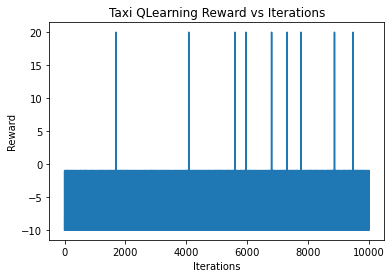

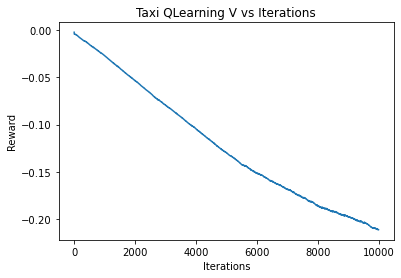

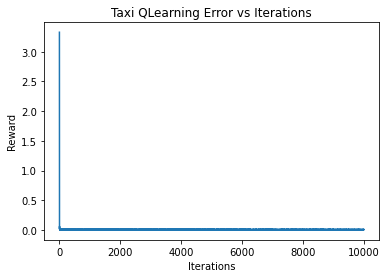

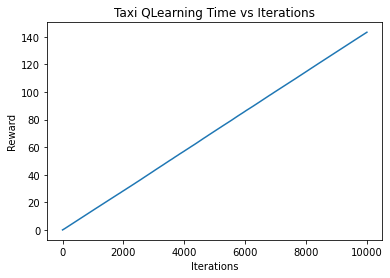

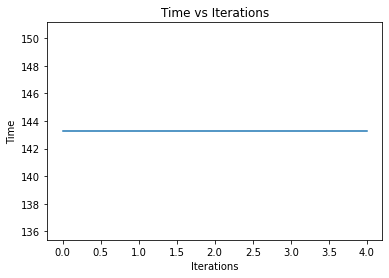

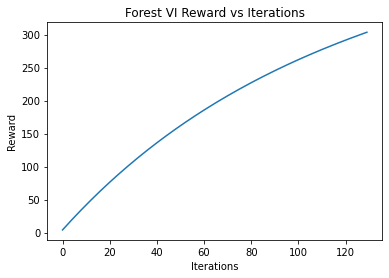

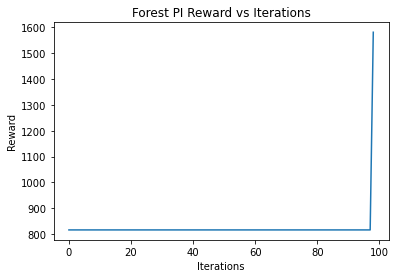

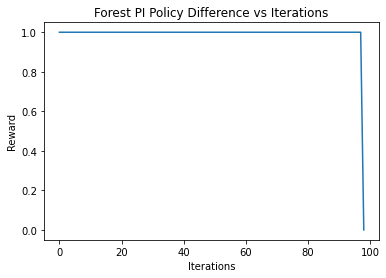

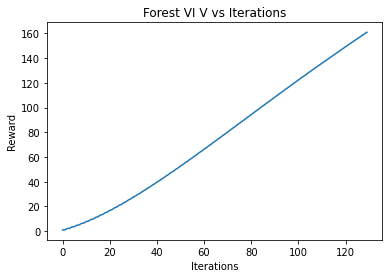

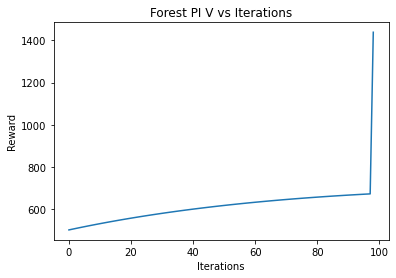

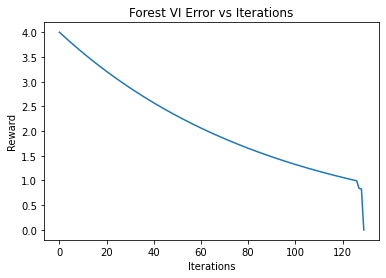

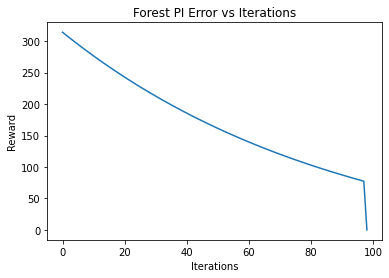

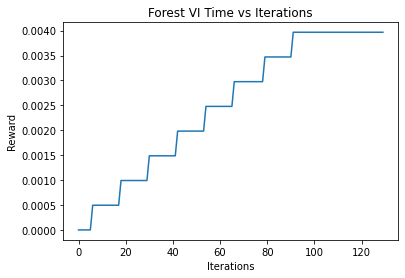

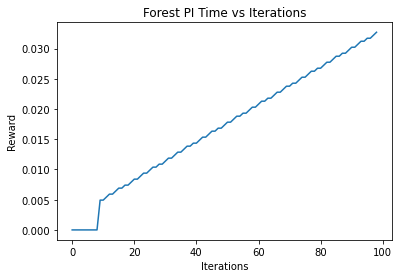

----------------------------------------


epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


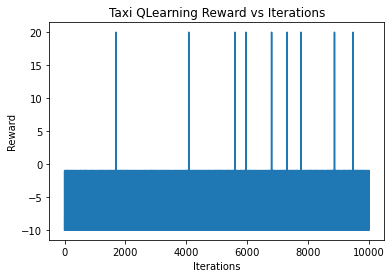

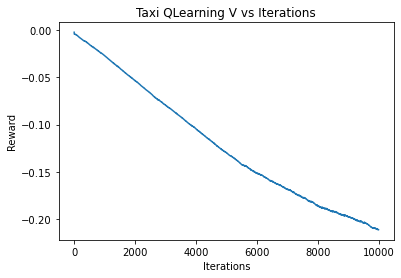

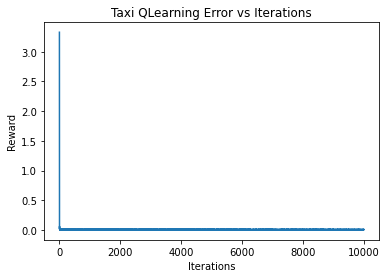

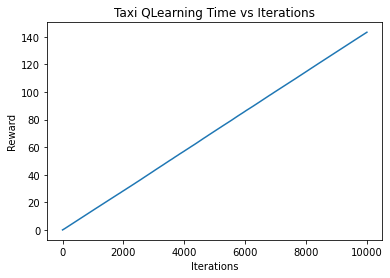

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


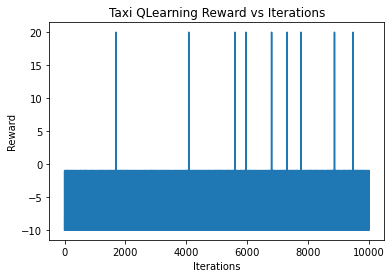

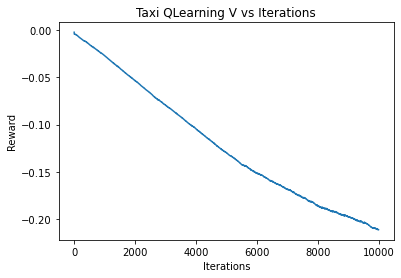

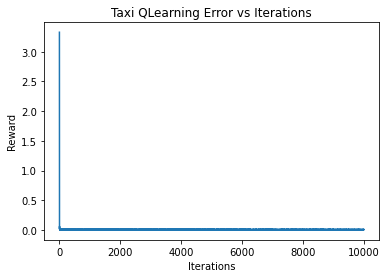

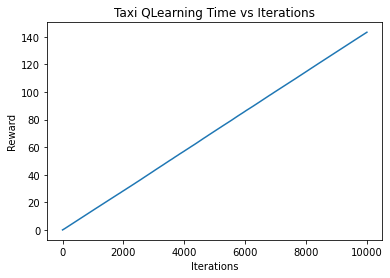

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


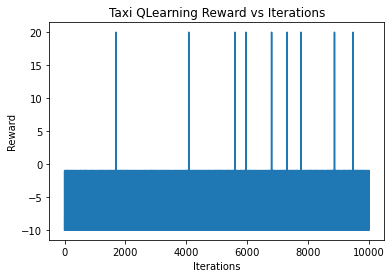

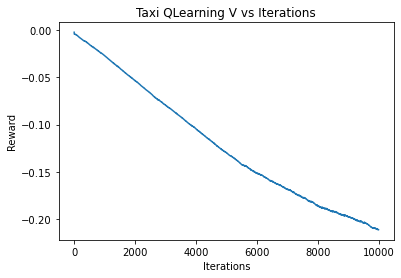

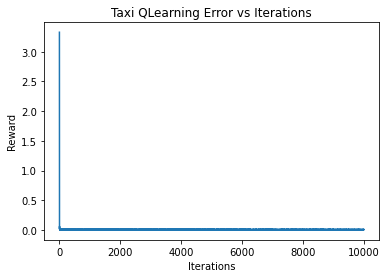

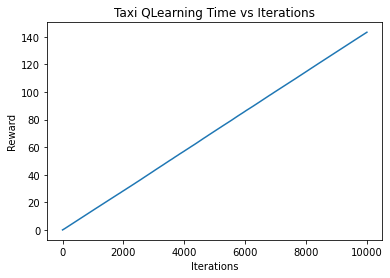

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


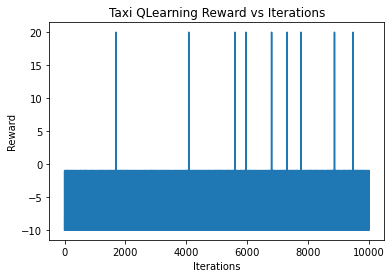

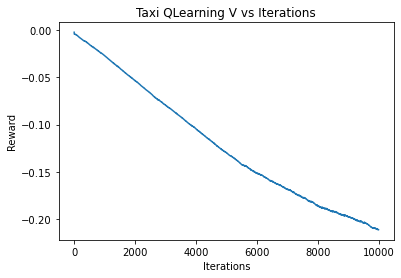

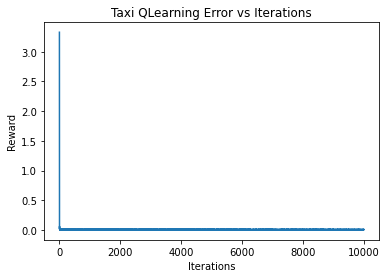

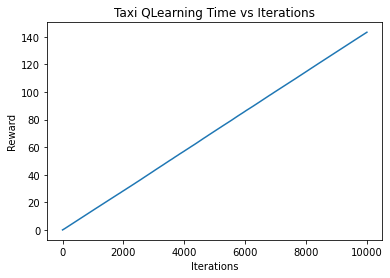

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


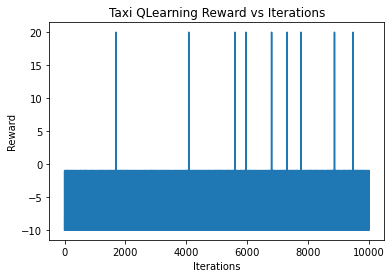

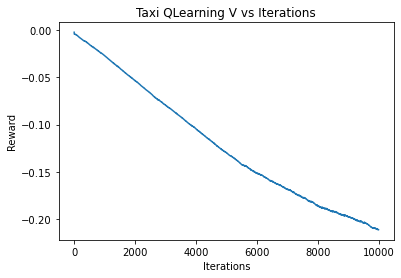

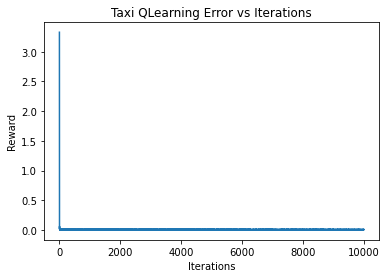

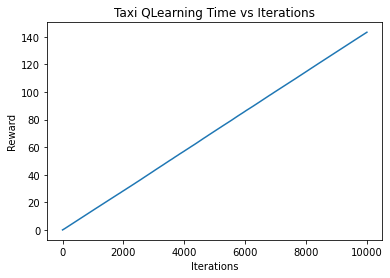

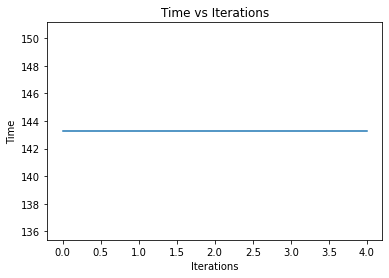

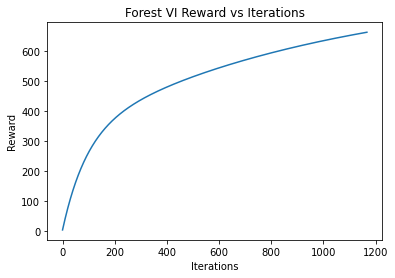

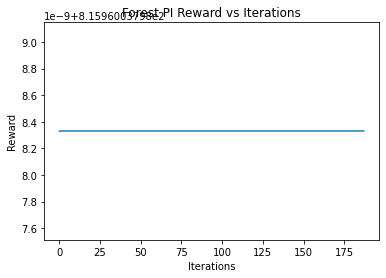

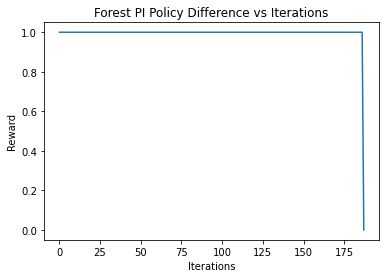

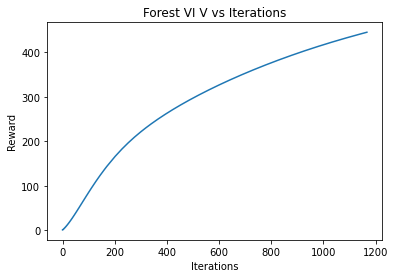

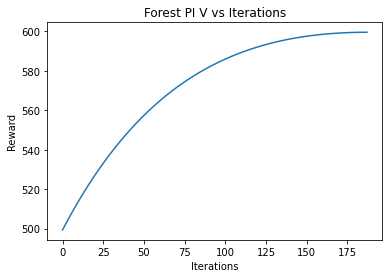

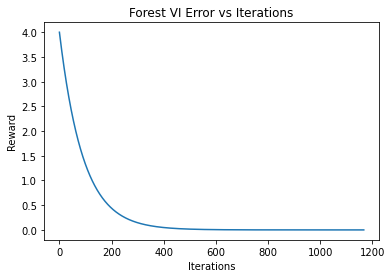

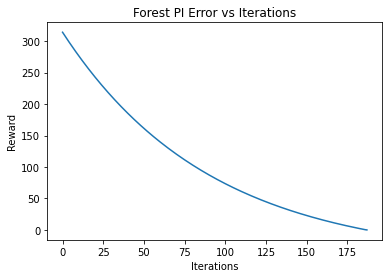

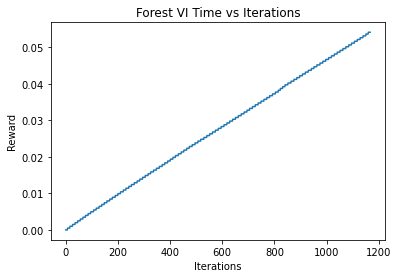

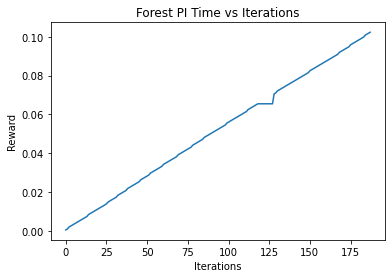

----------------------------------------




In [11]:
size = [25, 50, 100, 200]
for s in size:
    P, R = mdptoolbox.example.forest(S=s, p=0.01)

    value_iteration_forest = mdptoolbox.mdp.ValueIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.999)
    value_iteration_forest_stats = value_iteration_forest.run()
    value_iteration_forest_policy = np.array(value_iteration_forest.policy)#.reshape(nrow, ncol)

    policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.999)
    policy_iteration_forest_stats = policy_iteration_forest.run()
    policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

    iters_list = [500000, 750000, 1000000, 1500000, 2000000]
    time_taken = []
    for n in iters_list:
        q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                              gamma=.999, n_iter=n, alpha=.9, alpha_decay=.99, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
                                              #,
                                              # epsilon=.1, alpha=.2,
                                              # epsilon_decay=.1, alpha_decay=.1,
                                              # epsilon_min=.01
                                              )
        q_learning_forest_stats = q_learning_forest.run()
        plot_q_learning(q_learning_stats, 'Taxi QLearning', 'Reward')
        plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'V')
        plot_learning(q_learning_stats, 'Taxi QLearning', 'Error')
        plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')
        time_taken.append(q_learning.time)
    plot_q_learning_timetaken(time_taken)

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    # plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

    plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
    plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
                         'V')
    # plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')


    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()


epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


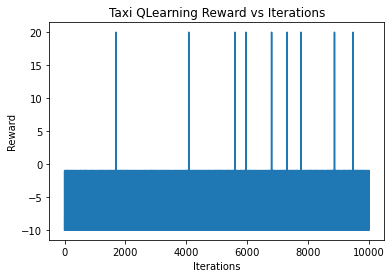

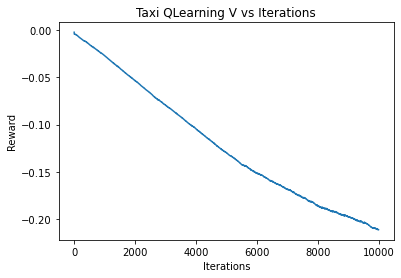

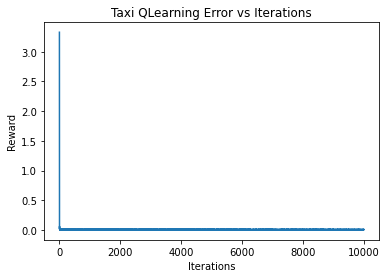

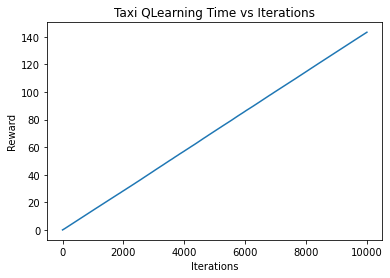

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


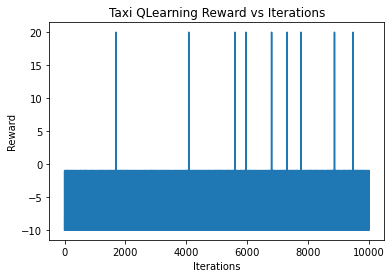

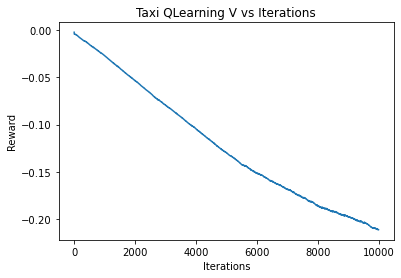

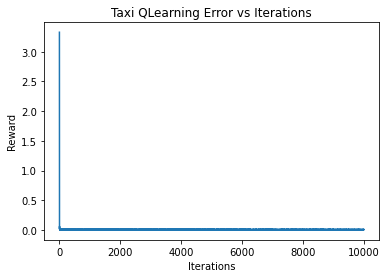

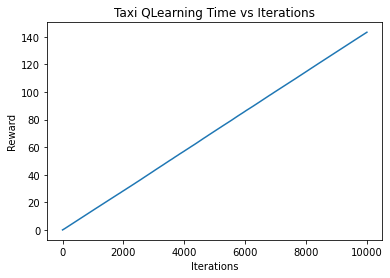

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


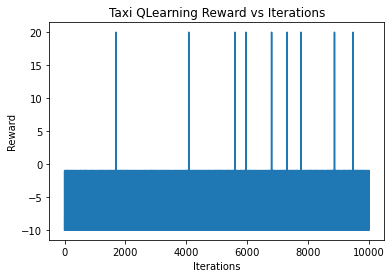

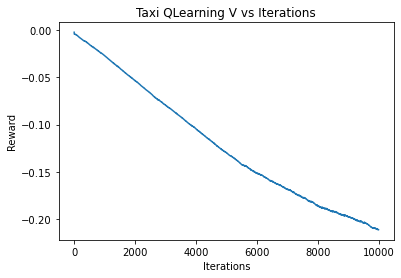

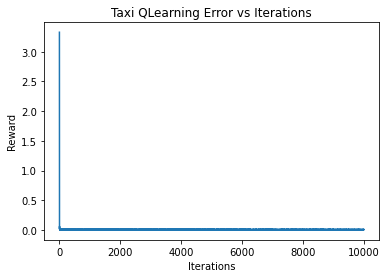

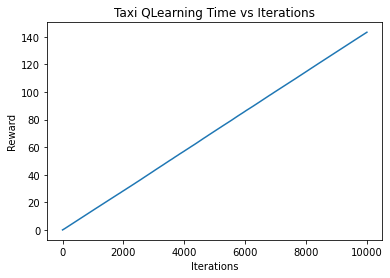

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


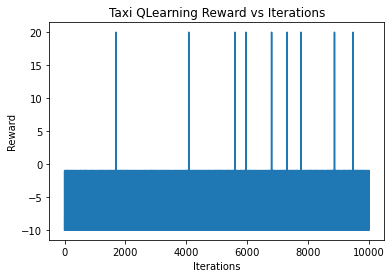

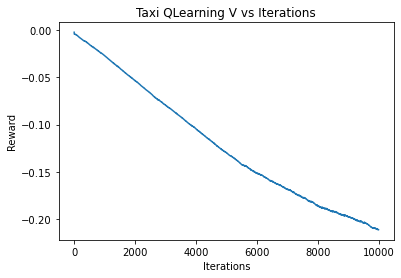

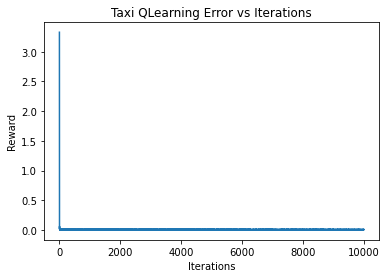

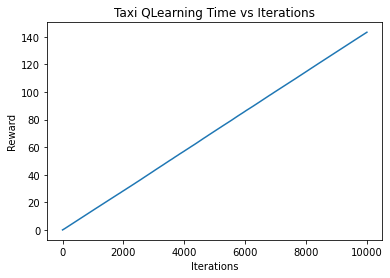

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


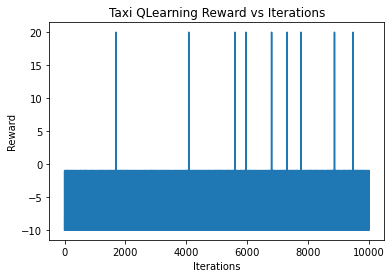

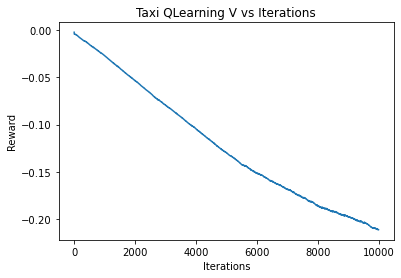

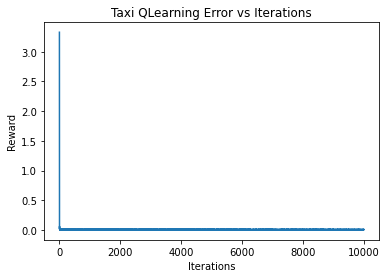

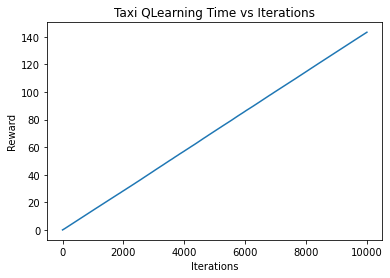

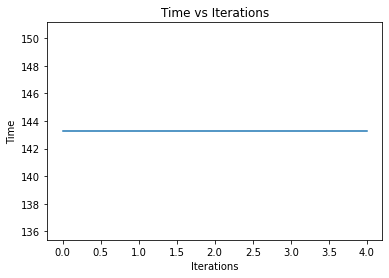

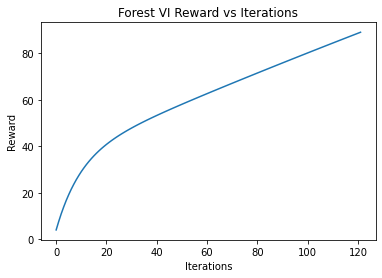

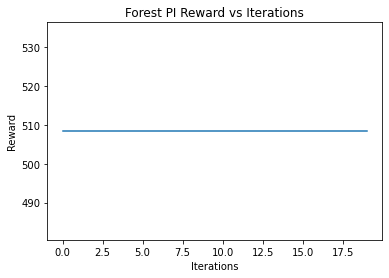

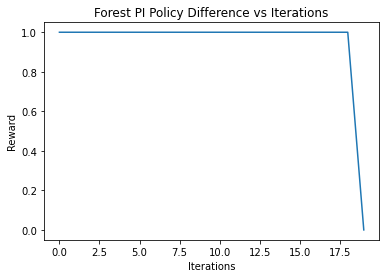

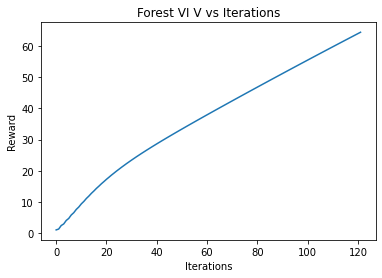

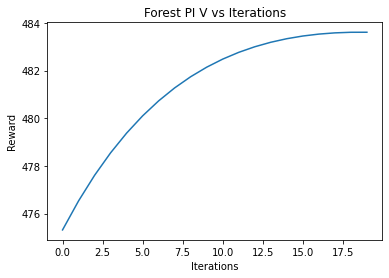

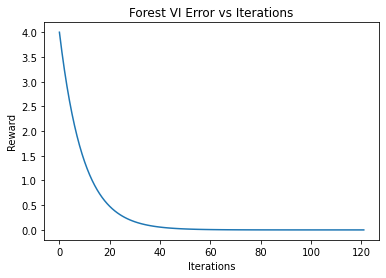

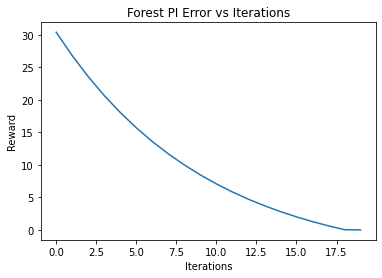

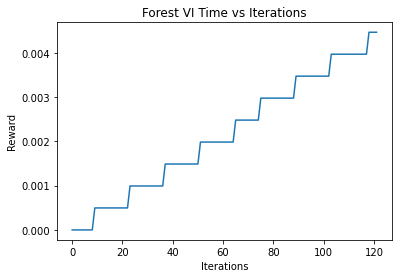

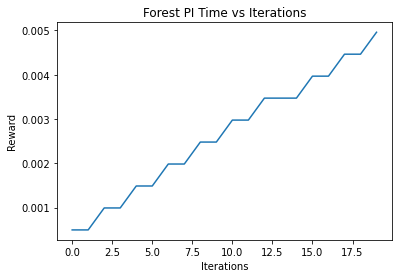

----------------------------------------


epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


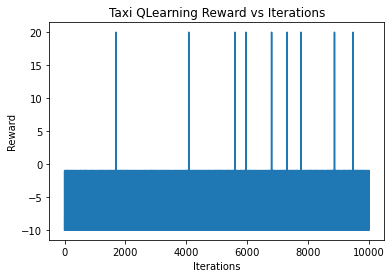

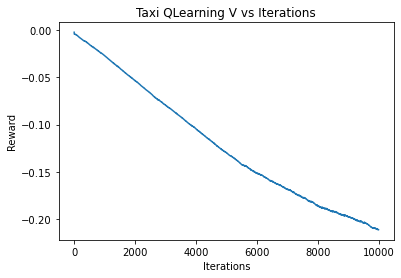

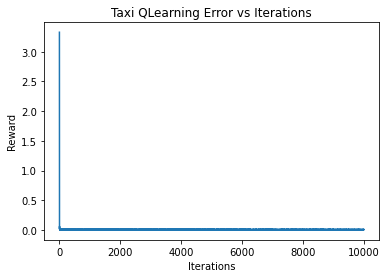

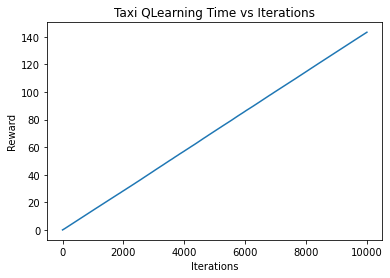

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


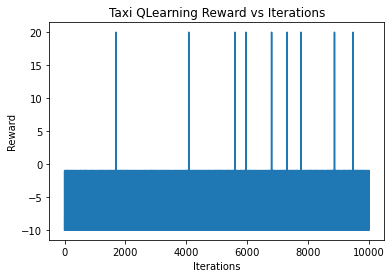

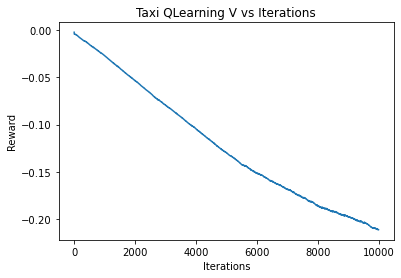

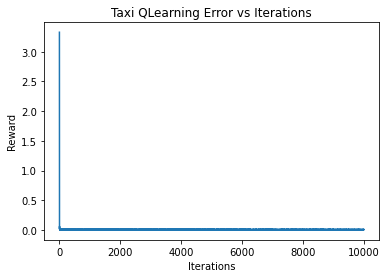

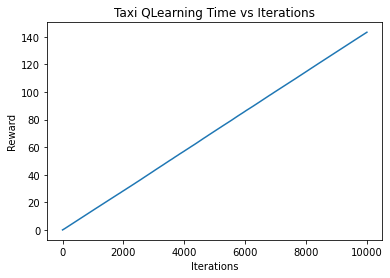

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


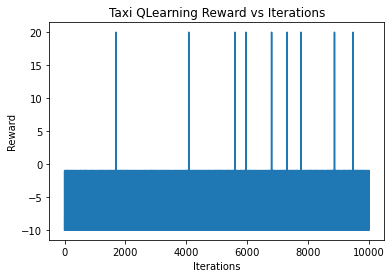

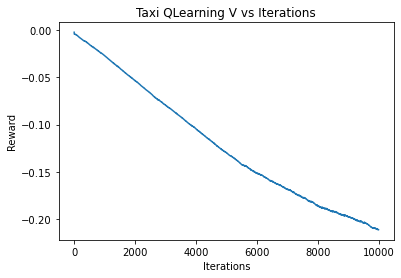

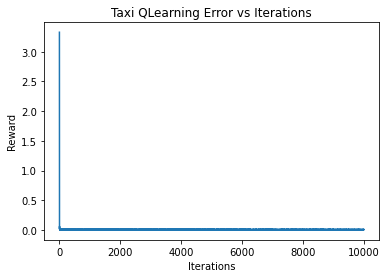

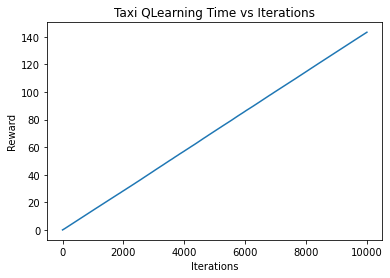

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


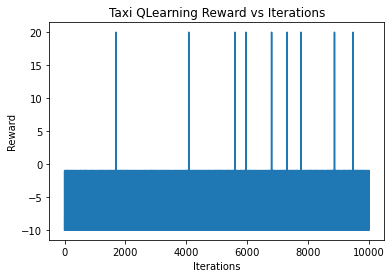

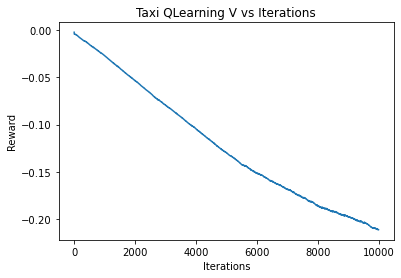

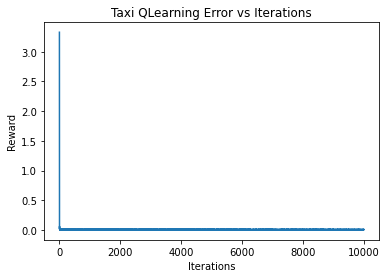

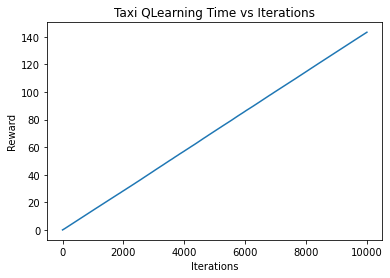

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


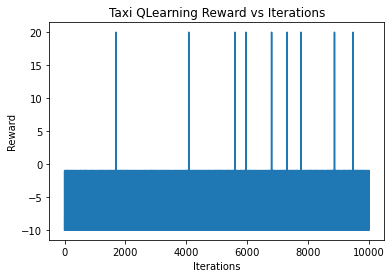

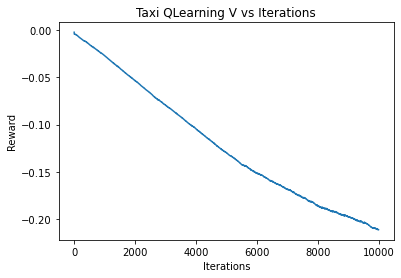

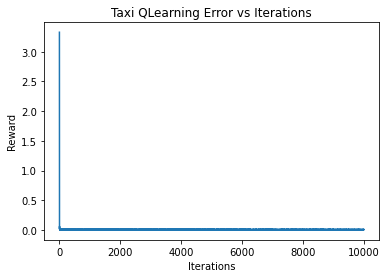

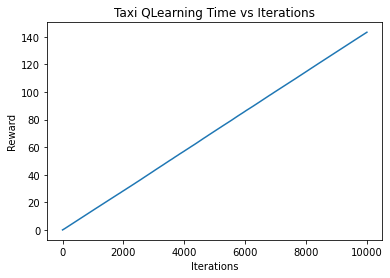

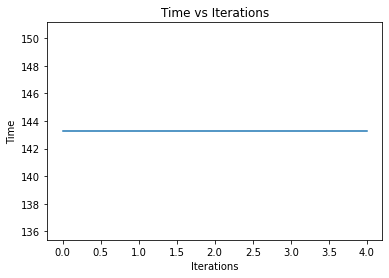

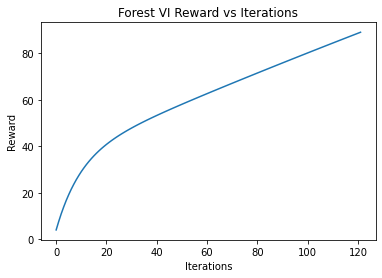

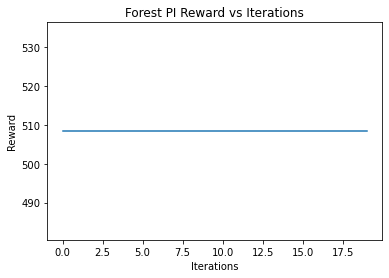

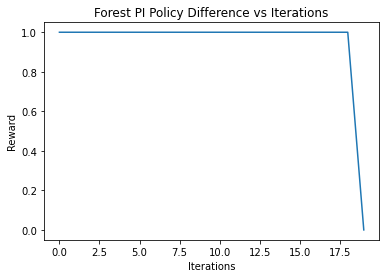

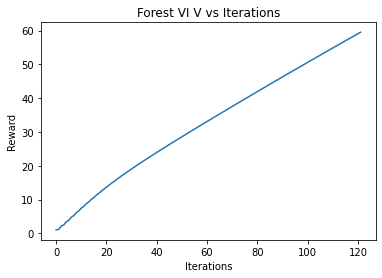

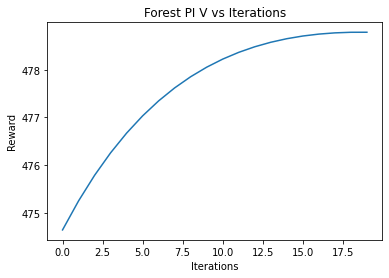

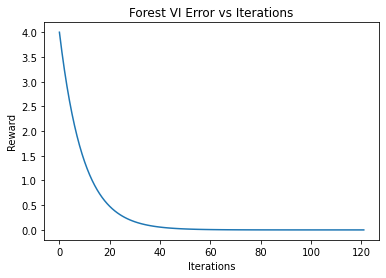

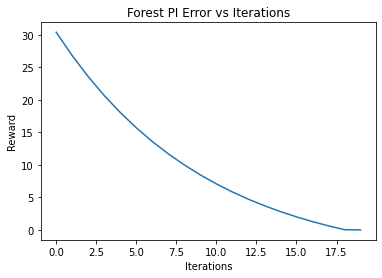

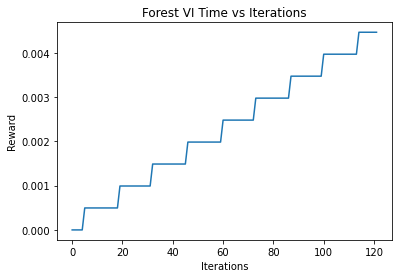

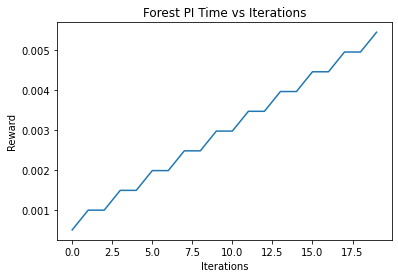

----------------------------------------


epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


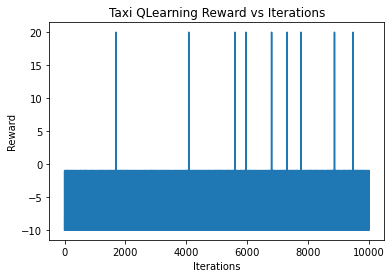

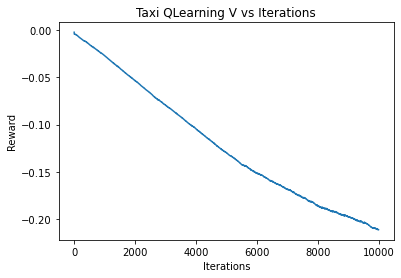

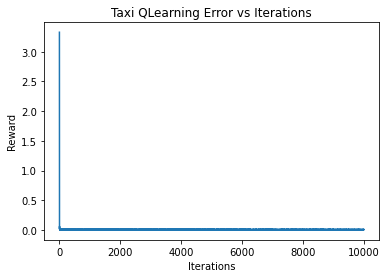

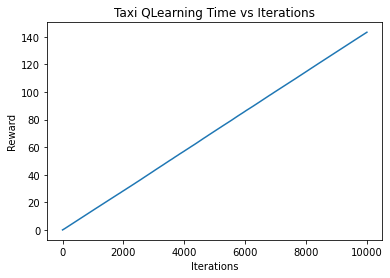

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


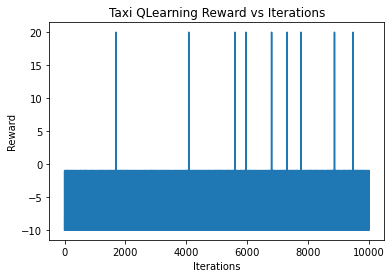

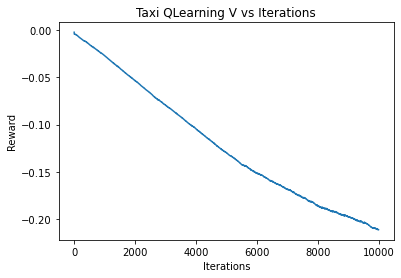

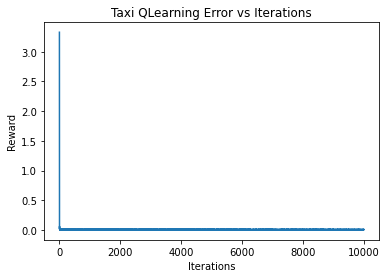

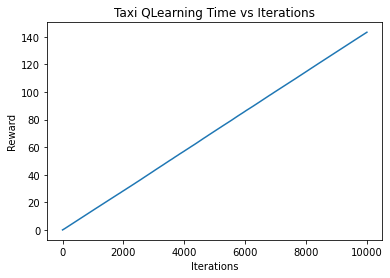

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


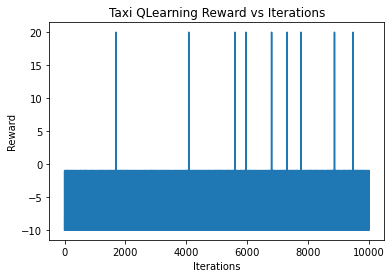

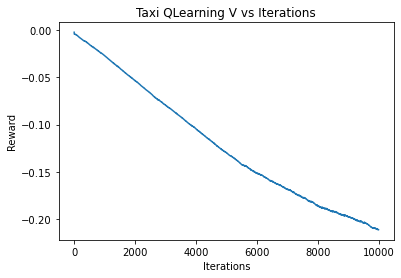

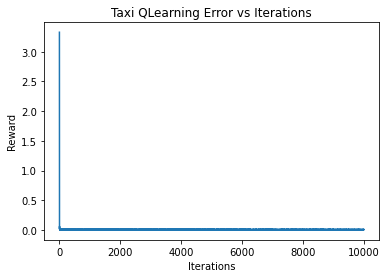

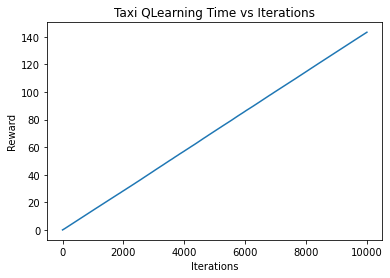

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


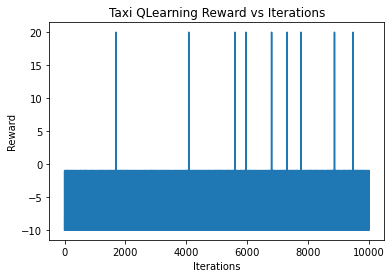

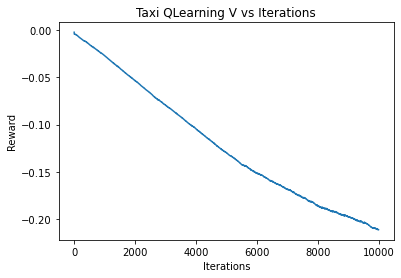

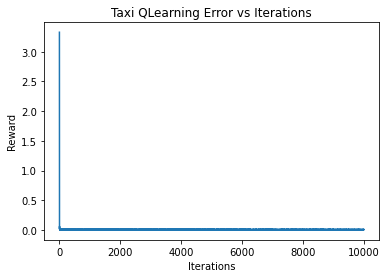

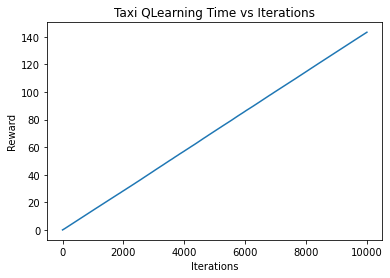

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


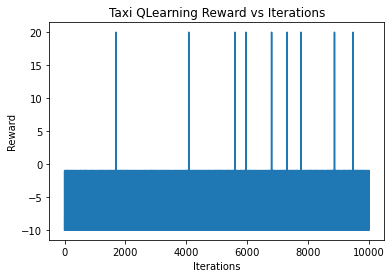

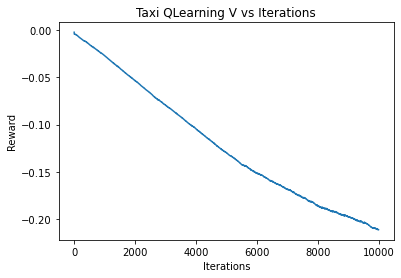

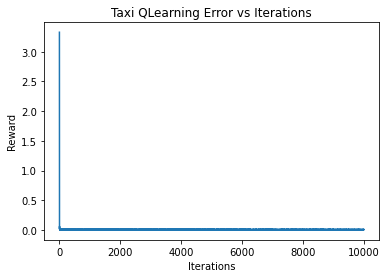

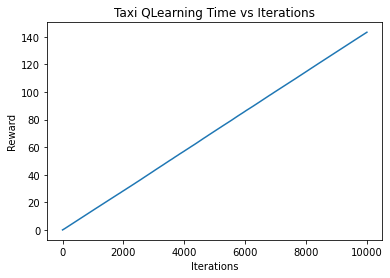

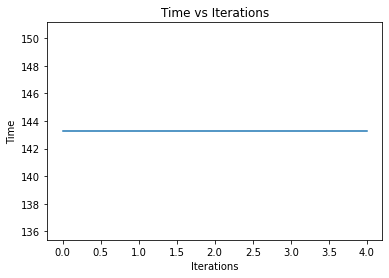

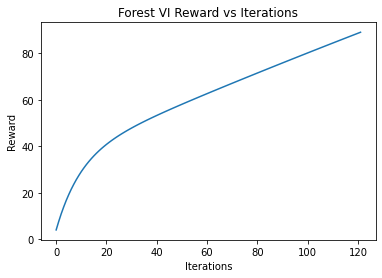

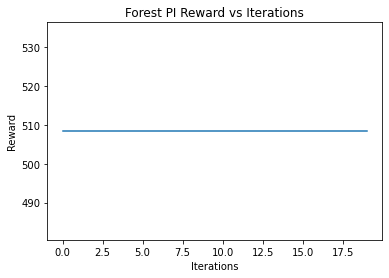

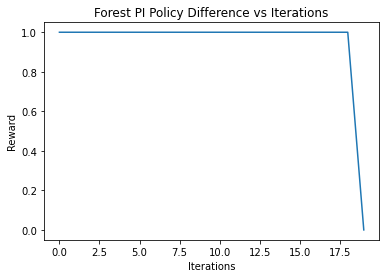

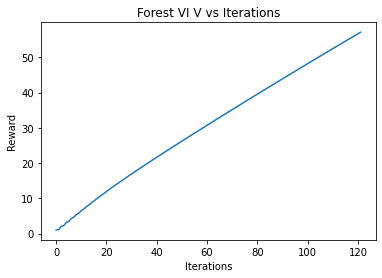

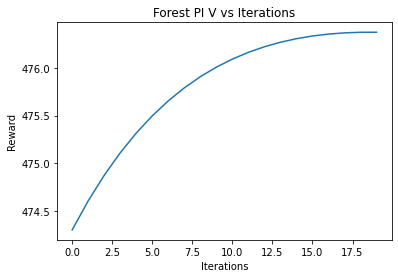

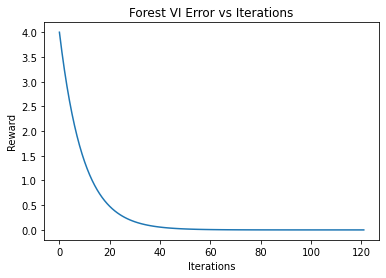

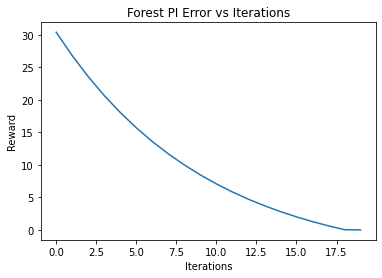

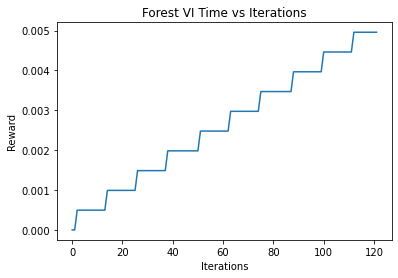

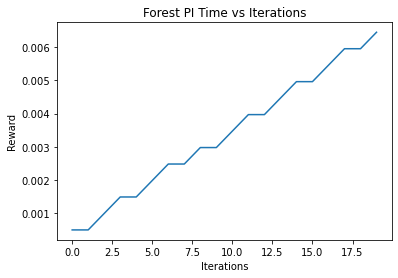

----------------------------------------


epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


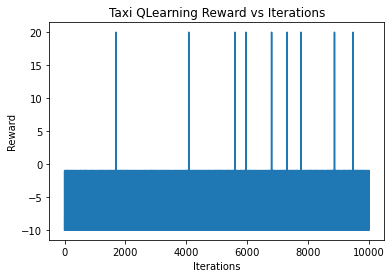

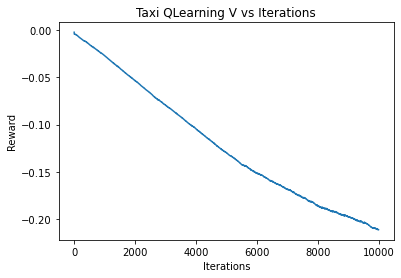

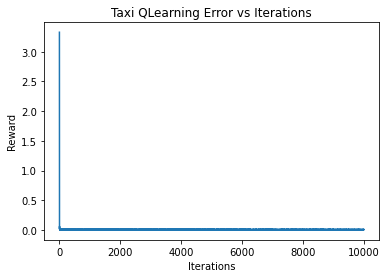

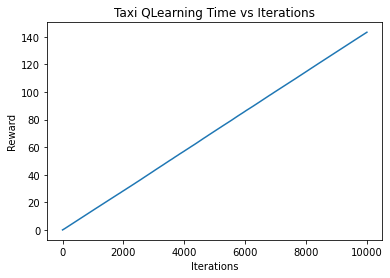

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


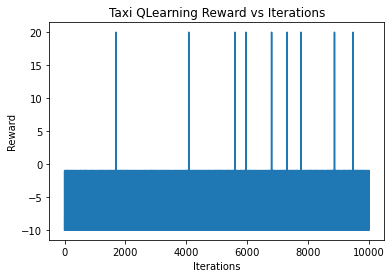

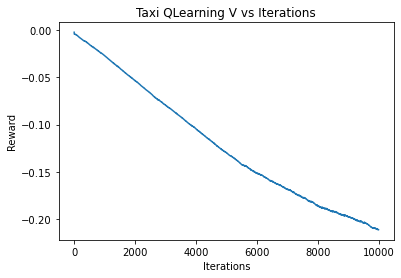

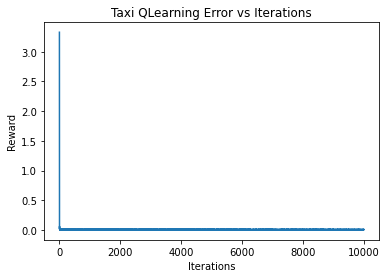

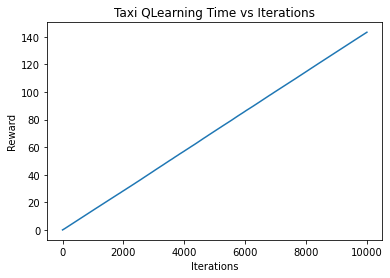

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


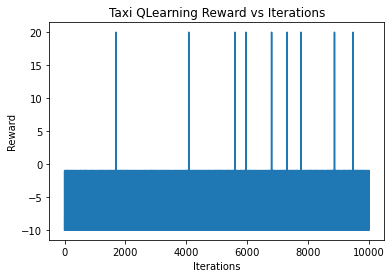

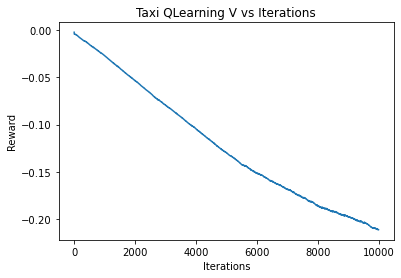

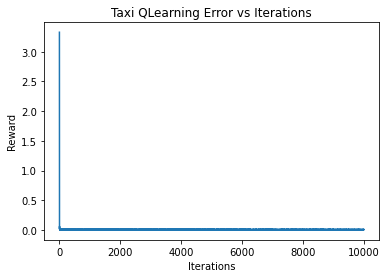

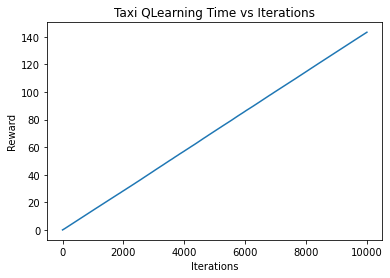

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


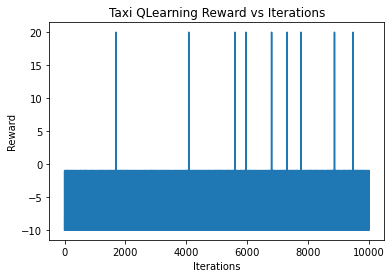

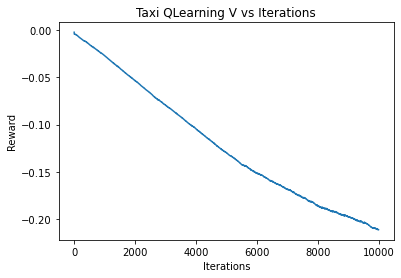

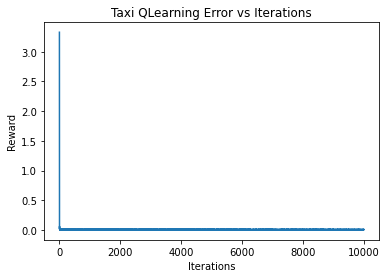

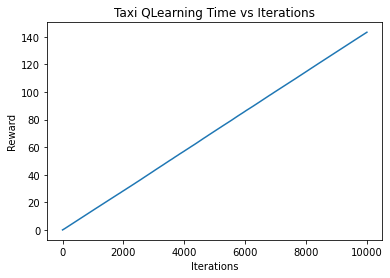

epsilon before loop:  1.0
epsilon:  0.1
-10.0
20.0


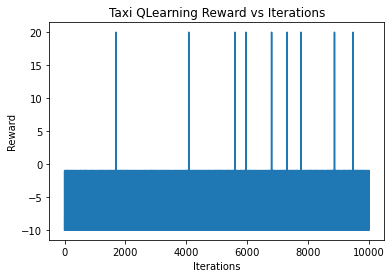

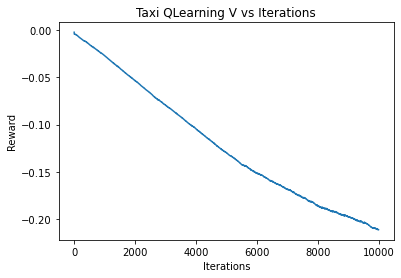

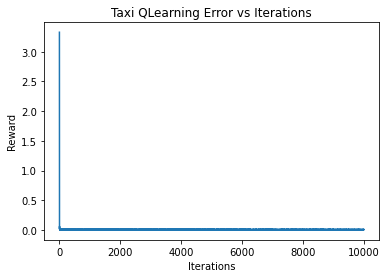

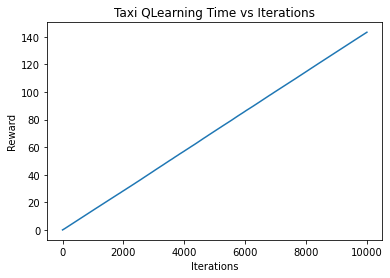

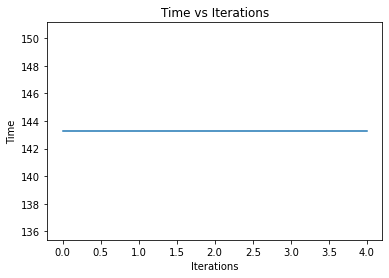

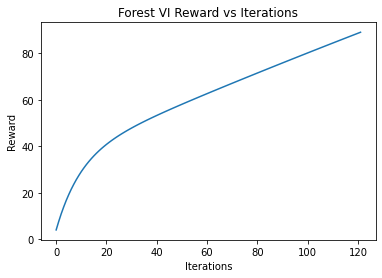

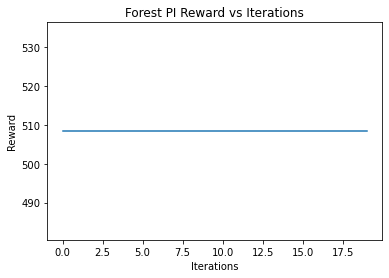

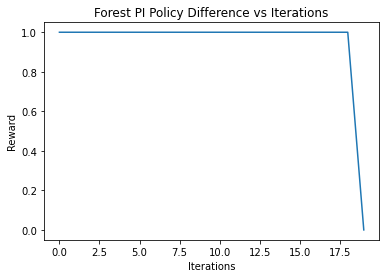

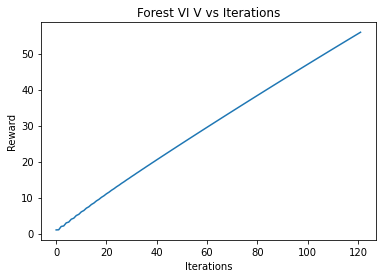

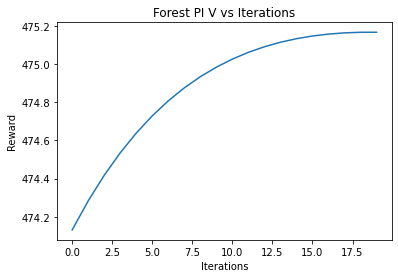

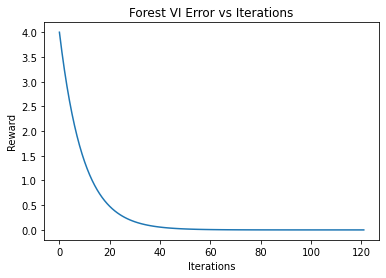

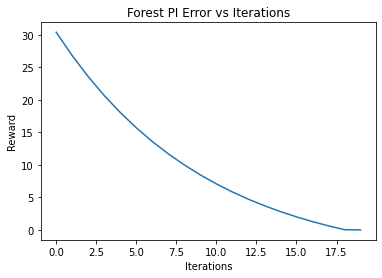

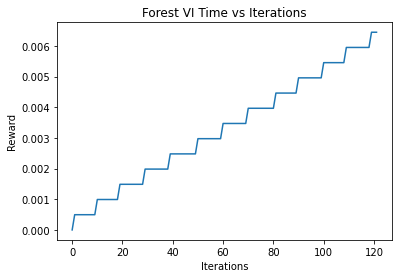

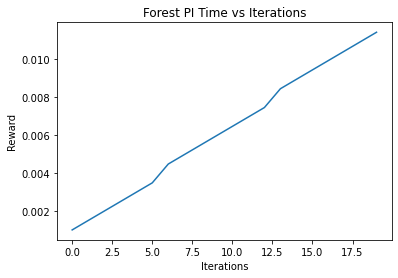

----------------------------------------




In [12]:
size = [25, 50, 100, 200]
for s in size:
    P, R = mdptoolbox.example.forest(S=s, p=0.1)

    value_iteration_forest = mdptoolbox.mdp.ValueIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.999)
    value_iteration_forest_stats = value_iteration_forest.run()
    value_iteration_forest_policy = np.array(value_iteration_forest.policy)#.reshape(nrow, ncol)

    policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.999)
    policy_iteration_forest_stats = policy_iteration_forest.run()
    policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

    iters_list = [500000, 750000, 1000000, 1500000, 2000000]
    time_taken = []
    for n in iters_list:
        q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                              gamma=.999, n_iter=n, alpha=.9, alpha_decay=.99, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
                                              #,
                                              # epsilon=.1, alpha=.2,
                                              # epsilon_decay=.1, alpha_decay=.1,
                                              # epsilon_min=.01
                                              )
        q_learning_forest_stats = q_learning_forest.run()
        plot_q_learning(q_learning_stats, 'Taxi QLearning', 'Reward')
        plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'V')
        plot_learning(q_learning_stats, 'Taxi QLearning', 'Error')
        plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')
        time_taken.append(q_learning.time)
    plot_q_learning_timetaken(time_taken)

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    # plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

    plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
    plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
                         'V')
    # plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')


    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()

In [ ]:
size = [25, 50, 100, 200]
for s in size:
    P, R = mdptoolbox.example.forest(S=s, p=0.01)

    value_iteration_forest = mdptoolbox.mdp.ValueIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.999)
    value_iteration_forest_stats = value_iteration_forest.run()
    value_iteration_forest_policy = np.array(value_iteration_forest.policy)#.reshape(nrow, ncol)

    policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.999)
    policy_iteration_forest_stats = policy_iteration_forest.run()
    policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

    iters_list = [500000, 750000, 1000000, 1500000, 2000000]
    time_taken = []
    for n in iters_list:
        q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                              gamma=.999, n_iter=n, alpha=.9, alpha_decay=.99, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
                                              #,
                                              # epsilon=.1, alpha=.2,
                                              # epsilon_decay=.1, alpha_decay=.1,
                                              # epsilon_min=.01
                                              )
        q_learning_forest_stats = q_learning_forest.run()
        plot_q_learning(q_learning_stats, 'Taxi QLearning', 'Reward')
        plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'V')
        plot_learning(q_learning_stats, 'Taxi QLearning', 'Error')
        plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')
        time_taken.append(q_learning.time)
    plot_q_learning_timetaken(time_taken)

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    # plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

    plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
    plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
                         'V')
    # plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')


    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()

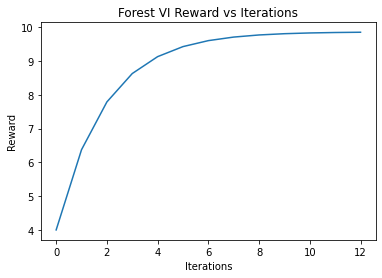

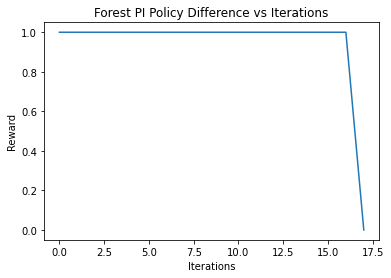

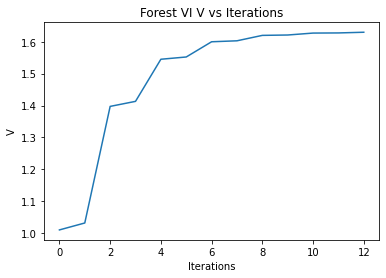

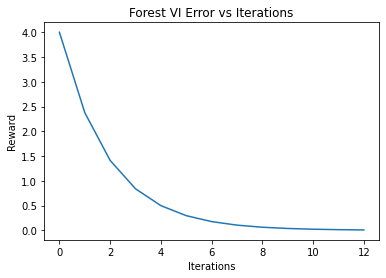

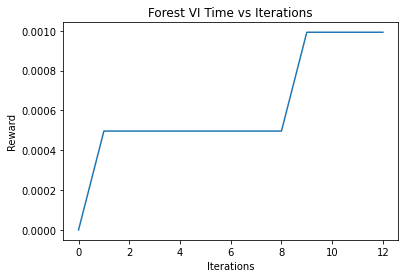

----------------------------------------




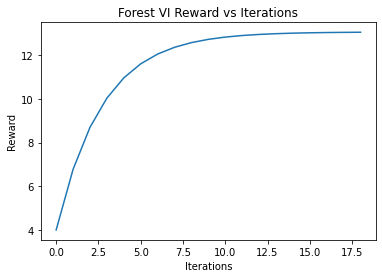

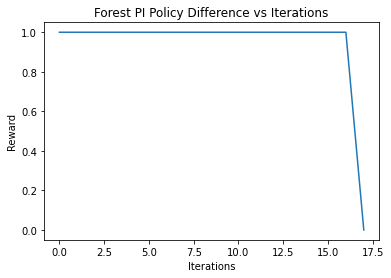

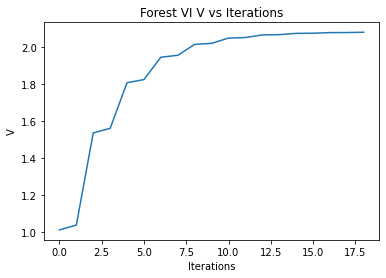

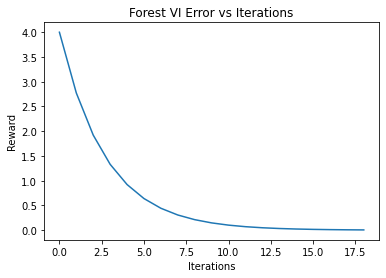

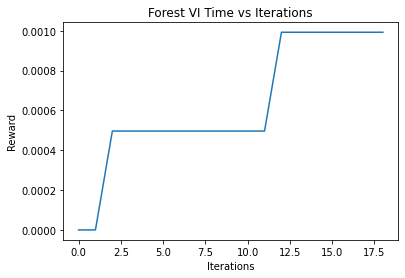

----------------------------------------




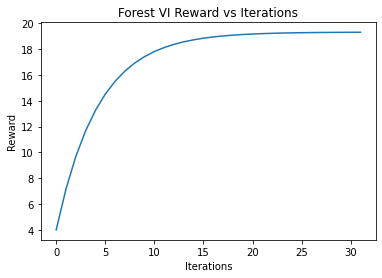

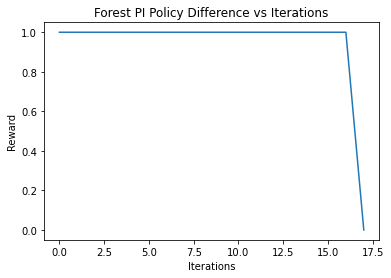

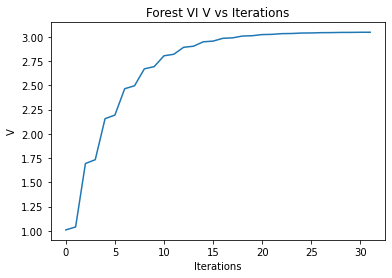

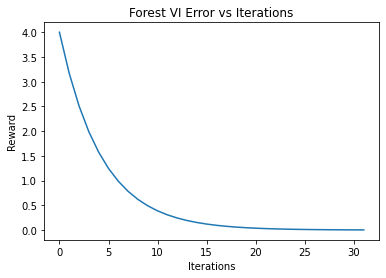

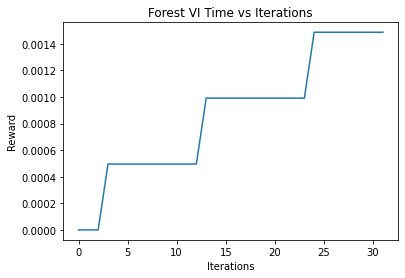

----------------------------------------




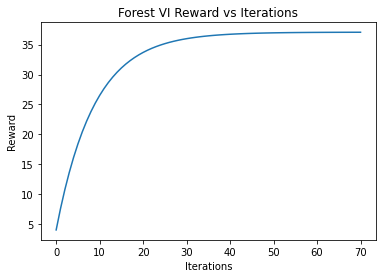

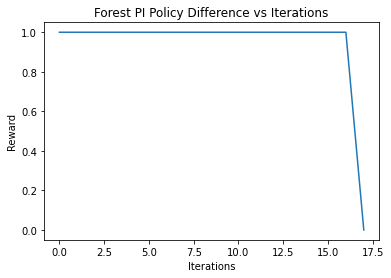

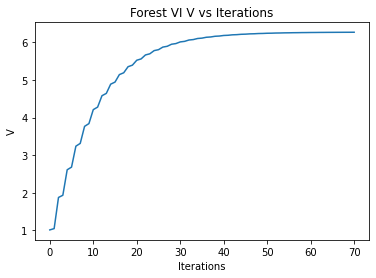

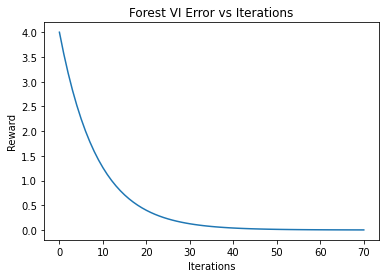

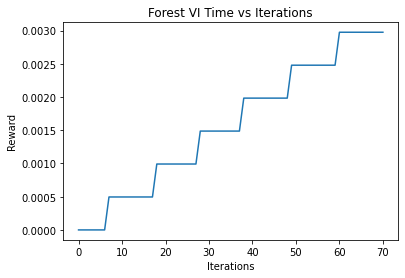

----------------------------------------




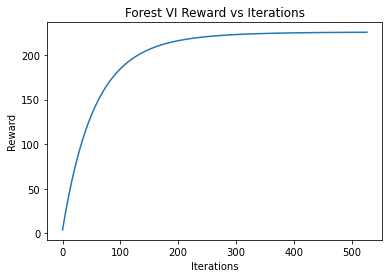

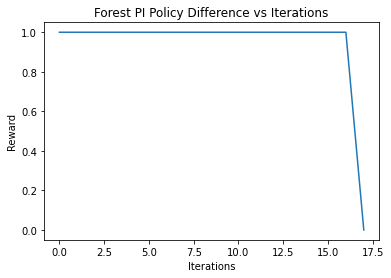

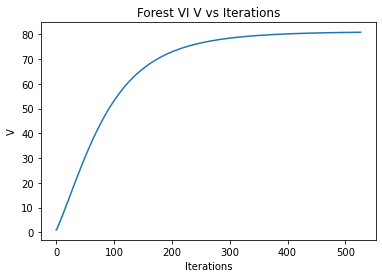

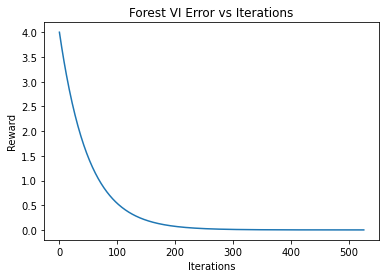

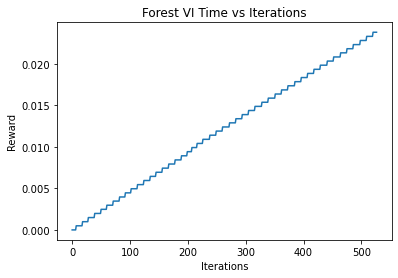

----------------------------------------




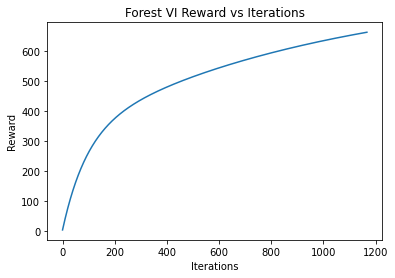

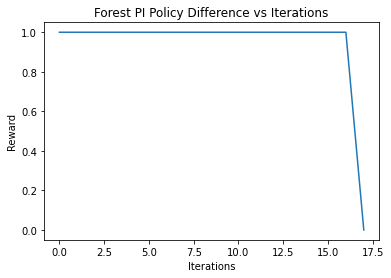

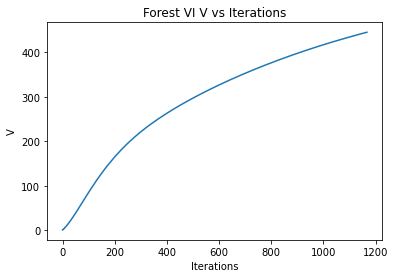

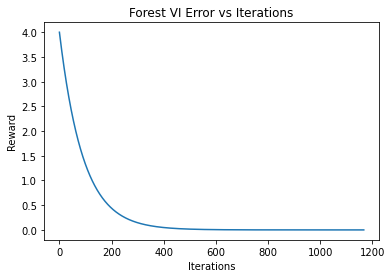

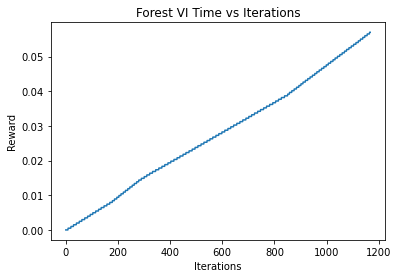

----------------------------------------




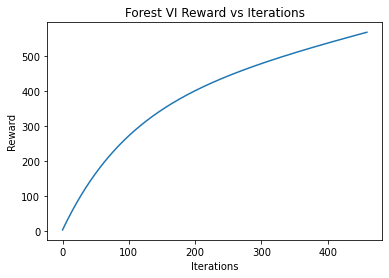

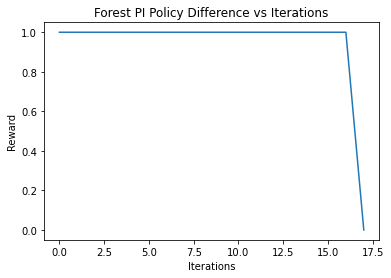

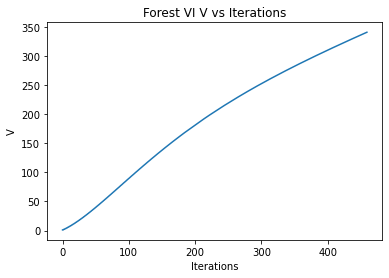

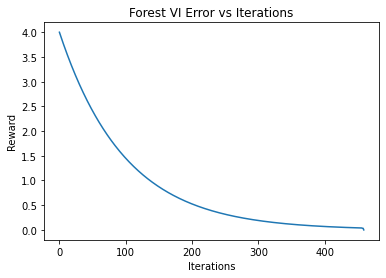

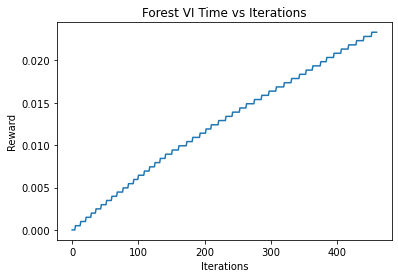

----------------------------------------




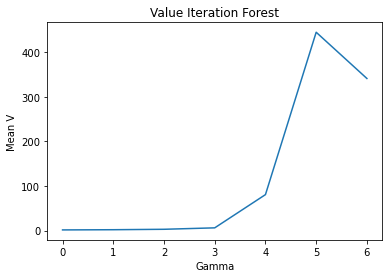

In [13]:
size = [.6, .7, .8, .9, .99, .999, .9999]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    
    value_iteration_forest = mdptoolbox.mdp.ValueIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=s)
    value_iteration_forest_stats = value_iteration_forest.run()
    value_iteration_forest_policy = np.array(value_iteration_forest.policy)#.reshape(nrow, ncol)

#     policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
#                                         reward=np.asarray(R),
#                                         gamma=s)
#     policy_iteration_forest_stats = policy_iteration_forest.run()
#     policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

#     q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
#                                           gamma=s, n_iter=150000, alpha=.9, alpha_decay=.99, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
#                                           #,
#                                           # epsilon=.1, alpha=.2,
#                                           # epsilon_decay=.1, alpha_decay=.1,
#                                           # epsilon_min=.01
#                                           )
#     q_learning_forest_stats = q_learning_forest.run()
#     plot_q_learning(q_learning_forest_stats, 'Taxi QLearning', 'Reward')
#     plot_mean_v_learning(q_learning_forest_stats, 'Taxi QLearning', 'V')
#     plot_learning(q_learning_forest_stats, 'Taxi QLearning', 'Error')
#     plot_learning(q_learning_forest_stats, 'Taxi QLearning', 'Time')
#     time_taken.append(q_learning.time)
#     plot_q_learning_timetaken(time_taken)

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    # plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

    plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
#     plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
#                          'V')
    # plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')


    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
    rewards_vi.append(value_iteration_forest_stats[-1]['Mean V'])
#     rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])
#     rewards_qlearning.append(q_learning_forest_stats[-1]['Mean V'])
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()
    
plot_gamma(rewards_vi, 'Value Iteration Forest')
# plot_gamma(rewards_pi, 'Policy Iteration Forest')
# plot_gamma(rewards_qlearning, 'QLearning Forest')

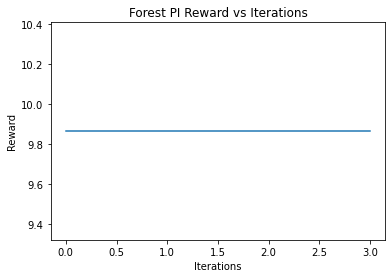

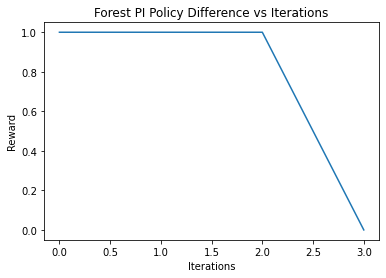

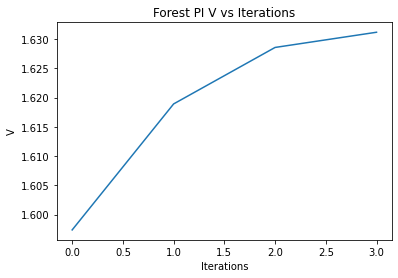

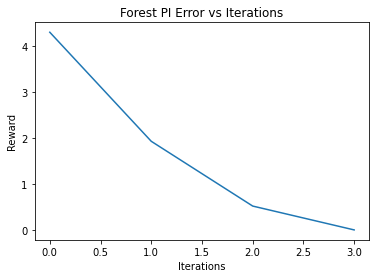

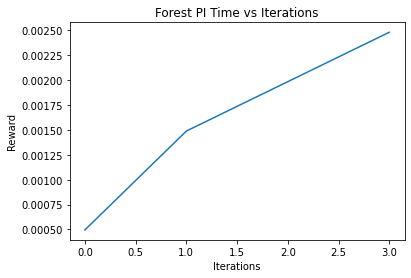

----------------------------------------




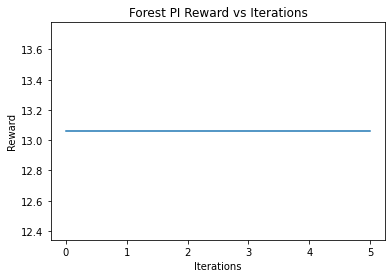

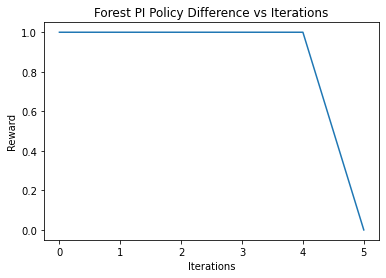

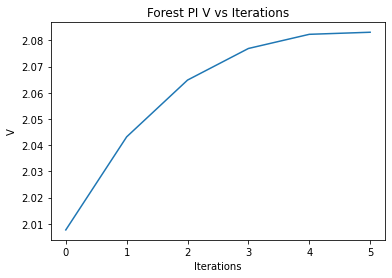

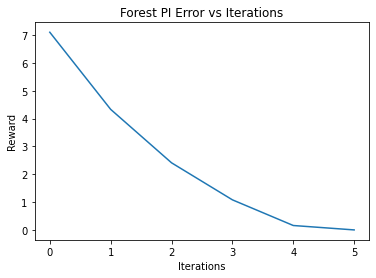

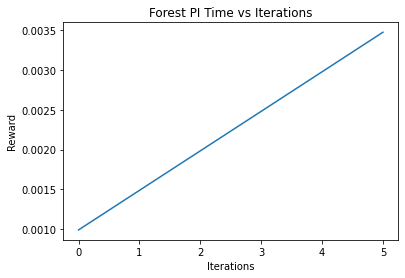

----------------------------------------




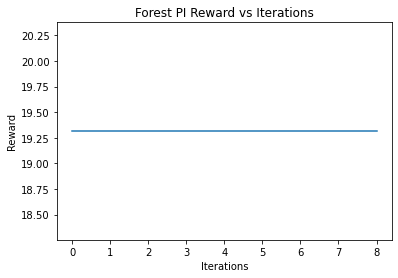

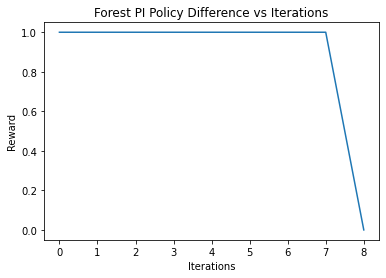

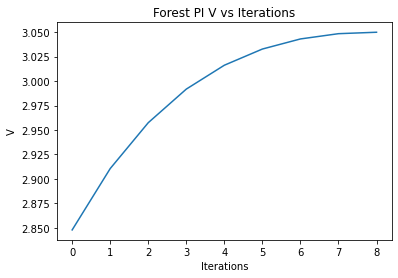

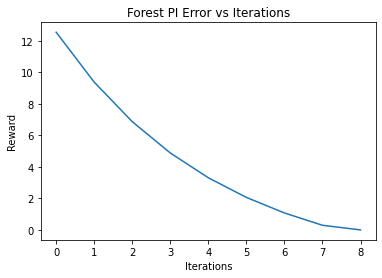

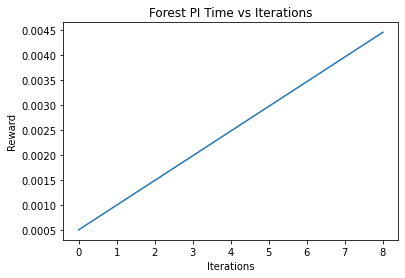

----------------------------------------




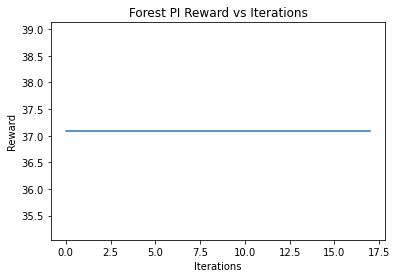

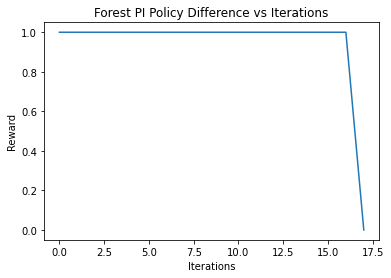

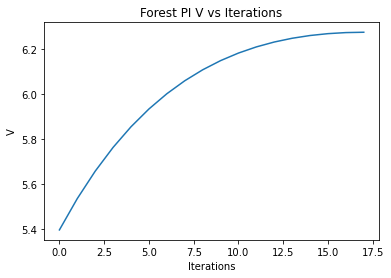

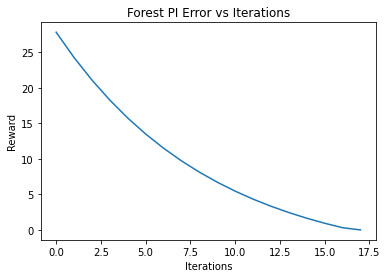

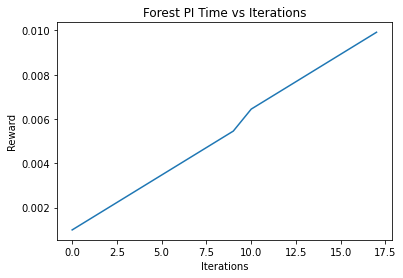

----------------------------------------




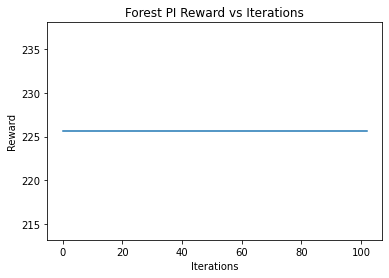

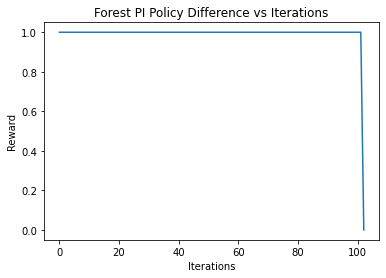

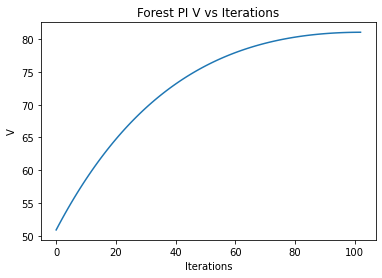

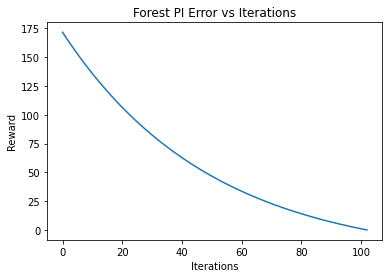

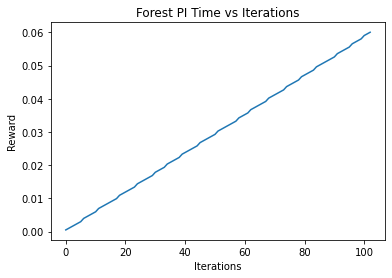

----------------------------------------




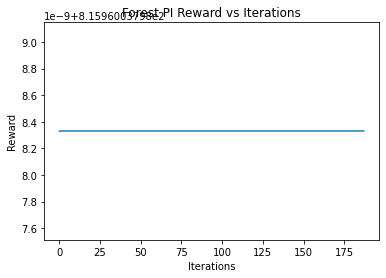

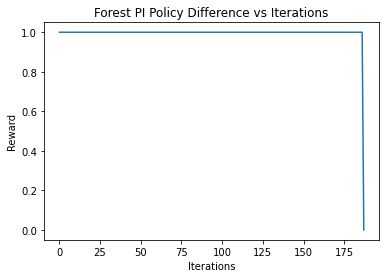

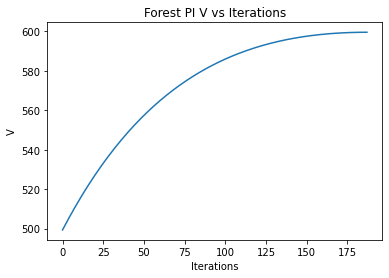

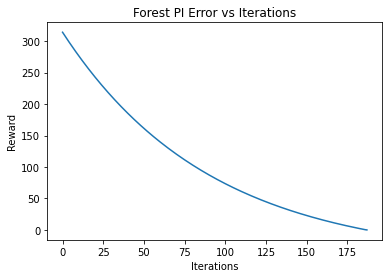

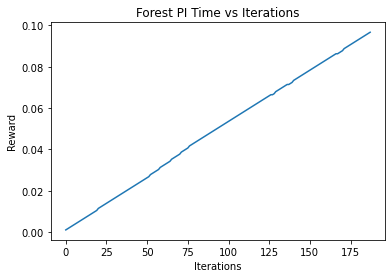

----------------------------------------




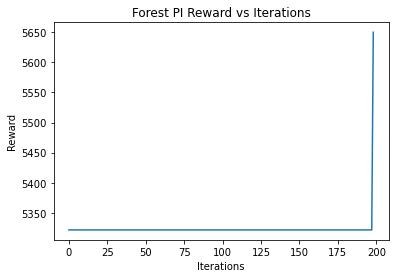

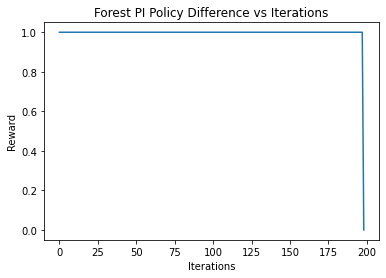

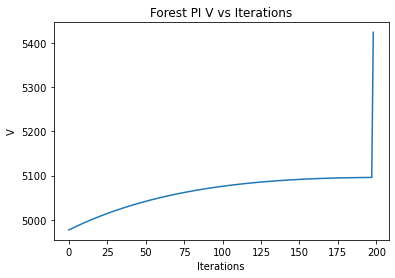

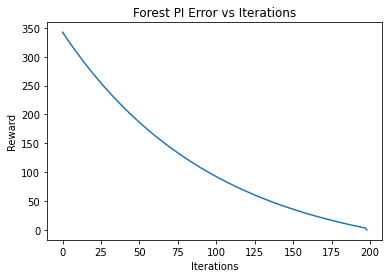

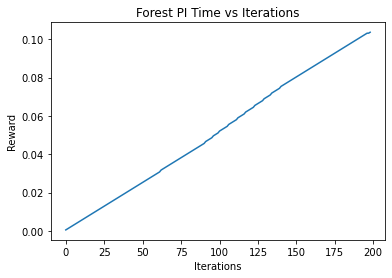

----------------------------------------




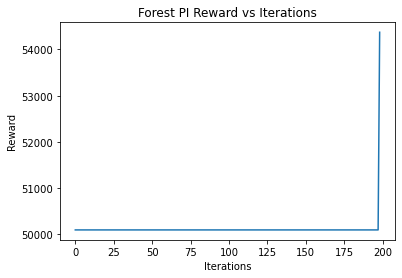

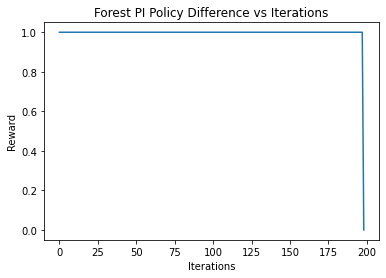

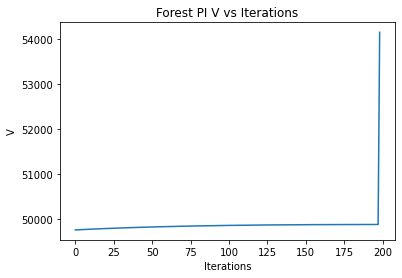

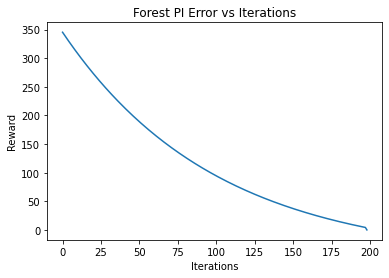

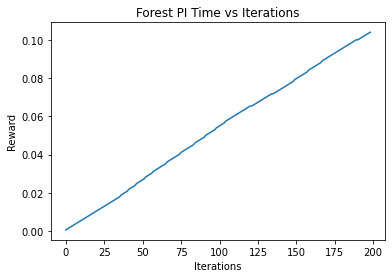

----------------------------------------




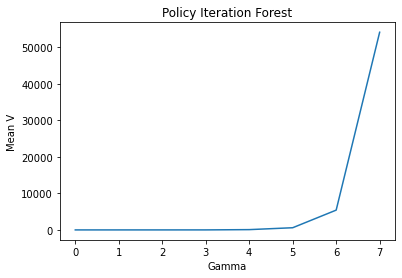

In [15]:
size = [.6, .7, .8, .9, .99, .999, .9999, .99999]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=s)
    policy_iteration_forest_stats = policy_iteration_forest.run()
    policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

#     time_taken.append(q_learning.time)
#     plot_q_learning_timetaken(time_taken)
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    # plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

    plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
                         'V')
    # plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
    rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()
    
plot_gamma(rewards_pi, 'Policy Iteration Forest')

In [ ]:
size = [.6, .7, .8, .9, .99, .999, .9999, .99999]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=s)
    policy_iteration_forest_stats = policy_iteration_forest.run()
    policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

#     time_taken.append(q_learning.time)
#     plot_q_learning_timetaken(time_taken)
    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    # plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

    plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
                         'V')
    # plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

    plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
    rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()
    
plot_gamma(rewards_pi, 'Policy Iteration Forest')

epsilon:  0.1


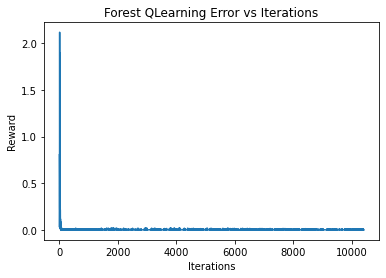

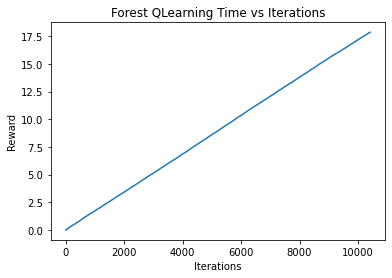

-10.0
20.0


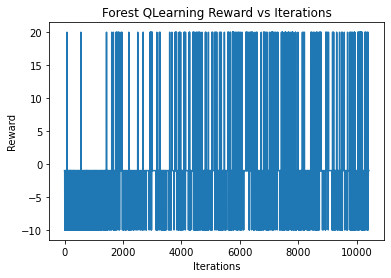

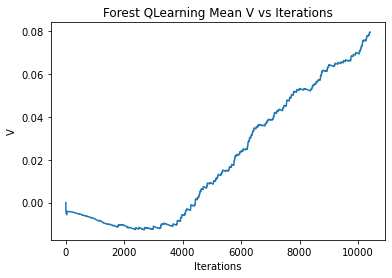

----------------------------------------


epsilon:  0.1


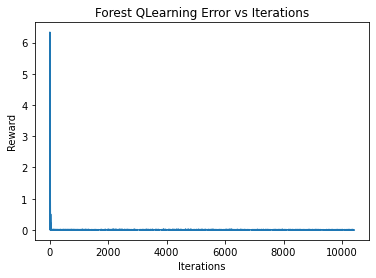

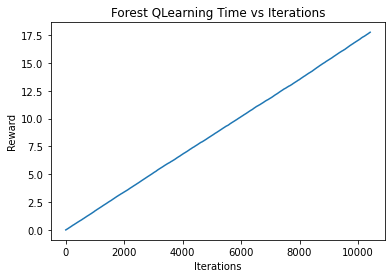

-10.0
20.0


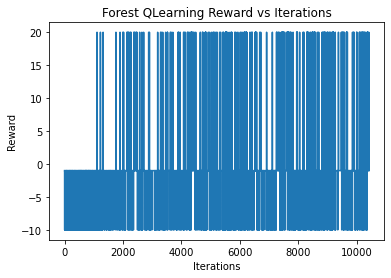

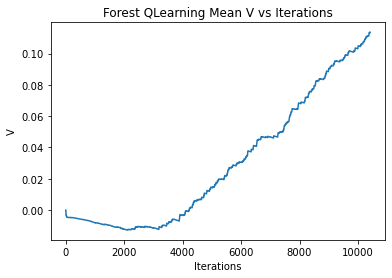

----------------------------------------


epsilon:  0.1


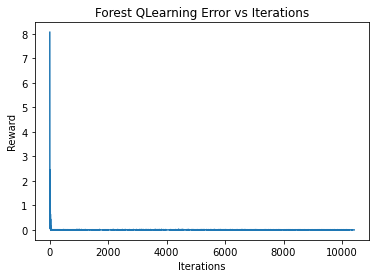

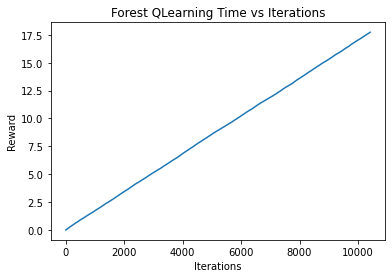

-10.0
20.0


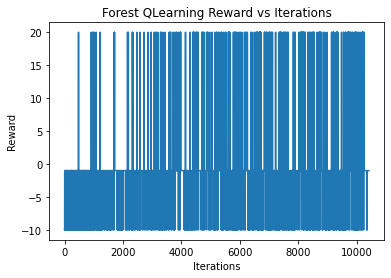

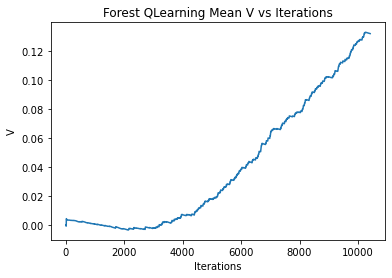

----------------------------------------


epsilon:  0.1


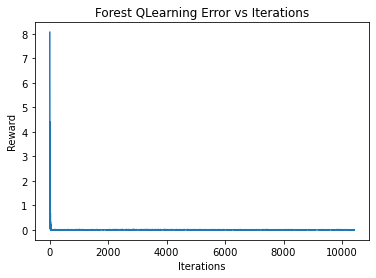

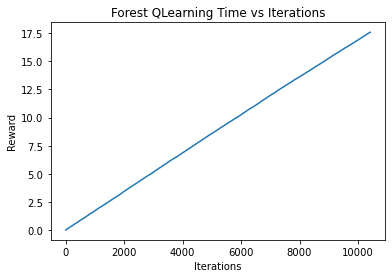

-10.0
20.0


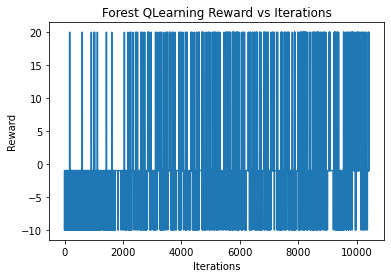

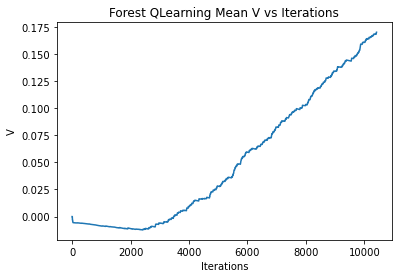

----------------------------------------


epsilon:  0.1


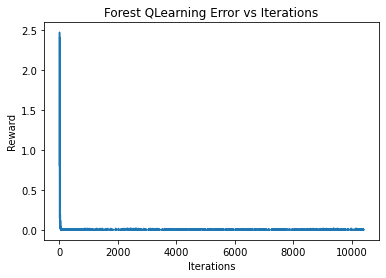

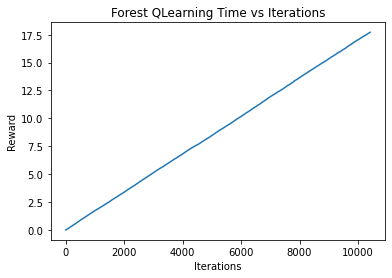

-10.0
20.0


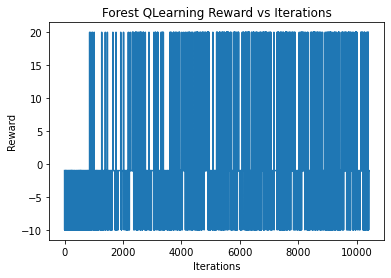

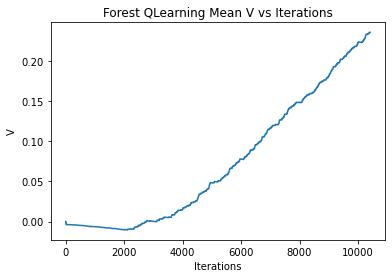

----------------------------------------


epsilon:  0.1


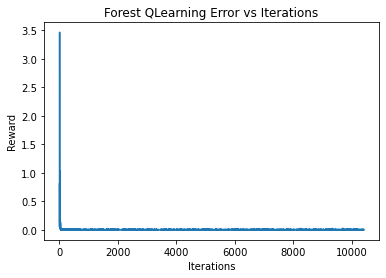

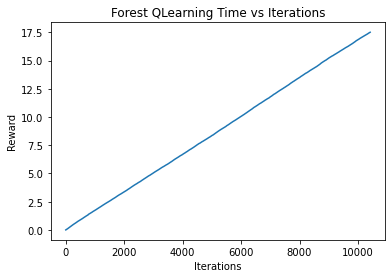

-10.0
20.0


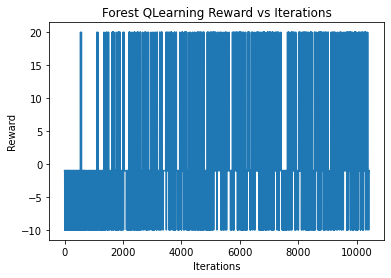

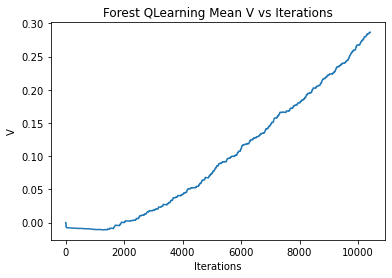

----------------------------------------


epsilon:  0.1


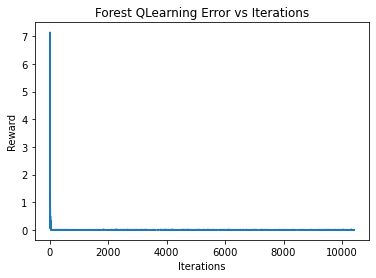

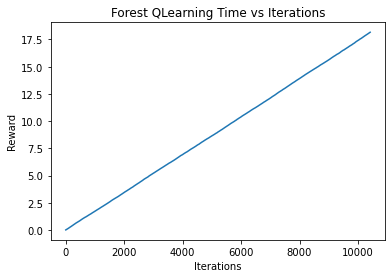

-10.0
20.0


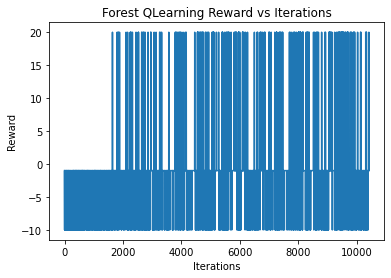

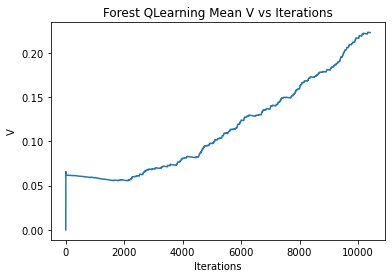

----------------------------------------




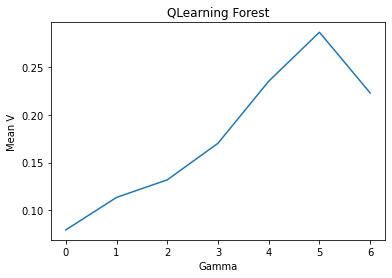

In [16]:
size = [.6, .7, .8, .9, .99, .999, .9999]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=s, n_iter=125000, alpha=.9, alpha_decay=.99, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
                                          #,
                                          # epsilon=.1, alpha=.2,
                                          # epsilon_decay=.1, alpha_decay=.1,
                                          # epsilon_min=.01
                                          )
    q_learning_forest_stats = q_learning_forest.run()
#     plot_q_learning(q_learning_forest_stats, 'Taxi QLearning', 'Reward')
#     plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')
    plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')
    plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')
#     time_taken.append(q_learning.time)
#     plot_q_learning_timetaken(time_taken)

#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

#     plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
#     plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
#                          'V')
    plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'Mean V')


#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
#     rewards_vi.append(value_iteration_forest_stats[-1]['Mean V'])
#     rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])
    rewards_qlearning.append(q_learning_forest_stats[-1]['Mean V'])
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()
    
# plot_gamma(rewards_vi, 'Value Iteration Forest')
# plot_gamma(rewards_pi, 'Policy Iteration Forest')
plot_gamma(rewards_qlearning, 'QLearning Forest')

epsilon:  0.1


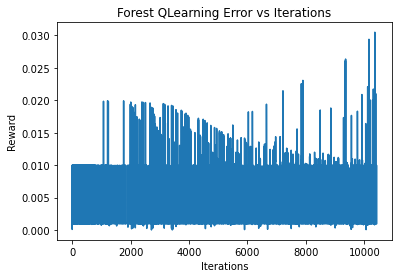

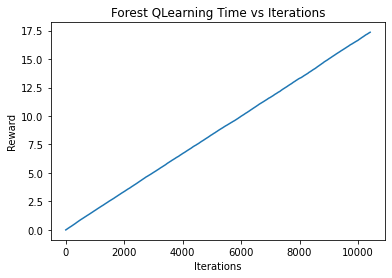

-10.0
20.0


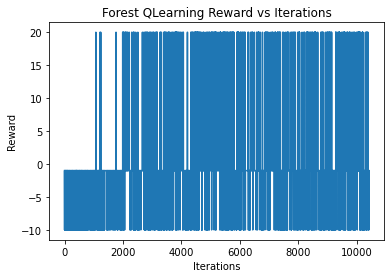

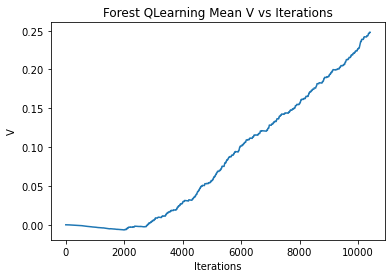

----------------------------------------


epsilon:  0.1


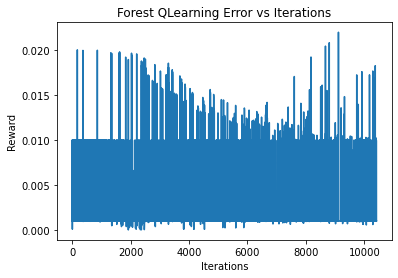

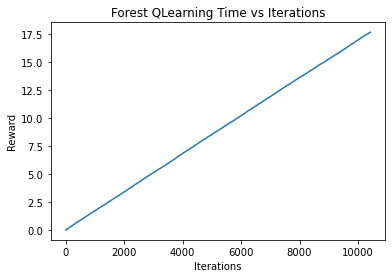

-10.0
20.0


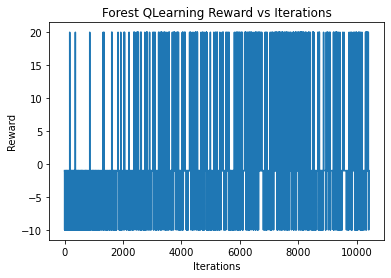

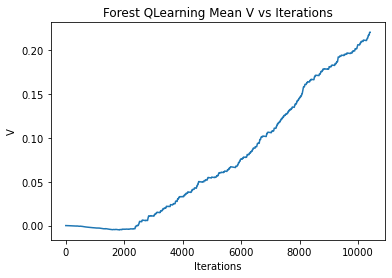

----------------------------------------


epsilon:  0.1


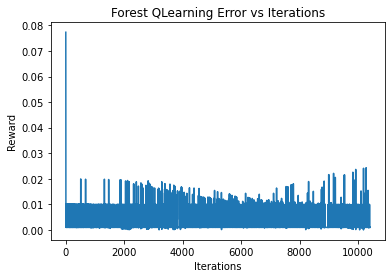

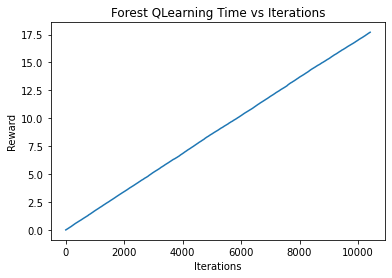

-10.0
20.0


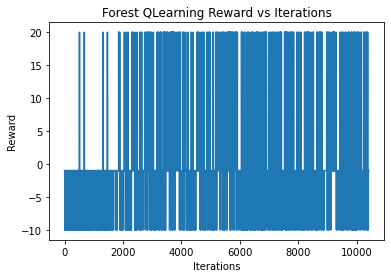

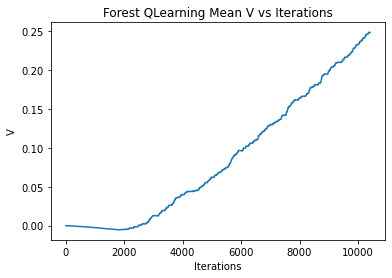

----------------------------------------


epsilon:  0.1


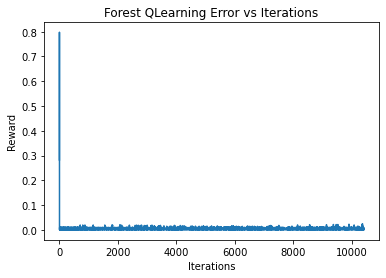

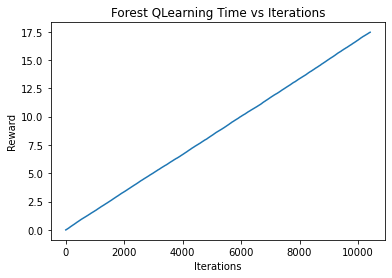

-10.0
20.0


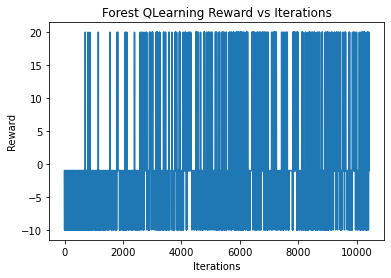

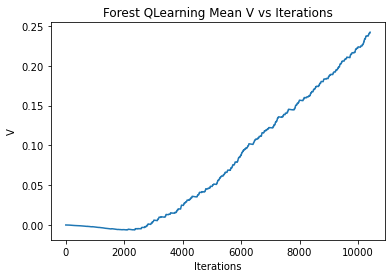

----------------------------------------


epsilon:  0.1


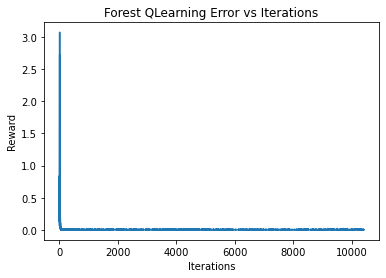

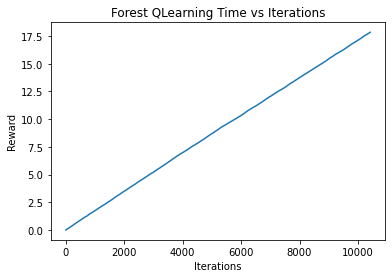

-10.0
20.0


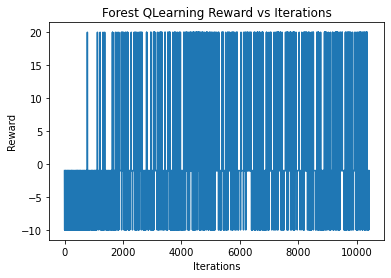

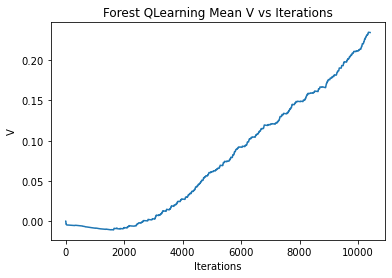

----------------------------------------


epsilon:  0.1


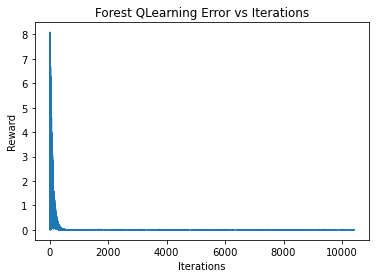

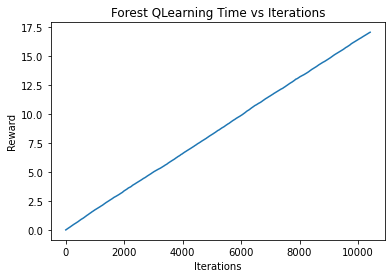

-10.0
20.0


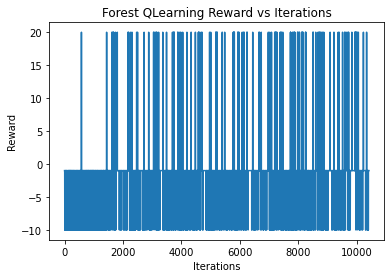

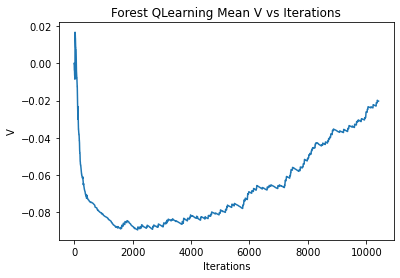

----------------------------------------


epsilon:  0.1


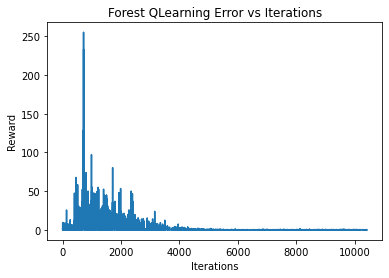

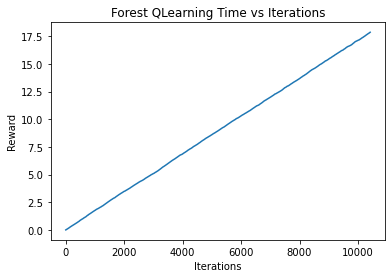

-10.0
20.0


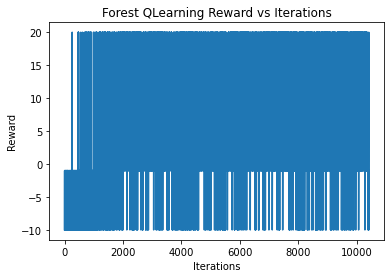

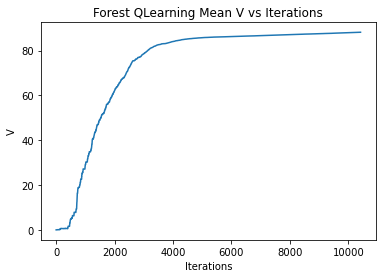

----------------------------------------


epsilon:  0.1


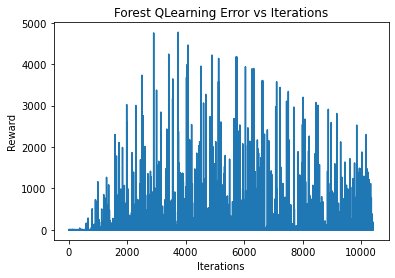

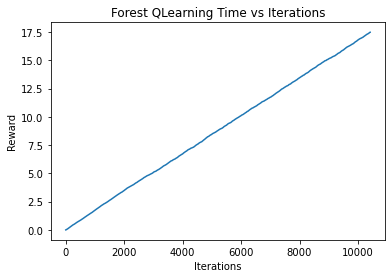

-10.0
20.0


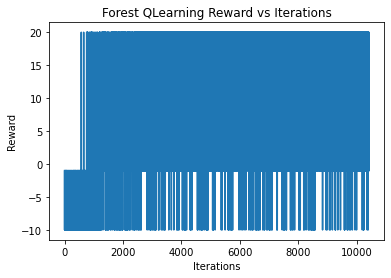

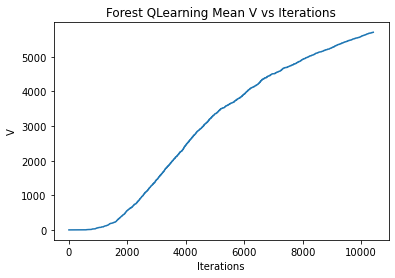

----------------------------------------


epsilon:  0.1


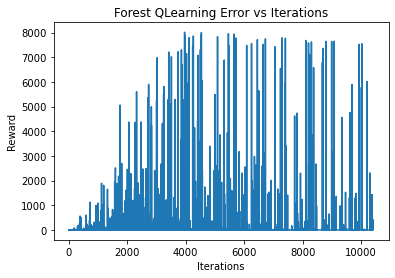

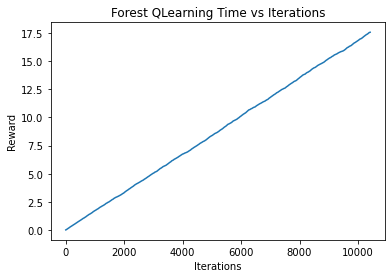

-10.0
20.0


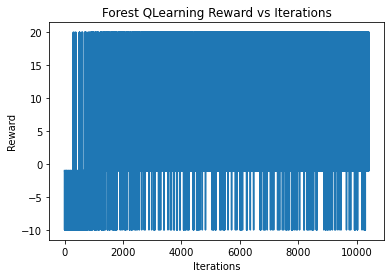

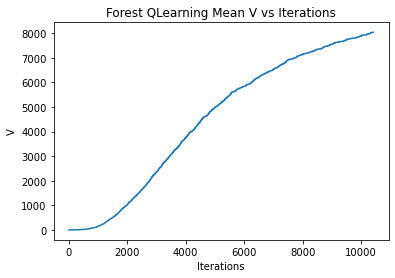

----------------------------------------


epsilon:  0.1


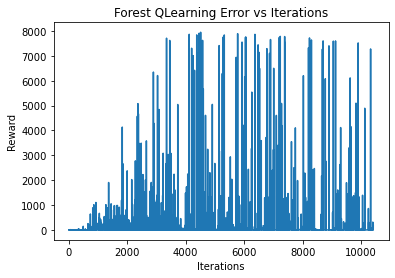

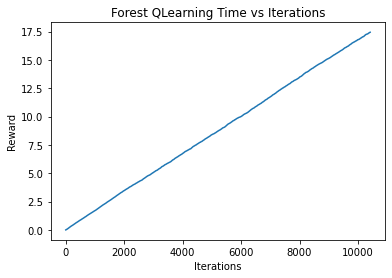

-10.0
20.0


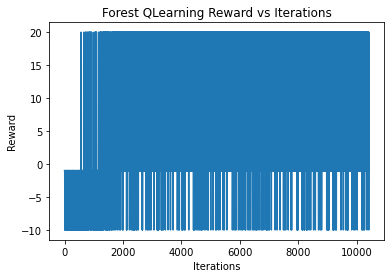

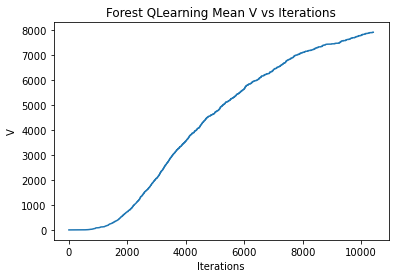

----------------------------------------


epsilon:  0.1


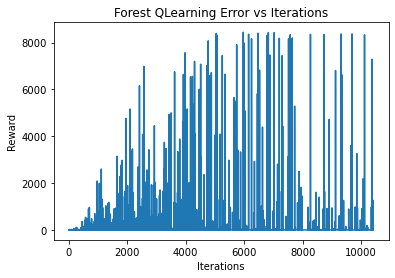

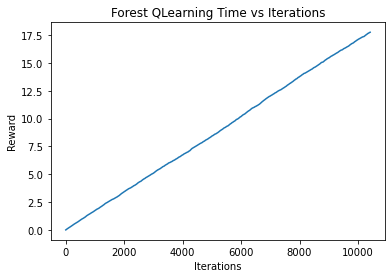

-10.0
20.0


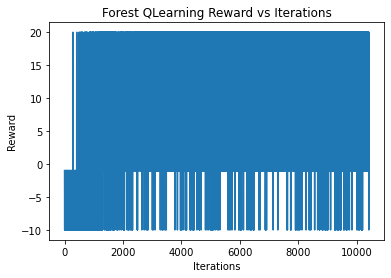

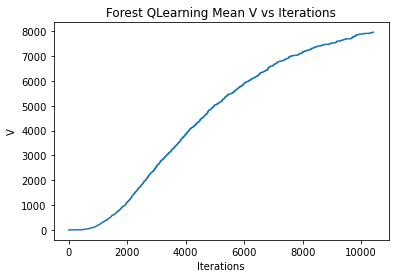

----------------------------------------




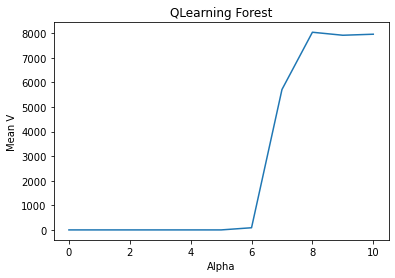

In [21]:
size = [.6, .7, .8, .9, .99, .999, .9999, .99999, .999999, .999999, .9999999]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=.999, n_iter=125000, alpha=.9, alpha_decay=s, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
                                          #,
                                          # epsilon=.1, alpha=.2,
                                          # epsilon_decay=.1, alpha_decay=.1,
                                          # epsilon_min=.01
                                          )
    q_learning_forest_stats = q_learning_forest.run()
#     plot_q_learning(q_learning_forest_stats, 'Taxi QLearning', 'Reward')
#     plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')
    plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')
    plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')
#     time_taken.append(q_learning.time)
#     plot_q_learning_timetaken(time_taken)

#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

#     plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
#     plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
#                          'V')
    plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'Mean V')


#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
#     rewards_vi.append(value_iteration_forest_stats[-1]['Mean V'])
#     rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])
    rewards_qlearning.append(q_learning_forest_stats[-1]['Mean V'])
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()
    
# plot_gamma(rewards_vi, 'Value Iteration Forest')
# plot_gamma(rewards_pi, 'Policy Iteration Forest')
plot_alpha(rewards_qlearning, 'QLearning Forest')

epsilon:  0.1


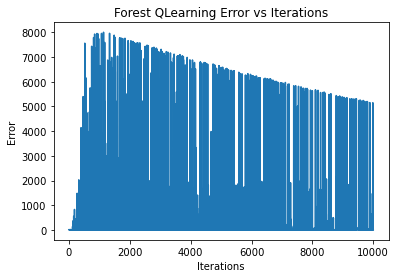

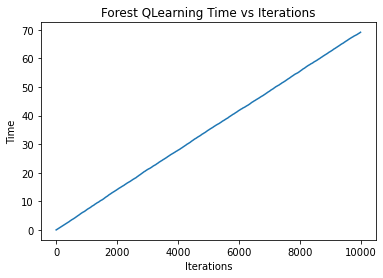

-10.0
20.0


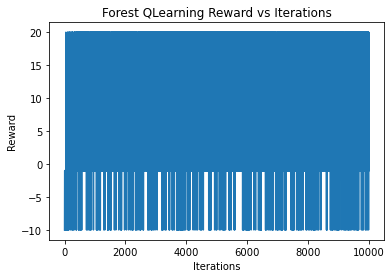

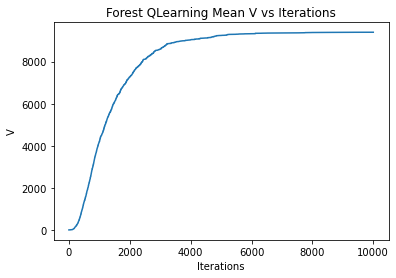

----------------------------------------


epsilon:  0.1


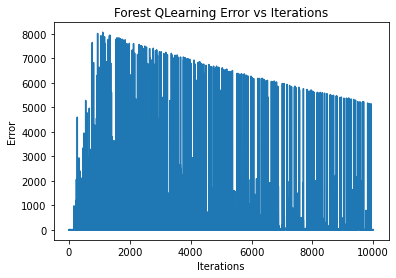

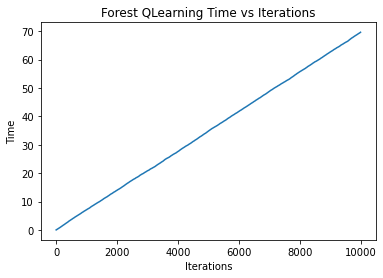

-10.0
20.0


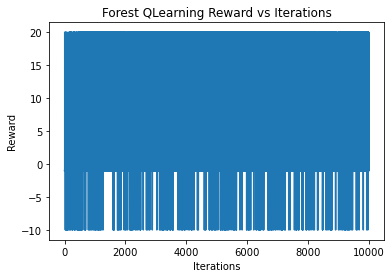

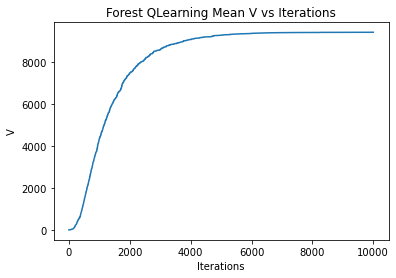

----------------------------------------


epsilon:  0.1


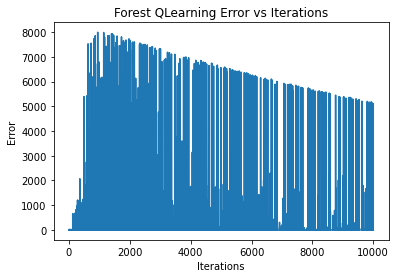

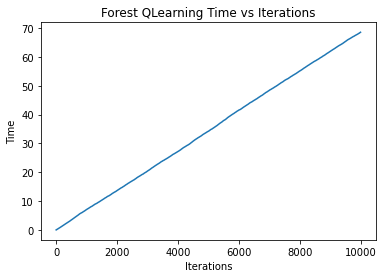

-10.0
20.0


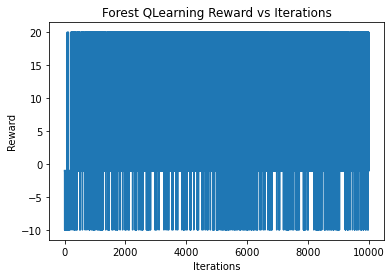

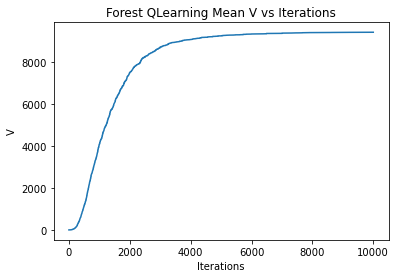

----------------------------------------


epsilon:  0.1


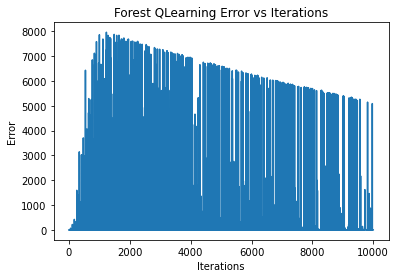

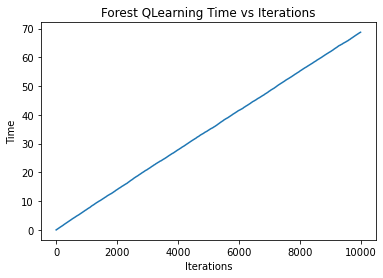

-10.0
20.0


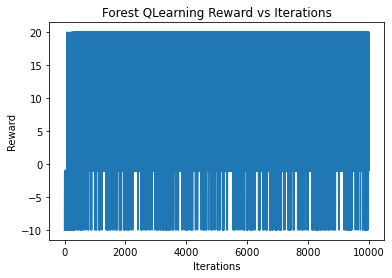

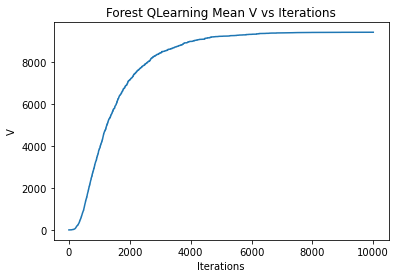

----------------------------------------


epsilon:  0.1


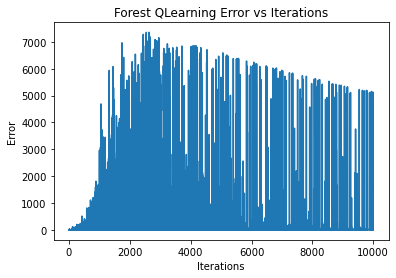

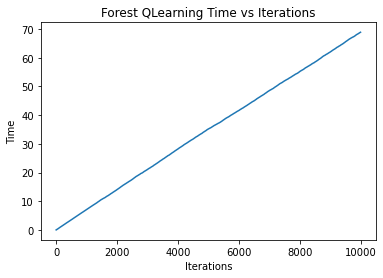

-10.0
20.0


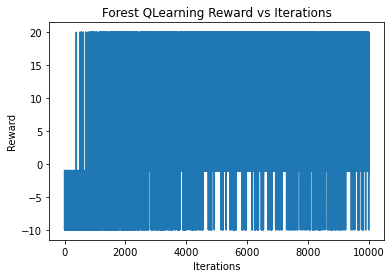

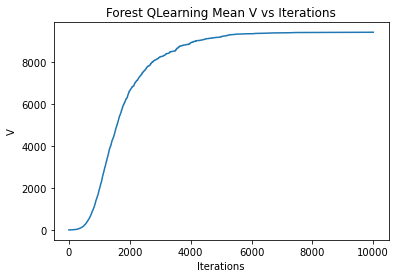

----------------------------------------


epsilon:  0.6065305080711497


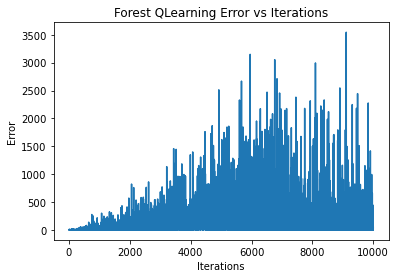

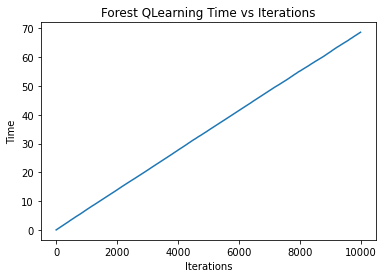

-10.0
20.0


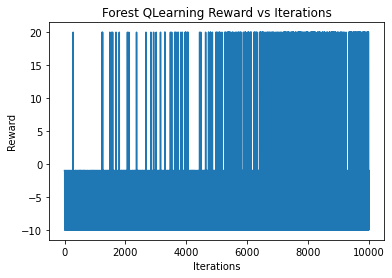

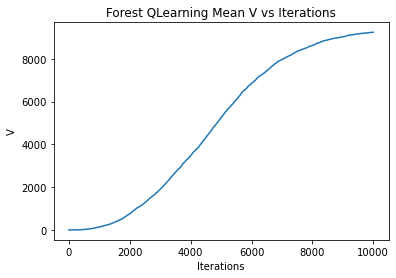

----------------------------------------


epsilon:  0.9512294221477116


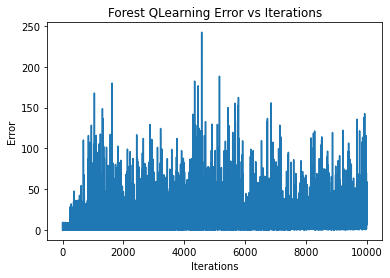

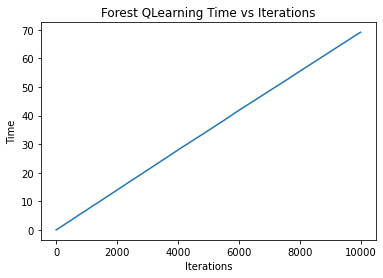

-10.0
20.0


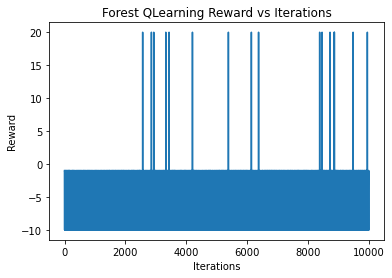

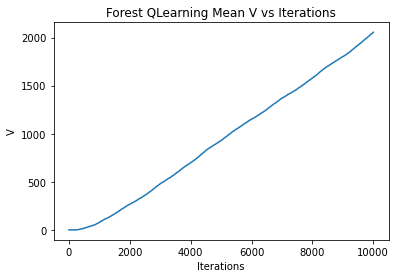

----------------------------------------




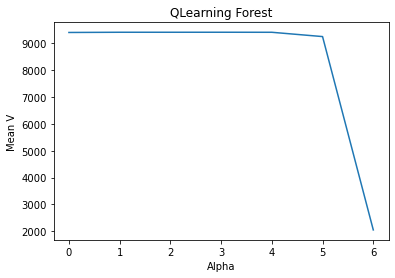

In [7]:
size = [.9, .99, .999, .9999, .99999, .999999, .9999999]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=.999, n_iter=500000, alpha=.9, alpha_decay=.999999, epsilon_decay=s# alpha=.6, alpha_decay=.1
                                          #,
                                          # epsilon=.1, alpha=.2,
                                          # epsilon_decay=.1, alpha_decay=.1,
                                          # epsilon_min=.01
                                          )
    q_learning_forest_stats = q_learning_forest.run()
#     plot_q_learning(q_learning_forest_stats, 'Taxi QLearning', 'Reward')
#     plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')
    plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')
    plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')
#     time_taken.append(q_learning.time)
#     plot_q_learning_timetaken(time_taken)

#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

#     plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
#     plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
#                          'V')
    plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'Mean V')


#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
#     rewards_vi.append(value_iteration_forest_stats[-1]['Mean V'])
#     rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])
    rewards_qlearning.append(q_learning_forest_stats[-1]['Mean V'])
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()
    
# plot_gamma(rewards_vi, 'Value Iteration Forest')
# plot_gamma(rewards_pi, 'Policy Iteration Forest')
plot_alpha(rewards_qlearning, 'QLearning Forest')

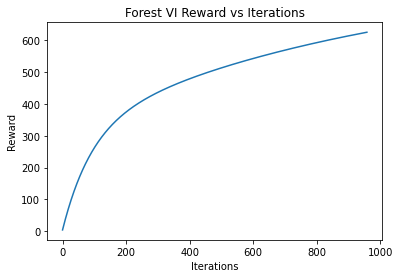

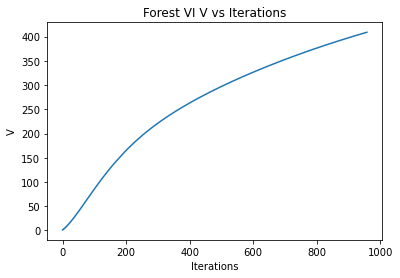

----------------------------------------




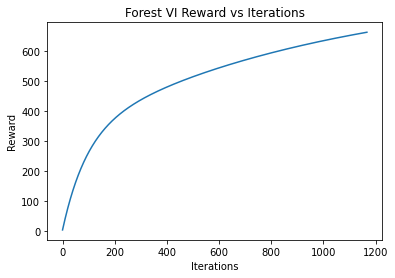

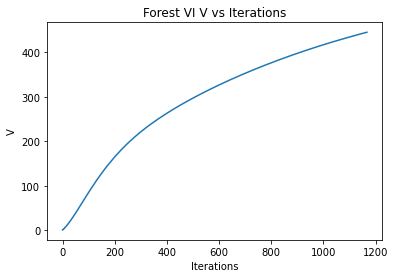

----------------------------------------




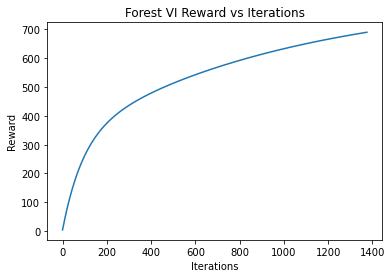

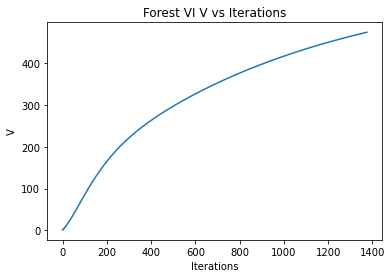

----------------------------------------




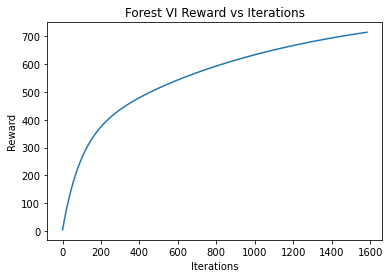

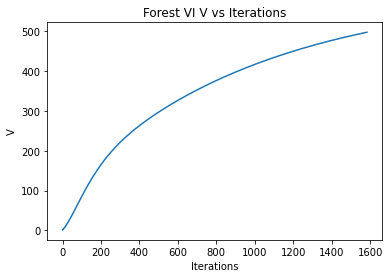

----------------------------------------




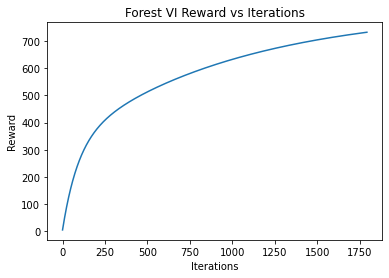

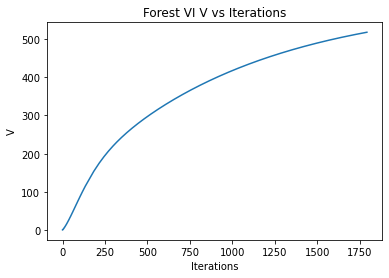

----------------------------------------




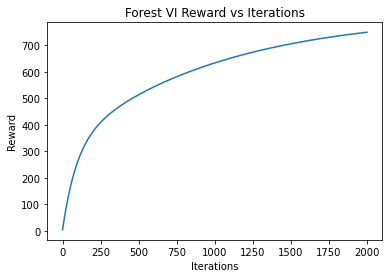

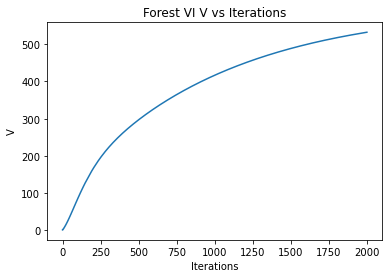

----------------------------------------




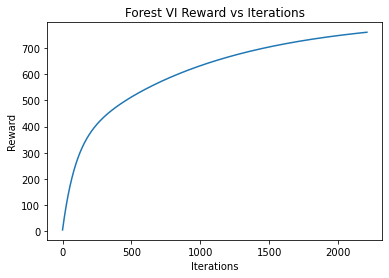

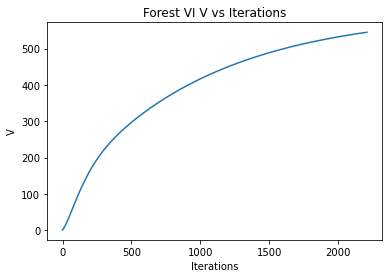

----------------------------------------




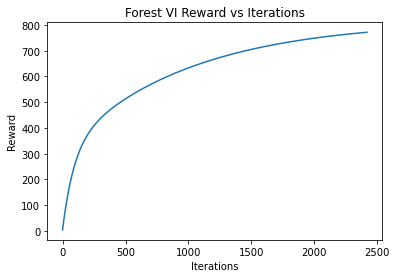

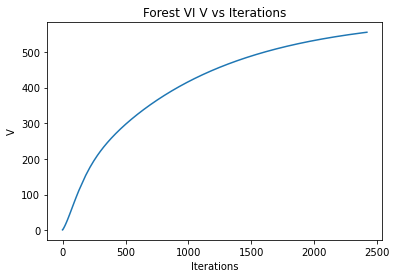

----------------------------------------




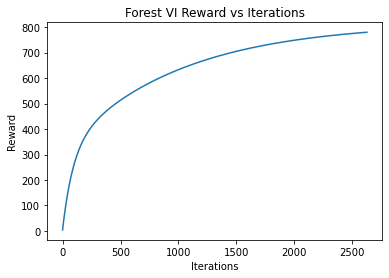

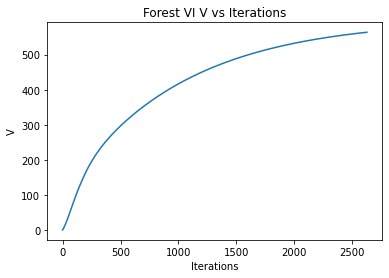

----------------------------------------




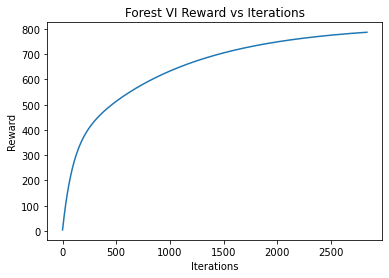

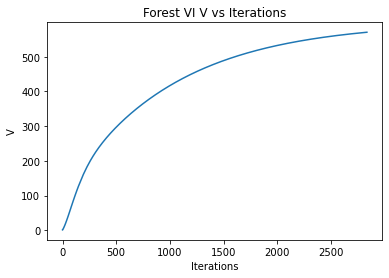

----------------------------------------




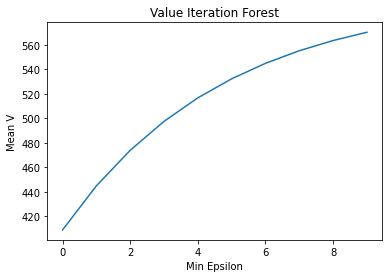

In [28]:
size = [.1, .01, .001, .0001, .00001, .000001, .0000001, .00000001, .000000001, .0000000001]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    
    value_iteration_forest = mdptoolbox.mdp.ValueIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.999, epsilon = s)
    value_iteration_forest_stats = value_iteration_forest.run()
    value_iteration_forest_policy = np.array(value_iteration_forest.policy)#.reshape(nrow, ncol)

#     policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
#                                         reward=np.asarray(R),
#                                         gamma=s)
#     policy_iteration_forest_stats = policy_iteration_forest.run()
#     policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

#     q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
#                                           gamma=s, n_iter=150000, alpha=.9, alpha_decay=.99, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
#                                           #,
#                                           # epsilon=.1, alpha=.2,
#                                           # epsilon_decay=.1, alpha_decay=.1,
#                                           # epsilon_min=.01
#                                           )
#     q_learning_forest_stats = q_learning_forest.run()
#     plot_q_learning(q_learning_forest_stats, 'Taxi QLearning', 'Reward')
#     plot_mean_v_learning(q_learning_forest_stats, 'Taxi QLearning', 'V')
#     plot_learning(q_learning_forest_stats, 'Taxi QLearning', 'Error')
#     plot_learning(q_learning_forest_stats, 'Taxi QLearning', 'Time')
#     time_taken.append(q_learning.time)
#     plot_q_learning_timetaken(time_taken)

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    # plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

    plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
#     plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
#                          'V')
    # plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')


#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
    rewards_vi.append(value_iteration_forest_stats[-1]['Mean V'])
#     rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])
#     rewards_qlearning.append(q_learning_forest_stats[-1]['Mean V'])
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()
    
plot_vi_epsilon(rewards_vi, 'Value Iteration Forest')
# plot_gamma(rewards_pi, 'Policy Iteration Forest')
# plot_gamma(rewards_qlearning, 'QLearning Forest')

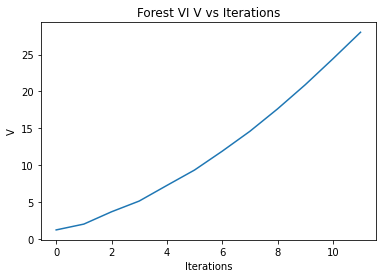

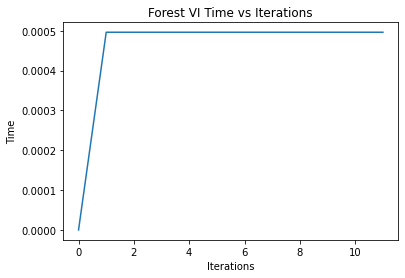

----------------------------------------




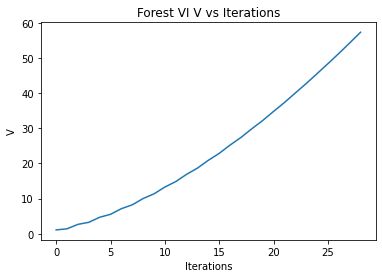

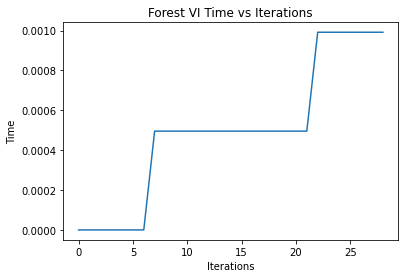

----------------------------------------




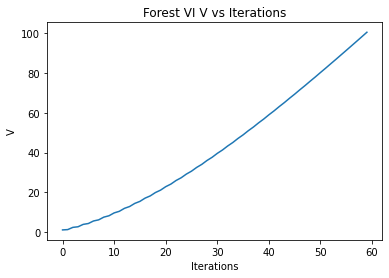

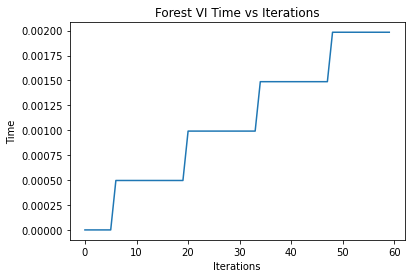

----------------------------------------




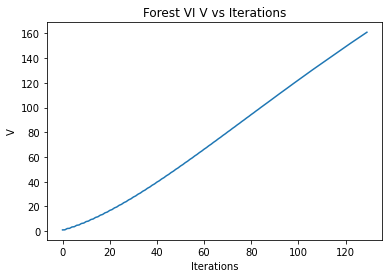

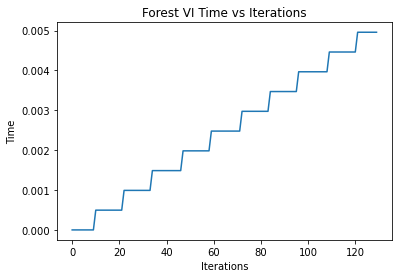

----------------------------------------




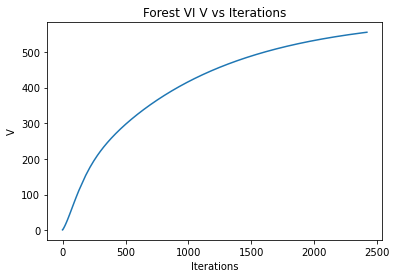

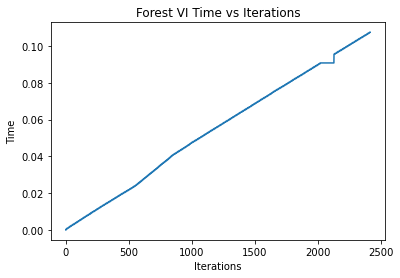

----------------------------------------




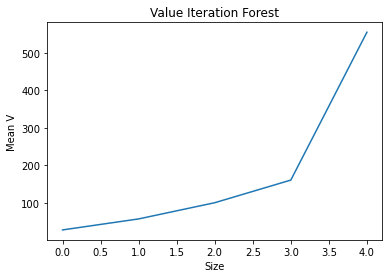

In [32]:
size = [10, 25, 50, 100, 200]
# P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    P, R = mdptoolbox.example.forest(S=s, p=0.01)
    value_iteration_forest = mdptoolbox.mdp.ValueIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.999, epsilon=.00000001)
    value_iteration_forest_stats = value_iteration_forest.run()
    value_iteration_forest_policy = np.array(value_iteration_forest.policy)#.reshape(nrow, ncol)

#     policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
#                                         reward=np.asarray(R),
#                                         gamma=s)
#     policy_iteration_forest_stats = policy_iteration_forest.run()
#     policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

#     q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
#                                           gamma=s, n_iter=150000, alpha=.9, alpha_decay=.99, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
#                                           #,
#                                           # epsilon=.1, alpha=.2,
#                                           # epsilon_decay=.1, alpha_decay=.1,
#                                           # epsilon_min=.01
#                                           )
#     q_learning_forest_stats = q_learning_forest.run()
#     plot_q_learning(q_learning_forest_stats, 'Taxi QLearning', 'Reward')
#     plot_mean_v_learning(q_learning_forest_stats, 'Taxi QLearning', 'V')
#     plot_learning(q_learning_forest_stats, 'Taxi QLearning', 'Error')
#     plot_learning(q_learning_forest_stats, 'Taxi QLearning', 'Time')
#     time_taken.append(q_learning.time)
#     plot_q_learning_timetaken(time_taken)

#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
    # plot_q_learning(q_learning_forest_stats, 'Forest QLearning', 'Reward')
    # print(q_learning_stats[0]['Reward'])
    # print(q_learning_stats[9500]['Reward'])

#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')

    plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
#     plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
#                          'V')
    # plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'V')


#     plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Error')

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
#     plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
    rewards_vi.append(value_iteration_forest_stats[-1]['Mean V'])
#     rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])
#     rewards_qlearning.append(q_learning_forest_stats[-1]['Mean V'])
    # plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')

    print("----------------------------------------")
    print()
    print()
    
plot_size_vs_rewards(rewards_vi, 'Value Iteration Forest')
# plot_gamma(rewards_pi, 'Policy Iteration Forest')
# plot_gamma(rewards_qlearning, 'QLearning Forest')

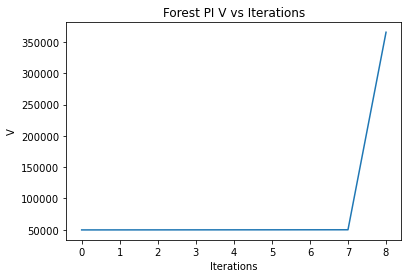

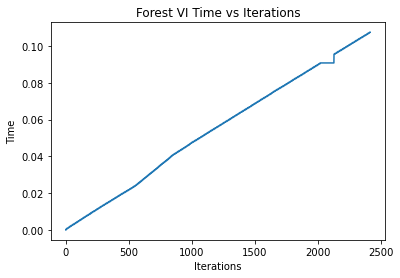

----------------------------------------




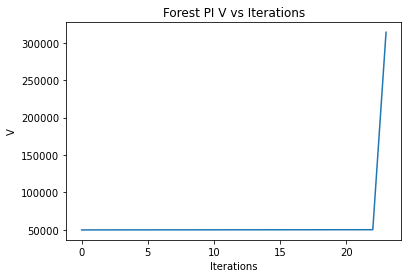

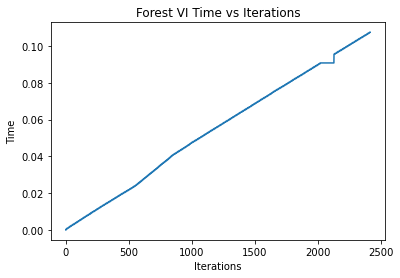

----------------------------------------




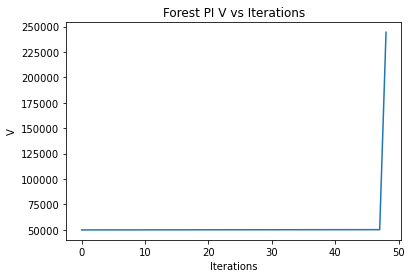

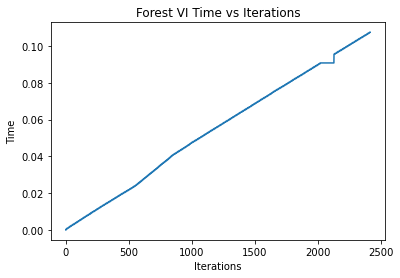

----------------------------------------




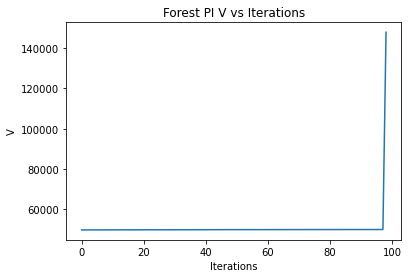

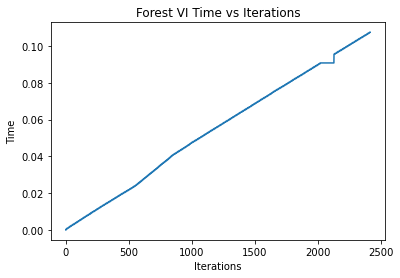

----------------------------------------




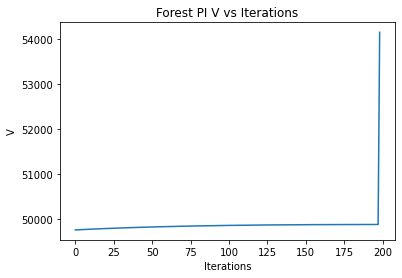

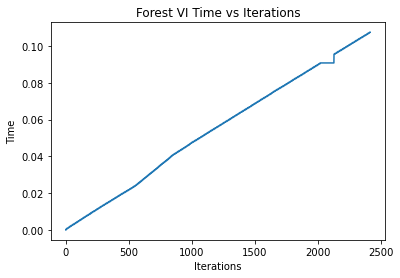

----------------------------------------




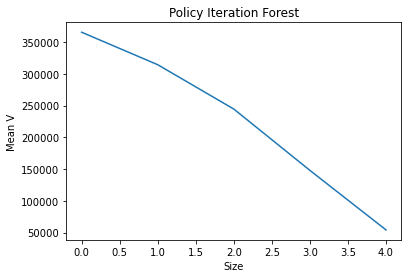

In [34]:
size = [10, 25, 50, 100, 200]
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    P, R = mdptoolbox.example.forest(S=s, p=0.01)

    policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
                                        reward=np.asarray(R),
                                        gamma=.99999)
    policy_iteration_forest_stats = policy_iteration_forest.run()
    policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

    plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI',
                         'V')

    plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')
    rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])

    print("----------------------------------------")
    print()
    print()
    
plot_size_vs_rewards(rewards_pi, 'Policy Iteration Forest')

epsilon:  0.1


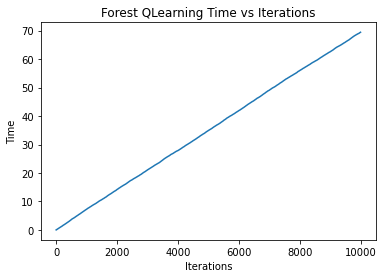

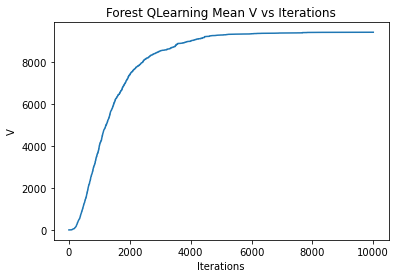

----------------------------------------


epsilon:  0.1


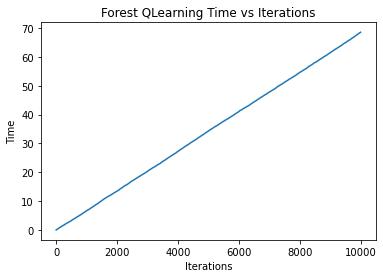

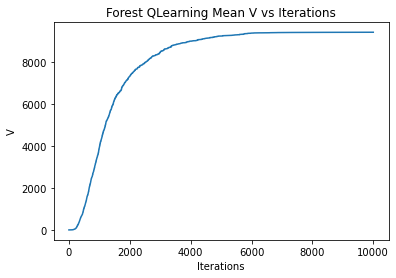

----------------------------------------


epsilon:  0.1


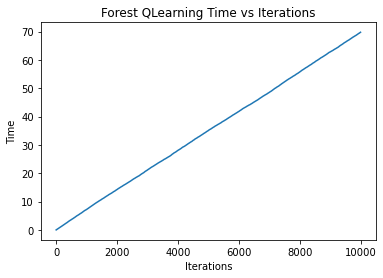

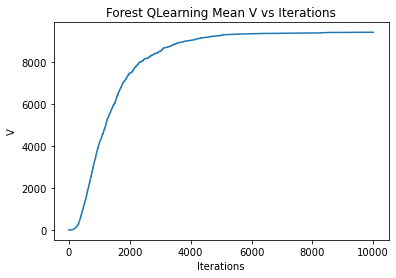

----------------------------------------


epsilon:  0.1


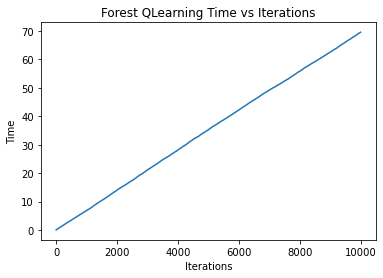

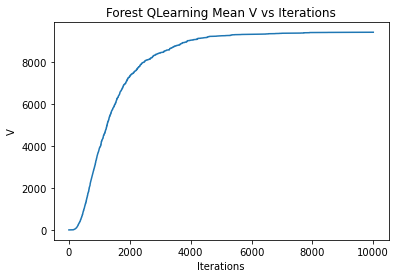

----------------------------------------


epsilon:  0.1


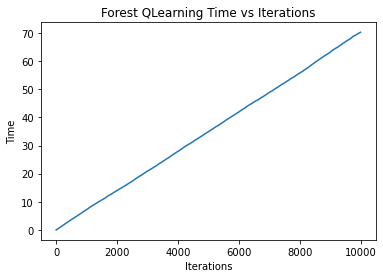

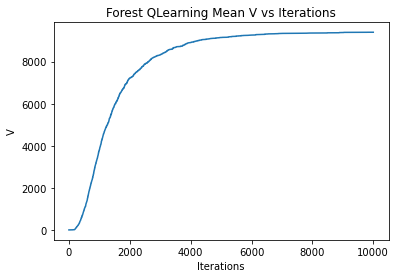

----------------------------------------




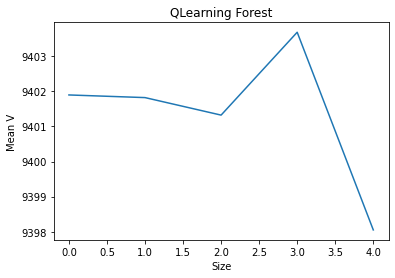

In [36]:
size = [10, 25, 50, 100, 200]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
rewards_vi = []
rewards_pi = []
rewards_qlearning = []
for s in size:
    P, R = mdptoolbox.example.forest(S=s, p=0.01)
    q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=.999, n_iter=500000, alpha=.9, alpha_decay=.999999, epsilon_decay=.9999# alpha=.6, alpha_decay=.1
                                          #,
                                          # epsilon=.1, alpha=.2,
                                          # epsilon_decay=.1, alpha_decay=.1,
                                          # epsilon_min=.01
                                          )
    q_learning_forest_stats = q_learning_forest.run()
    plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')
    plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'Mean V')
    rewards_qlearning.append(q_learning_forest_stats[-1]['Mean V'])
   
    print("----------------------------------------")
    print()
    print()
    
plot_size_vs_rewards(rewards_qlearning, 'QLearning Forest')

QLearning Plot size of 200
epsilon:  0.1
-10.0
20.0


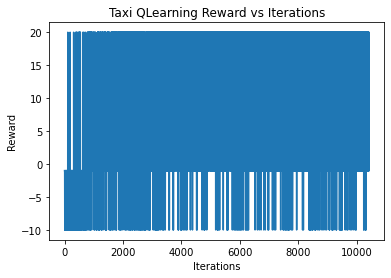

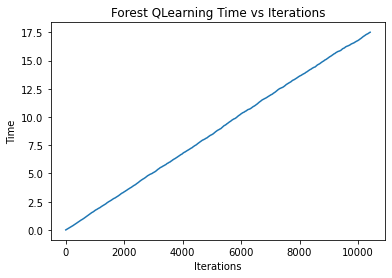

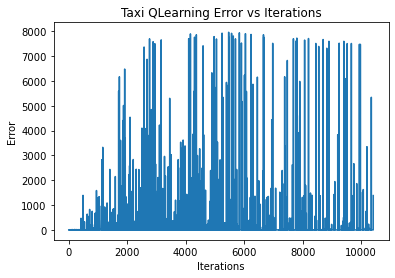

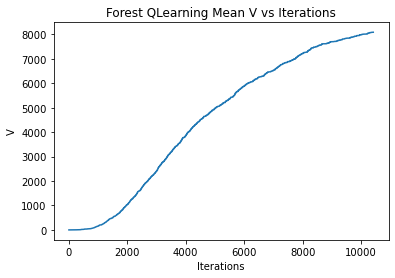

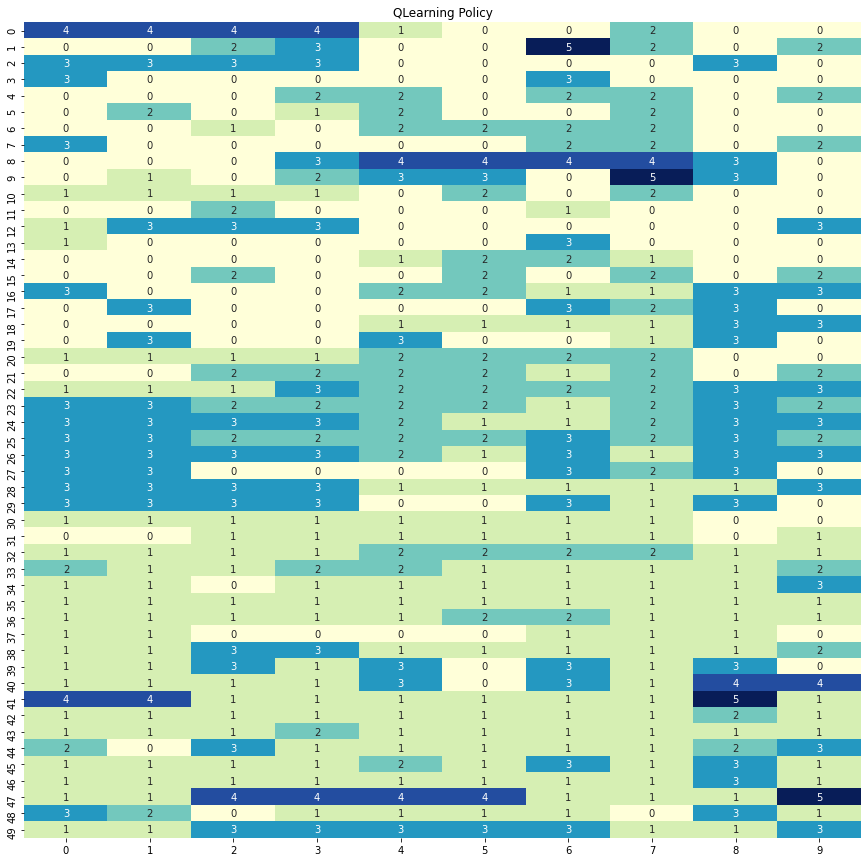

----------------------------------------




In [6]:
print('QLearning Plot size of 200')
# size = [10, 25, 50, 100, 200]
P, R = mdptoolbox.example.forest(S=200, p=0.01)
q_learning_forest = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                      gamma=.999, n_iter=125000, alpha=.9, 
                                      alpha_decay=.999999, epsilon_decay=.9)
q_learning_forest_stats = q_learning_forest.run()
plot_q_learning(q_learning_forest_stats, 'Taxi QLearning', 'Reward')
plot_learning(q_learning_forest_stats, 'Forest QLearning', 'Time')
plot_learning(q_learning_forest_stats, 'Taxi QLearning', 'Error')
plot_mean_v_learning(q_learning_forest_stats, 'Forest QLearning', 'Mean V')
plot_matrix(np.array(q_learning_forest.policy).reshape(50, 10), 'QLearning Policy')
# rewards_qlearning.append(q_learning_forest_stats[-1]['Mean V'])
   
print("----------------------------------------")
print()
print()
    
# plot_size_vs_rewards(rewards_qlearning, 'QLearning Forest')

PI Plot size of 200


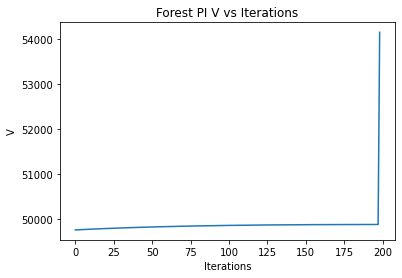

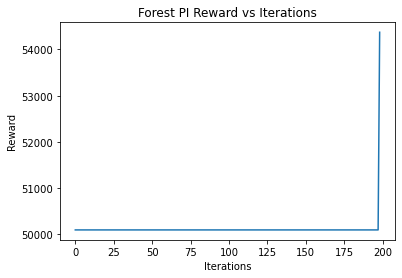

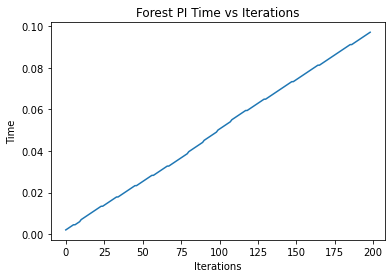

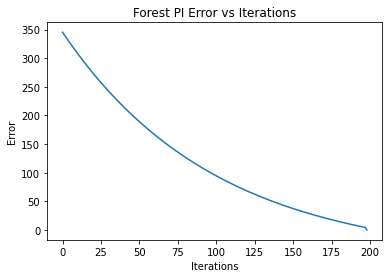

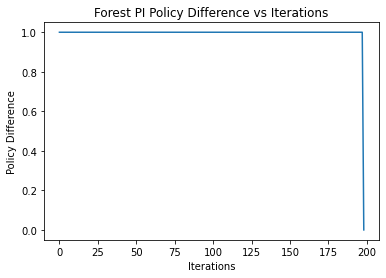

In [3]:
print('PI Plot size of 200')
P, R = mdptoolbox.example.forest(S=200, p=0.01)
policy_iteration_forest = mdptoolbox.mdp.PolicyIteration(transitions=np.asarray(P),
                                    reward=np.asarray(R),
                                    gamma=.99999)
policy_iteration_forest_stats = policy_iteration_forest.run()
policy_iteration_forest_policy = np.array(policy_iteration_forest.policy)#.reshape(nrow, ncol)

plot_mean_v_learning(policy_iteration_forest_stats, 'Forest PI', 'V')
plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Reward')
plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Time')
plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Error')
plot_learning(policy_iteration_forest_stats, 'Forest PI', 'Policy Difference')
# rewards_pi.append(policy_iteration_forest_stats[-1]['Mean V'])

# print("----------------------------------------")
# print()
# print()
    
# plot_size_vs_rewards(rewards_pi, 'Policy Iteration Forest')

VI Plot size of 200


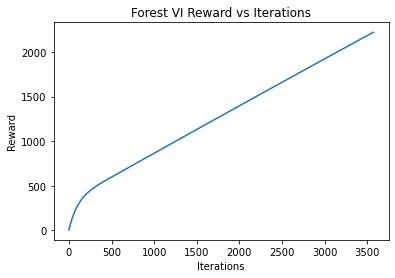

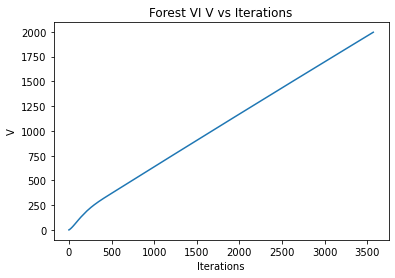

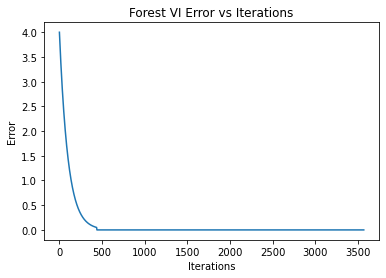

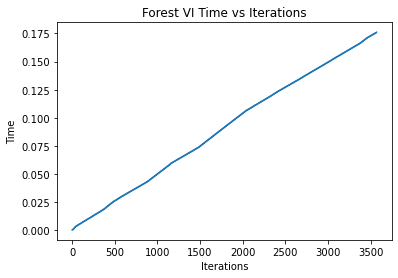

In [5]:
print('VI Plot size of 200')
P, R = mdptoolbox.example.forest(S=200, p=0.01)
value_iteration_forest = mdptoolbox.mdp.ValueIteration(transitions=np.asarray(P),
                                    reward=np.asarray(R),
                                    gamma=.99999, epsilon=.0000000001)
value_iteration_forest_stats = value_iteration_forest.run()
value_iteration_forest_policy = np.array(value_iteration_forest.policy)#.reshape(nrow, ncol)

plot_learning(value_iteration_forest_stats, 'Forest VI', 'Reward')
plot_mean_v_learning(value_iteration_forest_stats, 'Forest VI', 'V')
plot_learning(value_iteration_forest_stats, 'Forest VI', 'Error')
plot_learning(value_iteration_forest_stats, 'Forest VI', 'Time')

Taxi QLearning Gamma exploration
epsilon:  0.1
-10.0
20.0


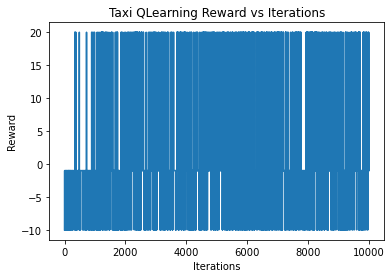

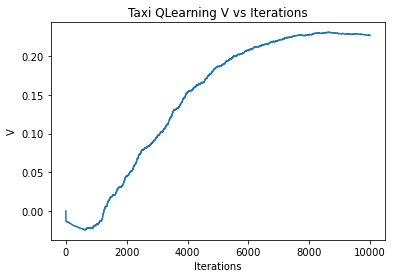

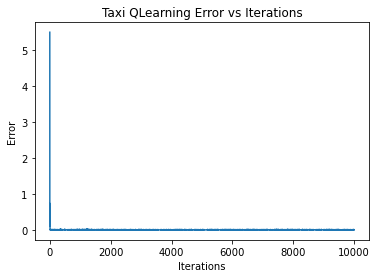

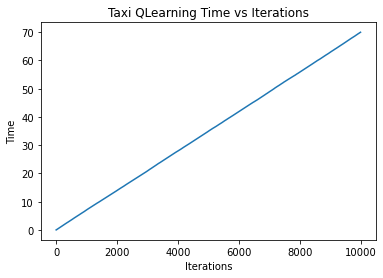

epsilon:  0.1
-10.0
20.0


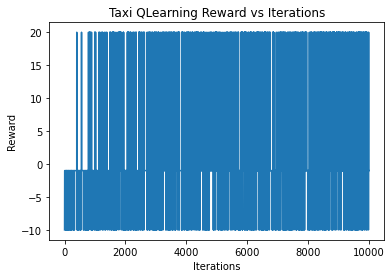

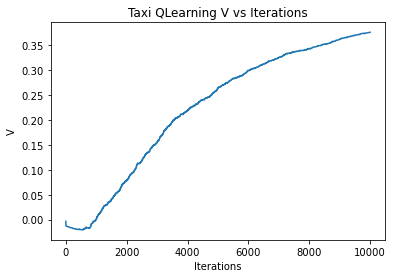

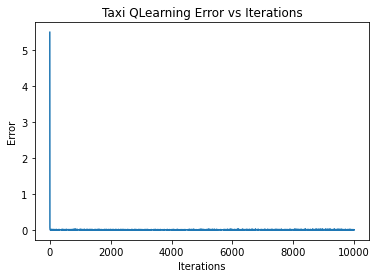

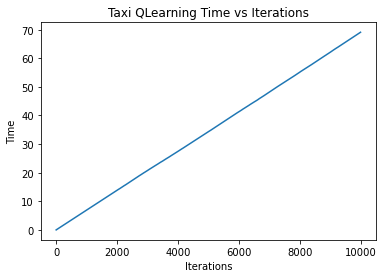

epsilon:  0.1
-10.0
20.0


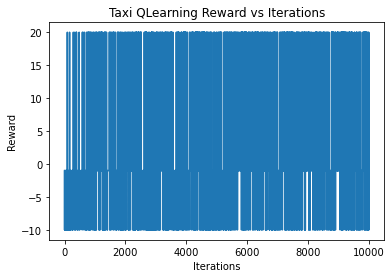

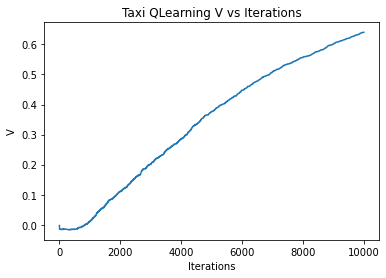

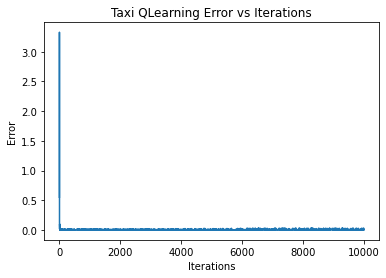

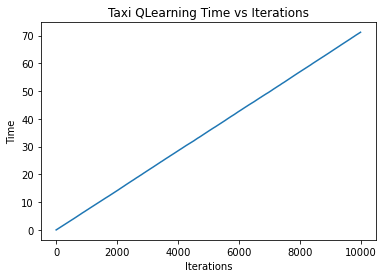

epsilon:  0.1
-10.0
20.0


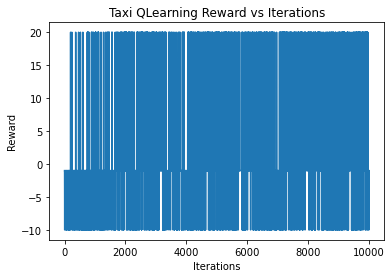

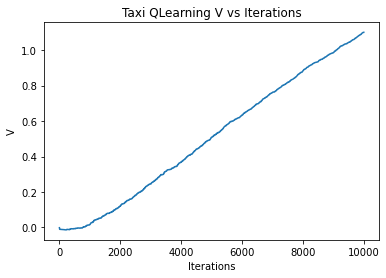

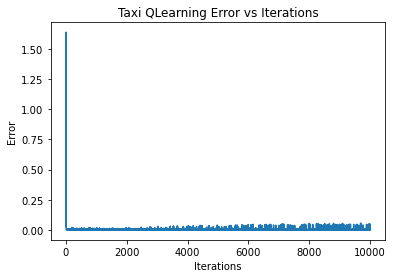

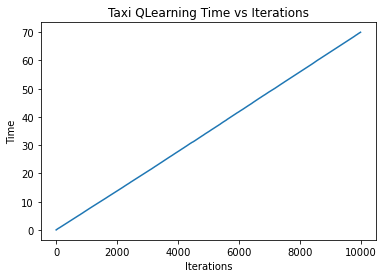

epsilon:  0.1
-10.0
20.0


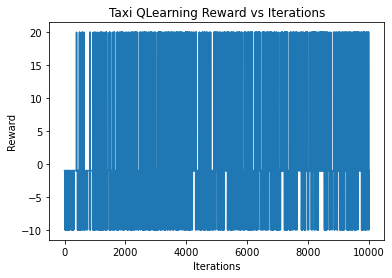

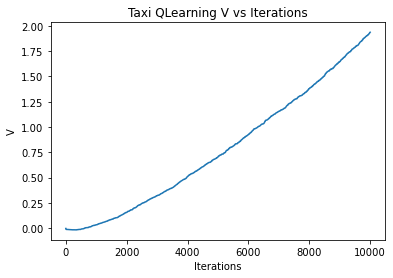

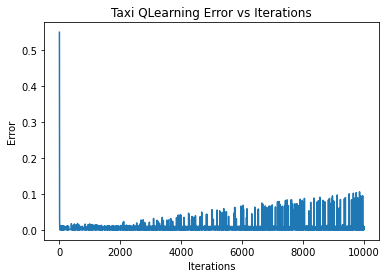

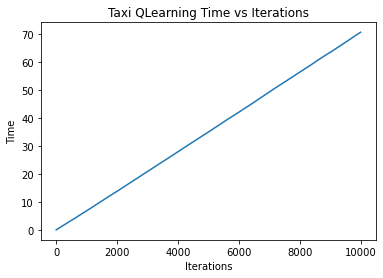

epsilon:  0.1
-10.0
20.0


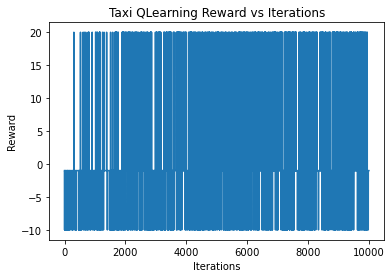

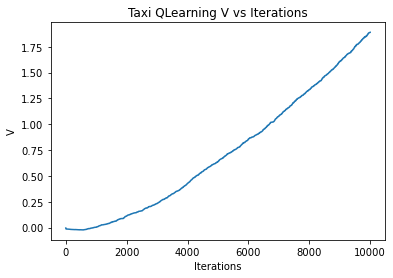

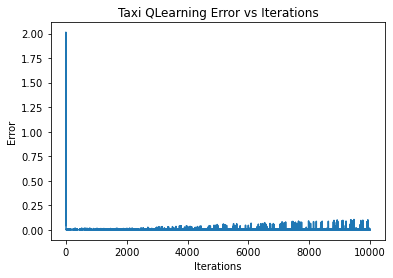

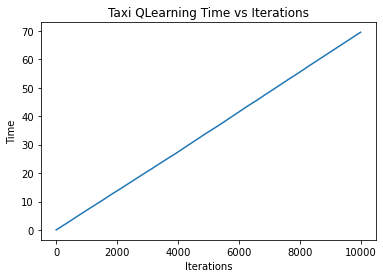

epsilon:  0.1
-10.0
20.0


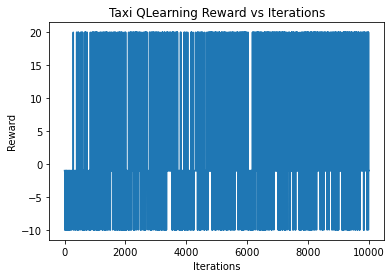

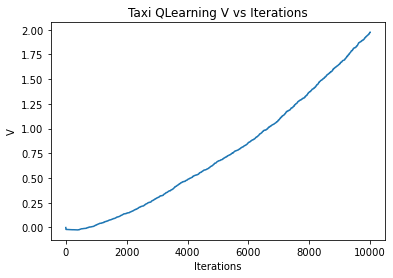

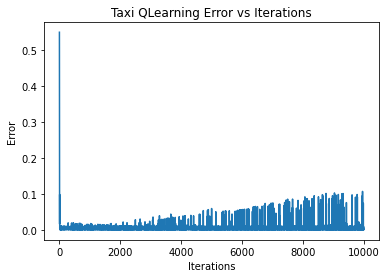

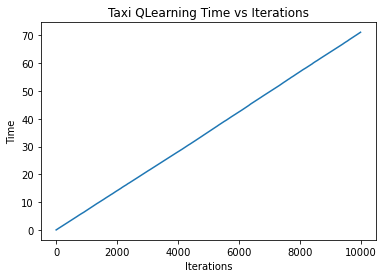

epsilon:  0.1
-10.0
20.0


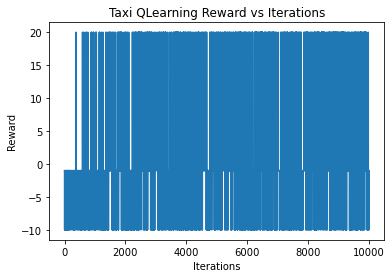

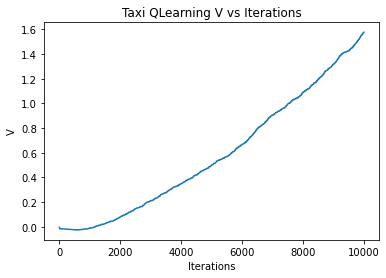

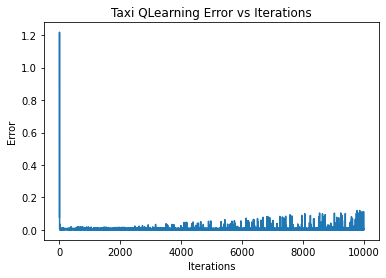

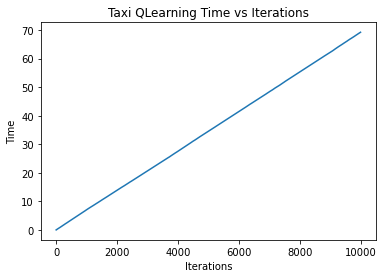

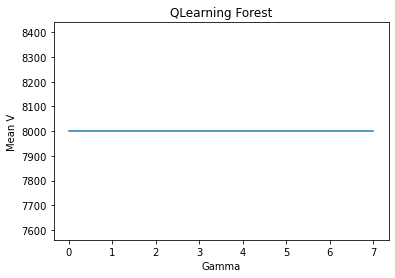

In [55]:
size = [.6, .7, .8, .9, .99, .999, .9999, .99999]
print('Taxi QLearning Gamma exploration')
# iters_list = [40000000, 20000000, 10000000, 5000000, 1000000]
# time_taken = []
rewards_qlearning = []
for s in size:
    q_learning = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=s, n_iter=500000, alpha=.9#, alpha_decay=.99, epsilon_decay=.9999999# alpha=.6, alpha_decay=.1
                                          #,
                                          # epsilon=.1, alpha=.2,
                                          # epsilon_decay=.1, alpha_decay=.1,
                                          # epsilon_min=.01
                                          )
    q_learning_stats = q_learning.run()
    plot_q_learning(q_learning_stats, 'Taxi QLearning', 'Reward')
    plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'V')
    plot_learning(q_learning_stats, 'Taxi QLearning', 'Error')
    plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')
    rewards_qlearning.append(q_learning_stats[-1]['Mean V'])
#     time_taken.append(q_learning.time)
# plot_q_learning_timetaken(time_taken)
plot_gamma(rewards_qlearning, 'QLearning Forest')

Taxi QLearning Alpha Decay exploration
epsilon:  0.1
-10.0
20.0


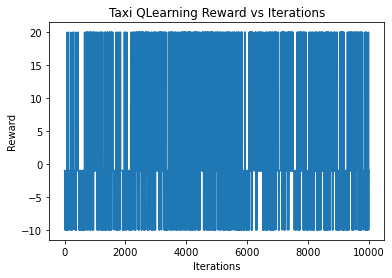

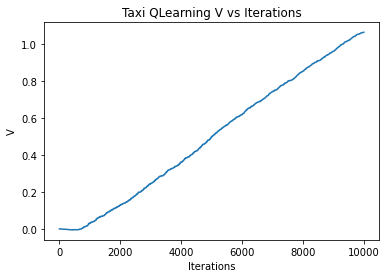

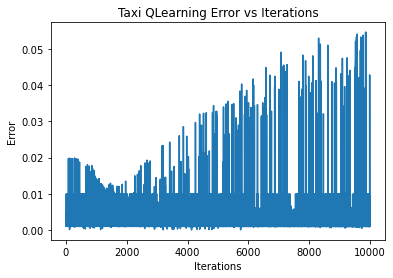

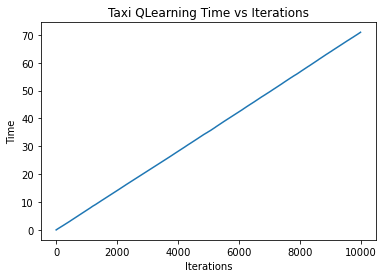

epsilon:  0.1
-10.0
20.0


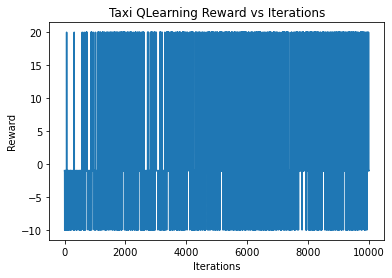

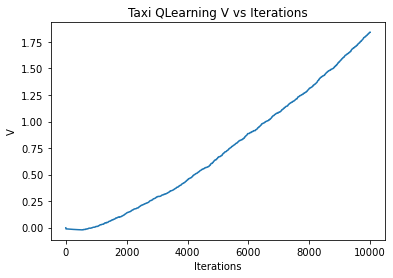

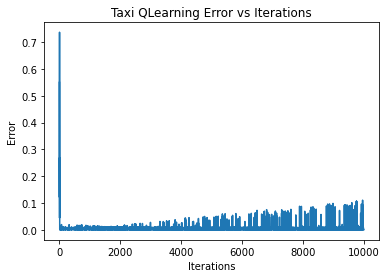

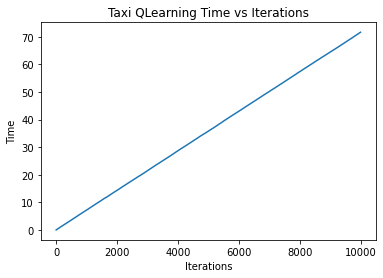

epsilon:  0.1
-10.0
20.0


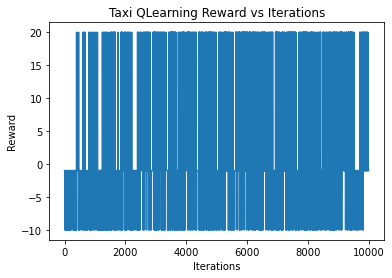

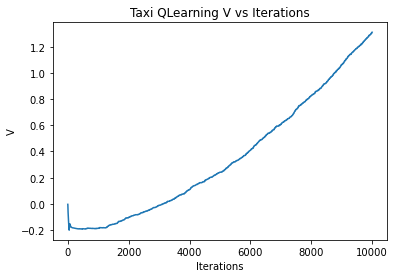

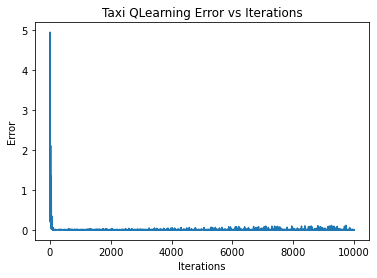

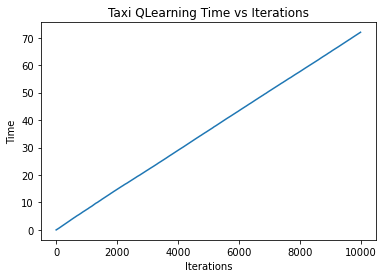

epsilon:  0.1
-10.0
20.0


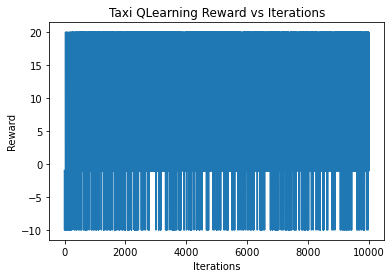

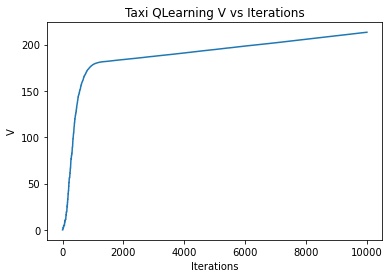

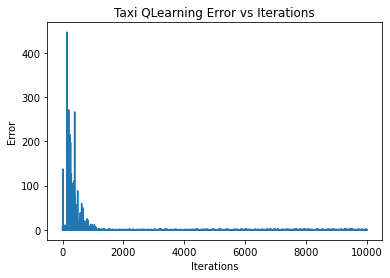

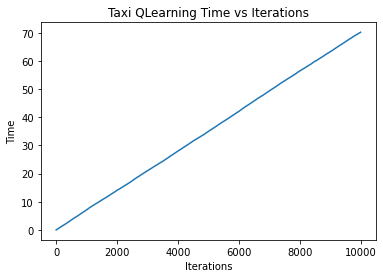

epsilon:  0.1
-10.0
20.0


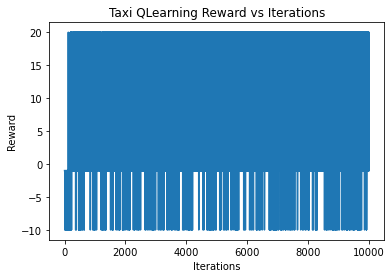

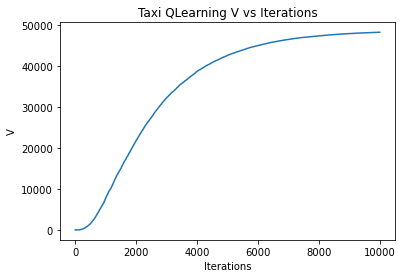

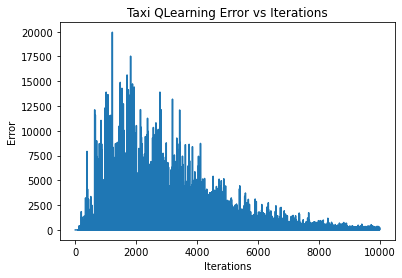

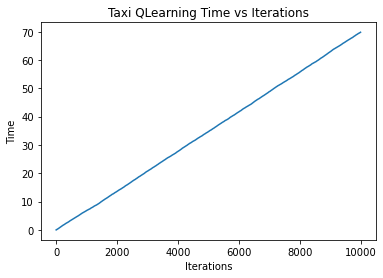

epsilon:  0.1
-10.0
20.0


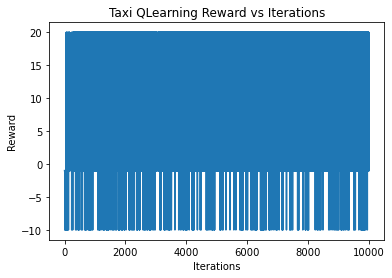

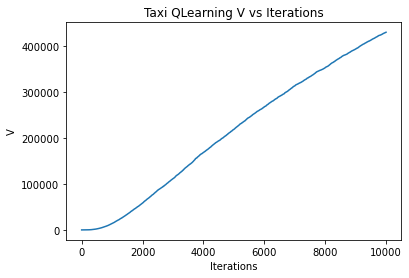

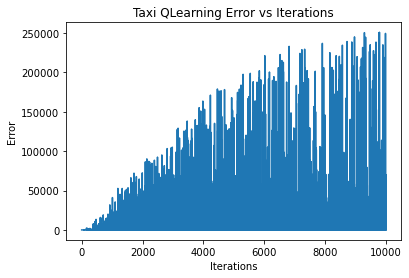

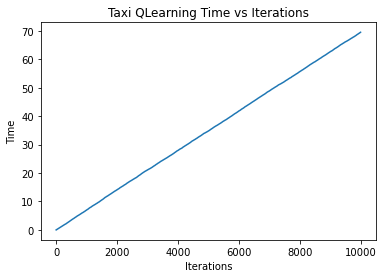

epsilon:  0.1
-10.0
20.0


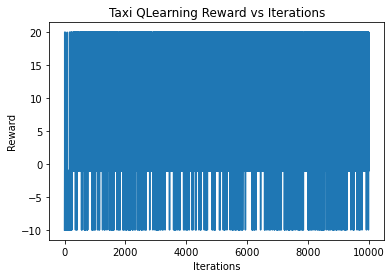

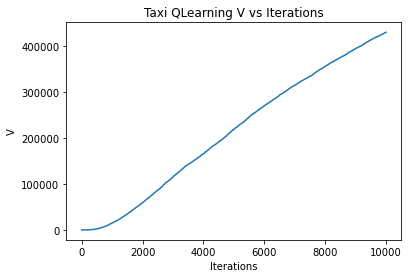

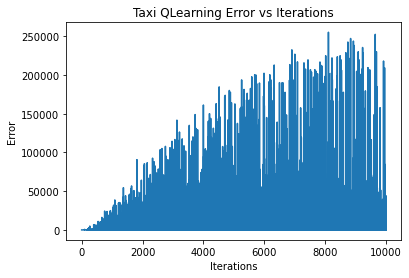

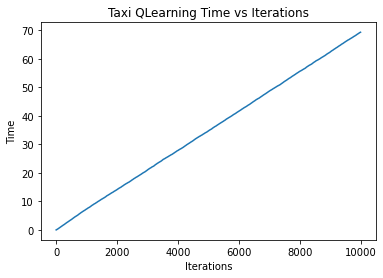

epsilon:  0.1
-10.0
20.0


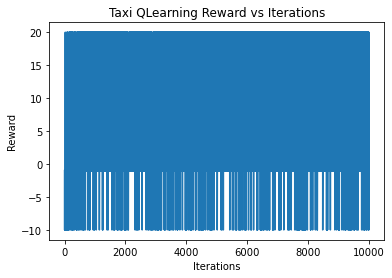

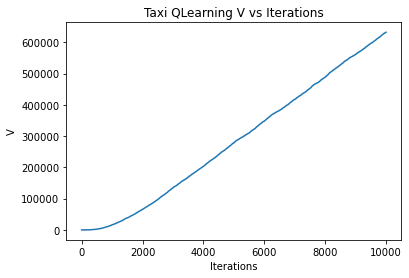

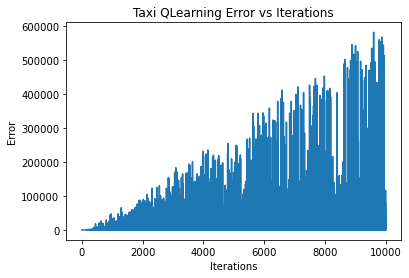

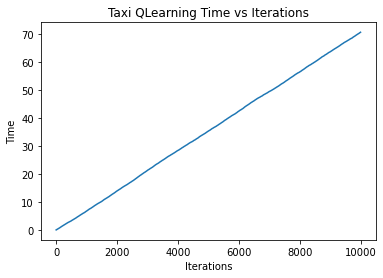

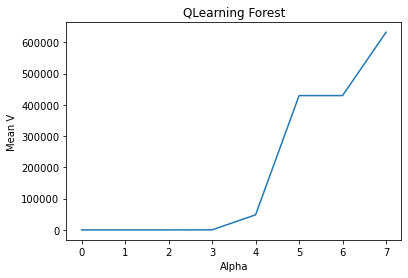

In [58]:
size = [.9, .99, .999, .9999, .99999, .999999, .9999999]
print('Taxi QLearning Alpha Decay exploration')
# iters_list = [40000000, 20000000, 10000000, 5000000, 1000000]
# time_taken = []
rewards_qlearning = []
for s in size:
    q_learning = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=.99, n_iter=500000, alpha=.9, alpha_decay=s#, epsilon_decay=.9999999# alpha=.6, alpha_decay=.1
                                          #,
                                          # epsilon=.1, alpha=.2,
                                          # epsilon_decay=.1, alpha_decay=.1,
                                          # epsilon_min=.01
                                          )
    q_learning_stats = q_learning.run()
    plot_q_learning(q_learning_stats, 'Taxi QLearning', 'Reward')
    plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'V')
    plot_learning(q_learning_stats, 'Taxi QLearning', 'Error')
    plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')
    rewards_qlearning.append(q_learning_stats[-1]['Mean V'])
#     time_taken.append(q_learning.time)
# plot_q_learning_timetaken(time_taken)
plot_alpha(rewards_qlearning, 'QLearning Forest')

Taxi QLearning Epsilon Decay exploration
epsilon:  0.1


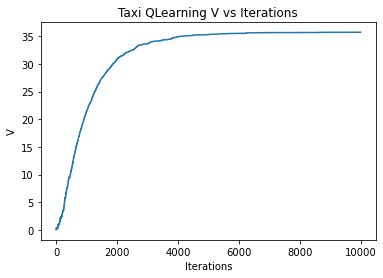

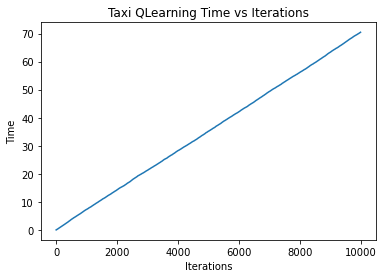

epsilon:  0.1


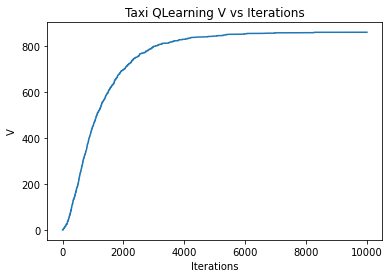

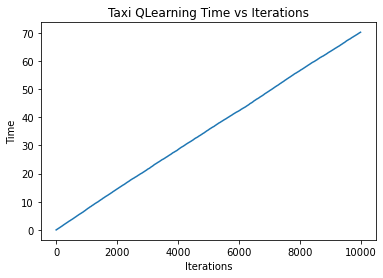

epsilon:  0.1


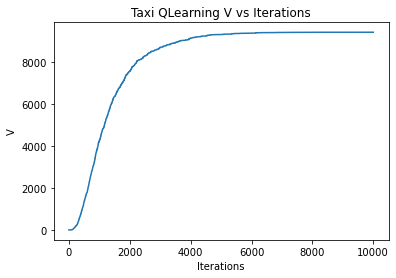

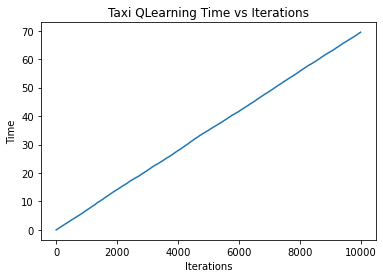

epsilon:  0.1


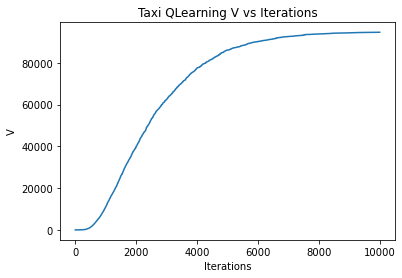

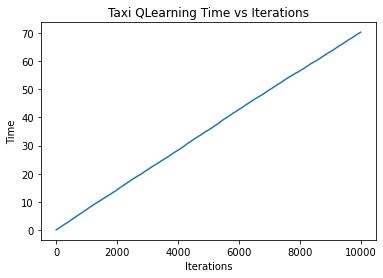

epsilon:  0.1


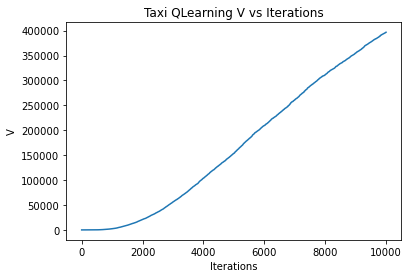

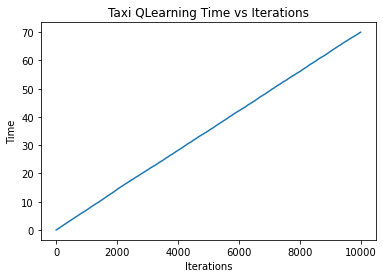

epsilon:  0.6065305080711497


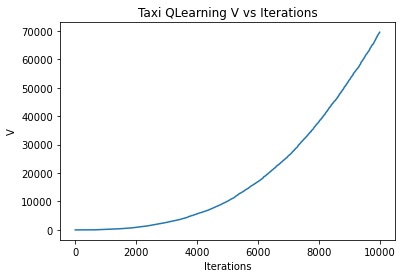

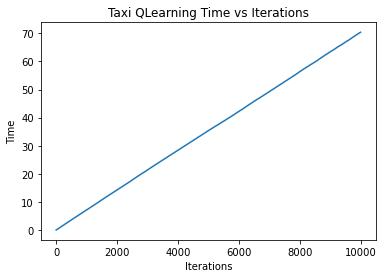

epsilon:  0.9512294221477116


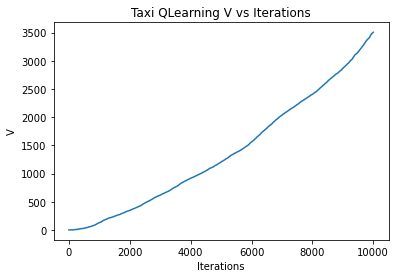

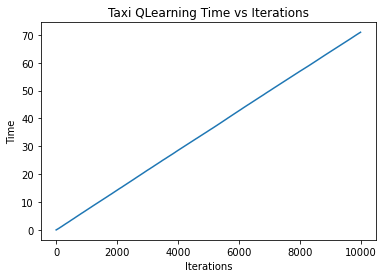

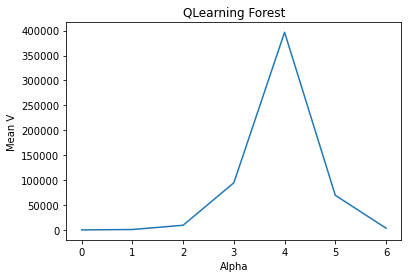

In [60]:
size = [.9, .99, .999, .9999, .99999, .999999, .9999999]
print('Taxi QLearning Epsilon Decay exploration')
# iters_list = [40000000, 20000000, 10000000, 5000000, 1000000]
# time_taken = []
rewards_qlearning = []
for s in size:
    q_learning = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=s, n_iter=500000, alpha=.9, alpha_decay=.9999999,
                                          epsilon_decay=s)
    q_learning_stats = q_learning.run()
    plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'V')
    plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')
    rewards_qlearning.append(q_learning_stats[-1]['Mean V'])
#     time_taken.append(q_learning.time)
# plot_q_learning_timetaken(time_taken)
plot_epsilon(rewards_qlearning, 'QLearning Forest')

QLearning Taxi
epsilon:  0.1
-10.0
20.0


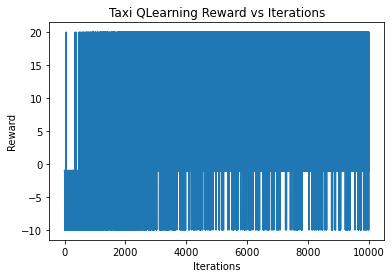

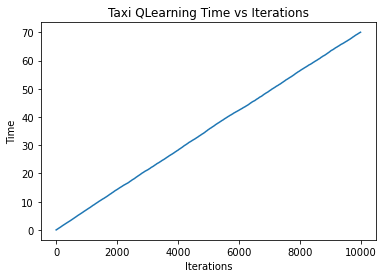

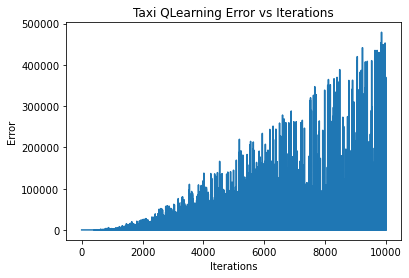

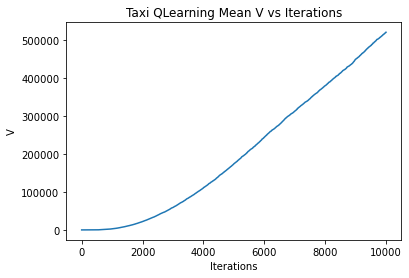

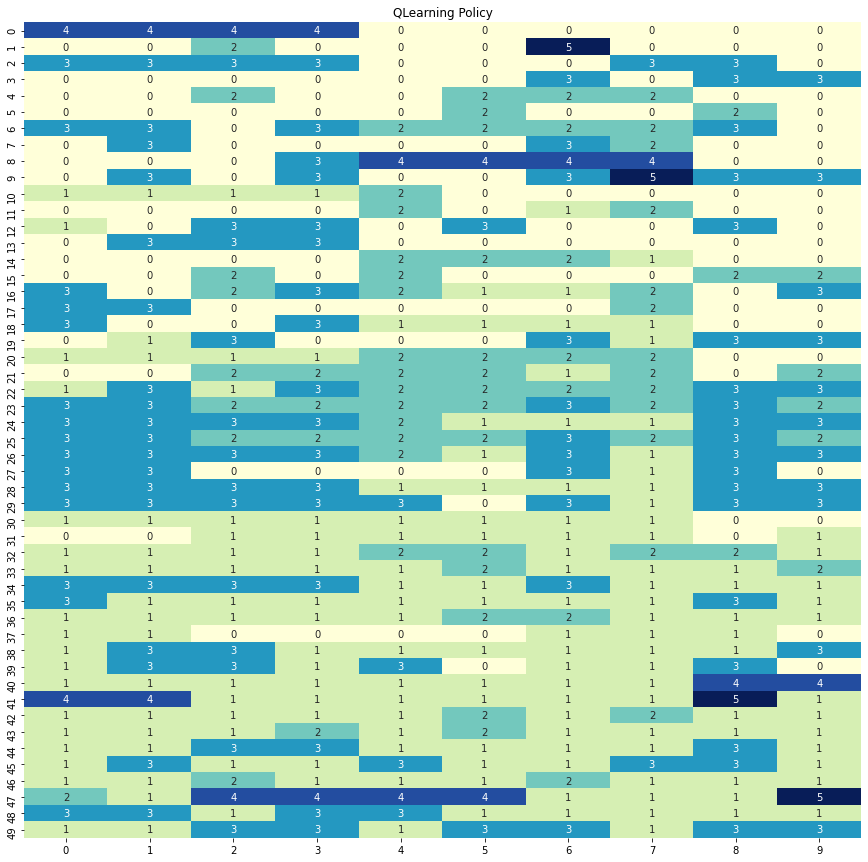

In [67]:
print("QLearning Taxi")
q_learning = mdptoolbox.mdp.QLearning(transitions=transition_matrix, reward=rewards,
                                          gamma=s, n_iter=500000, alpha=.9, alpha_decay=.9999999,
                                          epsilon_decay=.99999)
q_learning_stats = q_learning.run()
plot_q_learning(q_learning_stats, 'Taxi QLearning', 'Reward')
plot_learning(q_learning_stats, 'Taxi QLearning', 'Time')
plot_learning(q_learning_stats, 'Taxi QLearning', 'Error')
plot_mean_v_learning(q_learning_stats, 'Taxi QLearning', 'Mean V')
plot_matrix(np.array(q_learning.policy).reshape(50, 10), 'QLearning Policy')